# ENVIRONMENT

In [273]:
import tensorflow as tf

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)

tf.__version__


Version:  2.10.0
Eager mode:  True
GPU is NOT AVAILABLE


'2.10.0'

In [274]:
! pip install nltk sklearn numpy pandas

In [275]:
! pip install --upgrade pandas

In [276]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/afterlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /Users/afterlab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/afterlab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/afterlab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [277]:
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_hub as hub
from nltk.tokenize import RegexpTokenizer
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow import keras
from tensorflow.keras import Sequential, activations, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    SpatialDropout1D,
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

LEMMA = nltk.WordNetLemmatizer()
STOP_WORDS = stopwords.words("english")


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# suppress scientific notation in Pandas
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_colwidth", 5000)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
# pd.set_option("precision", 3)
pd.set_option("display.max_colwidth", None)

plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.dpi"] = 150

sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

import warnings

warnings.filterwarnings("ignore")

RANDOM_STATE = 1


In [278]:
original_df = pd.read_json("./src/amazon/reviews_Digital_Music_5.json", lines=True)


# Introduction

You have seen the power of using data analytical techniques to help organizations make data-driven decisions and now want to extend these models into areas of machine learning and artificial intelligence. In this task, you will explore the use of neural networks and natural language processing (NLP).

In this task, you will choose a data file from the Web Links section. The available data sets are as follows:
- [Amazon Product Data set](http://jmcauley.ucsd.edu/data/amazon/)
- [UCSD Recommender Systems Data sets](https://cseweb.ucsd.edu/~jmcauley/datasets.html)
- UCI Sentiment Labeled Sentences Data set

For this task, you will build a neural network designed to learn word usage and context using NLP techniques. You will provide visualizations and a report, as well as build your network in an interactive development environment.

# Part I:  Research Question

## A.  Describe the purpose of this data analysis by doing the following:



###  1.  Summarize one research question that you will answer using neural network models and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen dataset.

> Can we use a neural network and NLP on existing customer reviews and ratings to predict user sentiment on a piece of music?


###  2.  Define the objectives or goals of the data analysis. Be sure the objectives or goals are reasonable within the scope of the research question and are represented in the available data.
> The analysis goal is to determine if we can predict positive or negative sentiment on a music review based on the word choice within the review.


### 3.  Identify a type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected data set.
> This analysis will use a Recurrent Neural Network (RNN). RNNs excel at NLP and recognize sequential data characteristics to predict target values. Furthermore, these networks feed a hidden layer's output into the input layer for the next epoch (Pedamkar, 2022). This approach allows the model to self-learn and correct predictions (Ghoshal, 2021). In this analysis, we'll input sequential data in the form of lists of numerically encoded words into the network and receive a binary sentiment classification as the output.

# Part II:  Data Preparation


## B.  Summarize the data cleaning process by doing the following:



### 0. Misc. Data Prep

In [279]:
TOKENIZER = tf.keras.preprocessing.text.Tokenizer(
    num_words=5000, oov_token="[UNK]", lower=True
)


In [280]:
def clean_text(s: str, tokenizer) -> str:
    tokens = [LEMMA.lemmatize(word=word) for word in s]

    # remove stop words
    tokens = [word for word in tokens if word not in STOP_WORDS]

    # rejoin tokens into a string
    return " ".join(tokens)


def get_index(data, tokenizer, n=25, reverse=True):
    tokenizer.fit_on_texts(data)
    index = tokenizer.word_index

    sorted_index = dict(
        sorted(index.items(), key=lambda kv: (kv[1], kv[0]), reverse=reverse)[0:n]
    )
    return tokenizer, len(index) + 1, sorted_index


In [281]:
original_df.shape


(64706, 9)

In [282]:
original_df.columns


Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [283]:
original_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      64706 non-null  object
 1   asin            64706 non-null  object
 2   reviewerName    64529 non-null  object
 3   helpful         64706 non-null  object
 4   reviewText      64706 non-null  object
 5   overall         64706 non-null  int64 
 6   summary         64706 non-null  object
 7   unixReviewTime  64706 non-null  int64 
 8   reviewTime      64706 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.4+ MB


In [284]:
%%time
prep_df = original_df[["reviewText", "overall"]].copy()
prep_df = prep_df.rename(columns={"reviewText": "raw_text", "overall": "sentiment"})
prep_df["raw_word_count"] = prep_df.raw_text.apply(lambda x: len(x.split(" ")))

# track the text preparation transformations
text_stages_df = prep_df[["raw_text"]].head()

# drop reviews with neutral sentiment
prep_df = prep_df[prep_df.sentiment != 3]

# map sentiment scores to binary values (0 = negative, 1 = positive)
prep_df["pos_neg_sentiment"] = prep_df.sentiment.map(lambda x: 1 if x > 3 else 0 )

prep_df.head(1)

CPU times: user 639 ms, sys: 4.52 ms, total: 643 ms
Wall time: 642 ms


,raw_text,sentiment,raw_word_count,pos_neg_sentiment
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1


In [285]:
%%time

# strip white space and lowercase review
prep_df["clean_text"] = prep_df["raw_text"].str.strip().str.lower()
text_stages_df["cleanStage1"] = prep_df["clean_text"].head()

# remove non-word characters
prep_df["clean_text"] = prep_df["clean_text"].apply(lambda x: " ".join(RegexpTokenizer("[a-z-A-Z']+").tokenize(x)))
text_stages_df["cleanStage2"] = prep_df["clean_text"].head()

# Remove unusual characters: uppercase letters, punctuation marks, emoticons, and non-English characters.
prep_df["clean_text"] = prep_df["clean_text"].apply(lambda x: " ".join(tf.keras.preprocessing.text.text_to_word_sequence(x)))
text_stages_df["cleanStage3"] = prep_df["clean_text"].head()

# lemmatize and remove english stop words
prep_df["clean_text"] = prep_df["clean_text"].apply(lambda x: clean_text(s=x.split(" "), tokenizer=TOKENIZER))
text_stages_df["cleanStage4"] = prep_df["clean_text"].head()
prep_df["clean_word_count"] = prep_df.clean_text.apply(lambda x: len(x.split(" ")))


prep_df.head(1)


CPU times: user 50.2 s, sys: 69.7 ms, total: 50.2 s
Wall time: 50.3 s


,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93


In [286]:
text_stages_df


,raw_text,cleanStage1,cleanStage2,cleanStage3,cleanStage4
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!","it's hard to believe ""memory of trees"" came out 11 years ago;it has held up well over the passage of time.it's enya's last great album before the new age/pop of ""amarantine"" and ""day without rain."" back in 1995,enya still had her creative spark,her own voice.i agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""memory of trees"" is elegaic&majestic.;""pax deorum"" sounds like it is from a requiem mass,it is a dark threnody.unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,i don't find it disconcerting at all.""anywhere is"" is a hopeful song,looking to possibilities.""hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.i've always had a soft spot for this song.""on my way home"" is a triumphant ending about return.this is truly a masterpiece of new age music,a must for any enya fan!",it's hard to believe memory of trees came out years ago it has held up well over the passage of time it's enya's last great album before the new age pop of amarantine and day without rain back in enya still had her creative spark her own voice i agree with the reviewer who said that this is her saddest album it is melancholy bittersweet from the opening title song memory of trees is elegaic majestic pax deorum sounds like it is from a requiem mass it is a dark threnody unlike the reviewer who said that this has a disconcerting blend of spirituality sensuality i don't find it disconcerting at all anywhere is is a hopeful song looking to possibilities hope has a place is about love but it is up to the listener to decide if it is romantic platonic etc i've always had a soft spot for this song on my way home is a triumphant ending about return this is truly a masterpiece of new age music a must for any enya fan,it's hard to believe memory of trees came out years ago it has held up well over the passage of time it's enya's last great album before the new age pop of amarantine and day without rain back in enya still had her creative spark her own voice i agree with the reviewer who said that this is her saddest album it is melancholy bittersweet from the opening title song memory of trees is elegaic majestic pax deorum sounds like it is from a requiem mass it is a dark threnody unlike the reviewer who said that this has a disconcerting blend of spirituality sensuality i don't find it disconcerting at all anywhere is is a hopeful song looking to possibilities hope has a place is about love but it is up to the listener to decide if it is romantic platonic etc i've always had a soft spot for this song on my way home is a triumphant ending about return this is truly a masterpiece of new age music a must for any enya fan,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative sp

###  1.  Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:


#### Missing Values

In [287]:
pd.DataFrame(original_df.isnull().sum(), columns=["# Nulls"])
f"{original_df.isnull().sum().sum():,} Total Null Cells"


,# Nulls
reviewerID,0
asin,0
reviewerName,177
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0


'177 Total Null Cells'

#### Sentiment Counts (1-5)

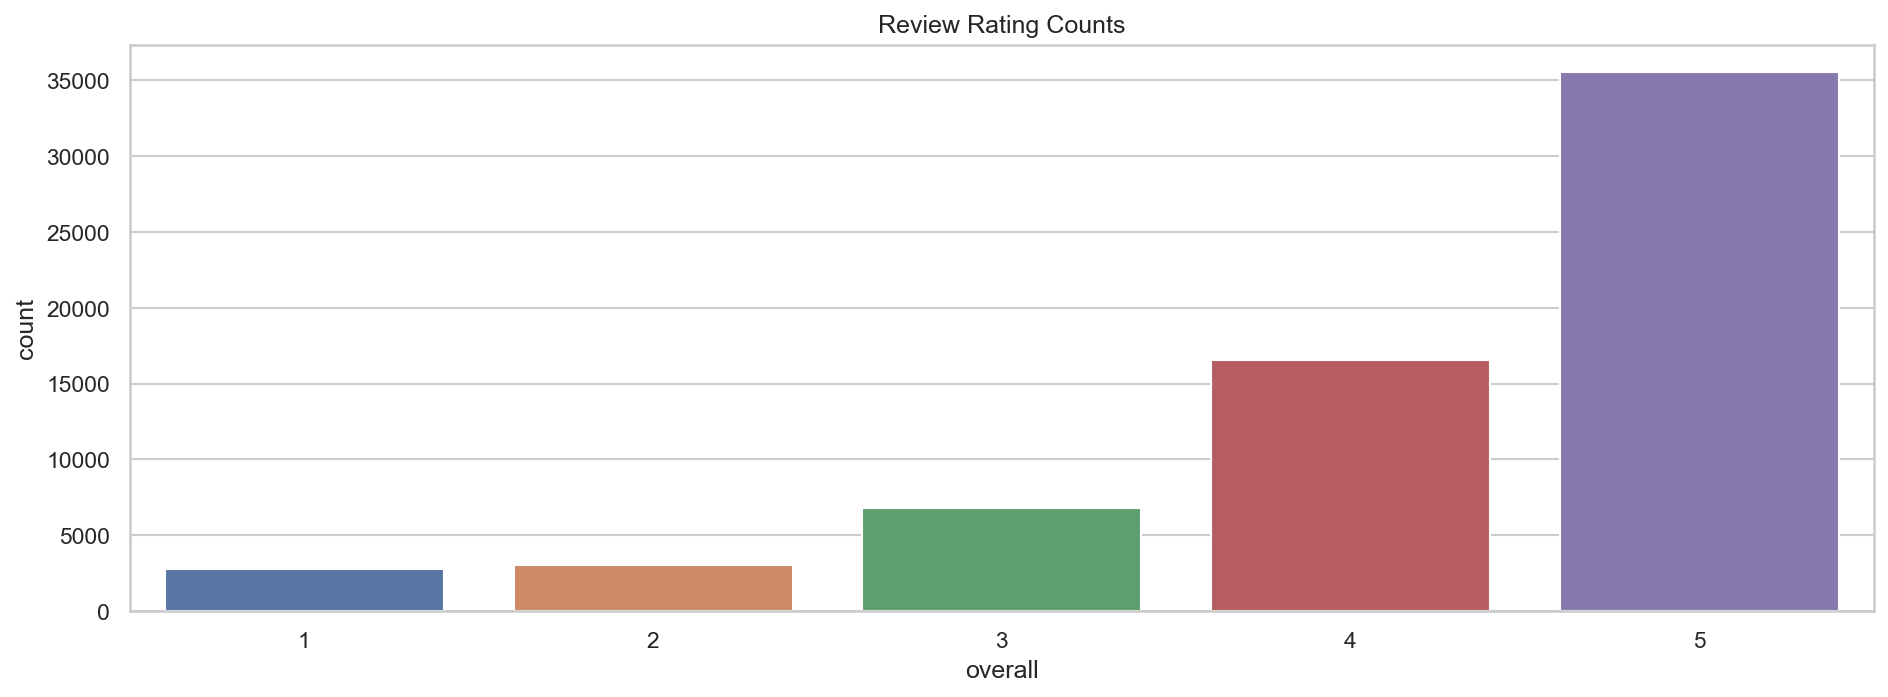

In [288]:
_ = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=original_df.overall)
_ = plt.title("Review Rating Counts")


#### Sentiment Counts (Neutral Removed)

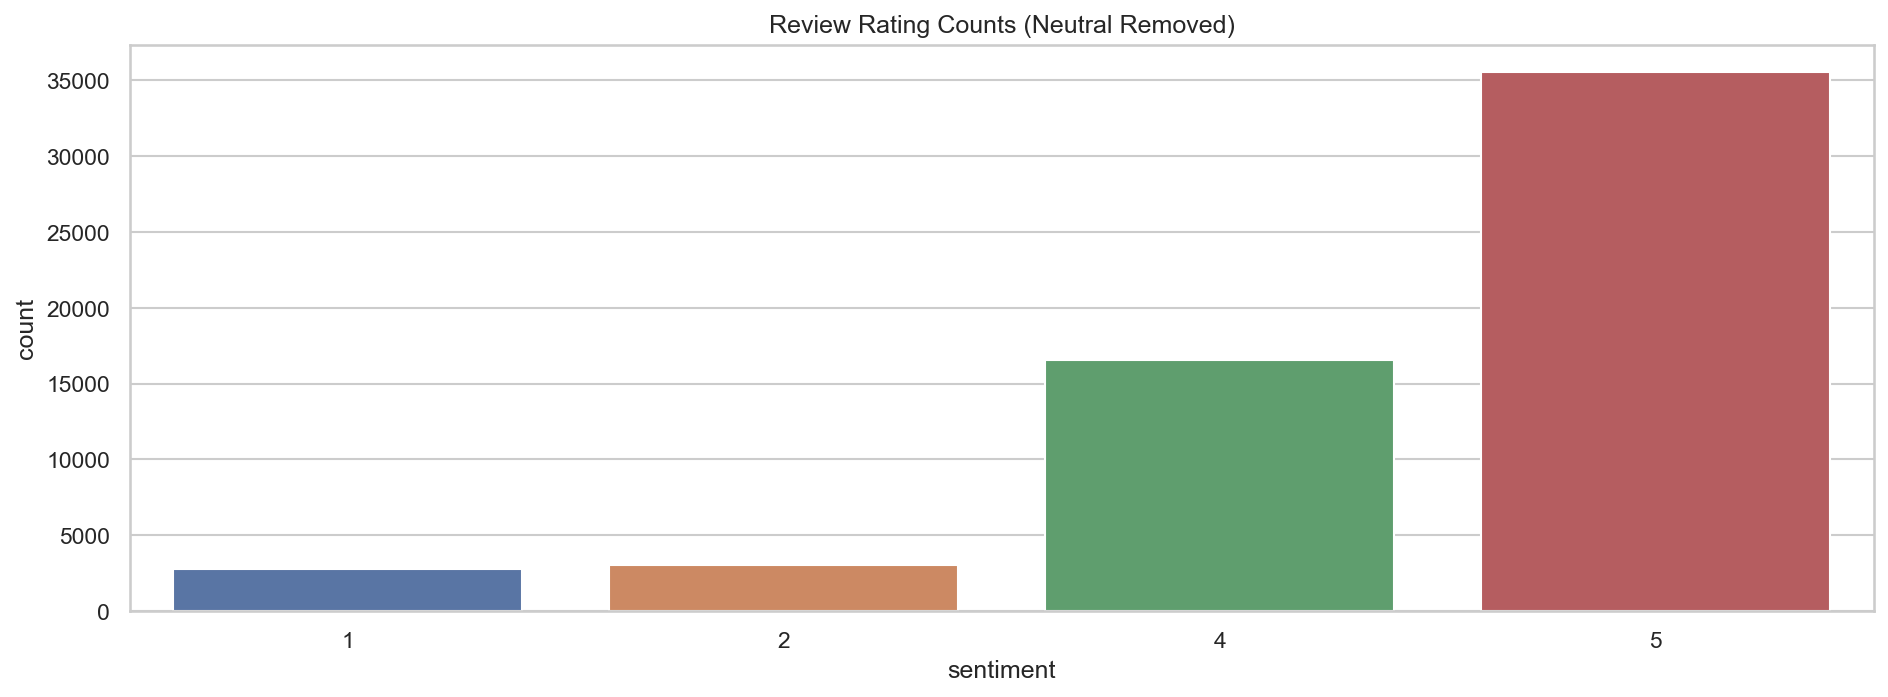

In [289]:
_ = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=prep_df.sentiment)
_ = plt.title("Review Rating Counts (Neutral Removed)")


#### Sentiment Counts (Pos or Neg)

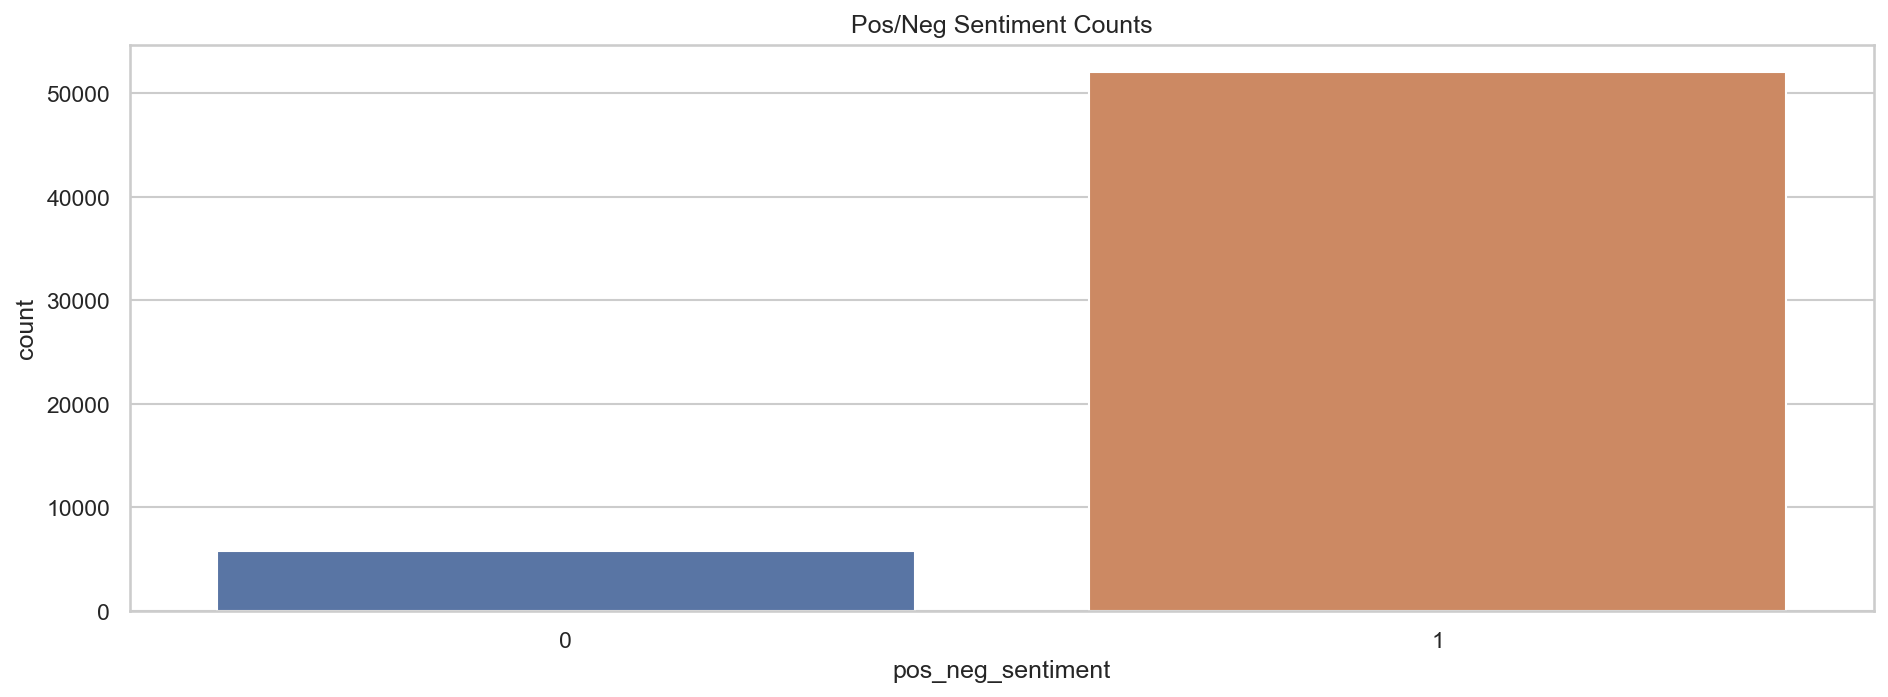

In [290]:
prep_df["pos_neg_sentiment"] = prep_df.sentiment.map(lambda x: 1 if x > 3 else 0)

_ = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=prep_df.pos_neg_sentiment)
_ = plt.title("Pos/Neg Sentiment Counts")


In [291]:
prep_df.head(1)


,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93


####  a. presence of unusual characters (e.g., emojis, non-English characters, etc.)
> Unusual or non-word characters do exist within review texts


In [292]:
def get_non_words(data):
    non_word_tokenizer = RegexpTokenizer("[^a-zA-Z\s]")

    # tokenize on non-word and non-space characters
    return non_word_tokenizer.tokenize(text=data)


tokens_df = original_df.reviewText.apply(lambda x: set(get_non_words(data=x)))
tokens_df


0                                {', ., 9, !, 1, ,, &, 5, ", /, ;}
1                                                     {', ,, ., -}
2                                                        {', ,, .}
3                                            {', ., !, ), ,, -, (}
4        {1, ,, :, ', ., 9, -, 5, ", ;, 8, ?, ), 3, (, 0, /, 7, 2}
                                   ...                            
64701                                                          {.}
64702                                                 {', ., !, -}
64703                                                       {,, .}
64704                            {', ., !, ), ,, &, 3, 4, (, #, ;}
64705                      {', ., !, 1, ), &, ,, 3, 4, (, 0, #, ;}
Name: reviewText, Length: 64706, dtype: object

In [293]:
token_set = set()

for tokens in tokens_df:
    for token in tokens:
        token_set.add(token)

print("Non-Word Tokens Exist")
print(sorted(list(token_set)))


Non-Word Tokens Exist
['\x03', '\x16', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


####  b. vocabulary size
> the vocabulary size is 122,270 words

In [294]:
rwc = (
    prep_df.raw_word_count.describe(percentiles=[0.25, 0.5, 0.75, 0.95])
    .round()
    .astype(int)
)
cwc = (
    prep_df.clean_word_count.describe(percentiles=[0.25, 0.5, 0.75, 0.95])
    .round()
    .astype(int)
)
delta = cwc / rwc
pd.DataFrame(
    zip(rwc, cwc, delta),
    index=rwc.index,
    columns=["Raw Word Count", "Clean Word Count", "Delta"],
)


199 * 0.55



,Raw Word Count,Clean Word Count,Delta
count,57917,57917,1.00
mean,199,110,0.55
std,193,107,0.55
min,1,1,1.00
25%,70,38,0.54
50%,141,77,0.55
75%,259,144,0.56
95%,571,316,0.55
max,4587,2529,0.55


109.45

In [295]:
tokenizer, vocab_size, word_index_top_k = get_index(
    data=prep_df.clean_text, tokenizer=TOKENIZER
)

f"{tokenizer = }"
f"{vocab_size = }"
f"TOP 25 Words: {word_index_top_k = }"


'tokenizer = <keras.preprocessing.text.Tokenizer object at 0x7f7ccb0e7700>'

'vocab_size = 113598'

'TOP 25 Words: word_index_top_k = {\'atweh\': 113597, \'nasri\': 113596, \'instigate\': 113595, \'segu\': 113594, \'chiropractor\': 113593, \'sunsdoesn\': 113592, \'presencerakim\': 113591, \'songtom\': 113590, \'sandcons\': 113589, \'thingsbest\': 113588, \'solosenergybetter\': 113587, \'lengthepic\': 113586, \'conceptalbum\': 113585, \'masterpiececonclusion\': 113584, \'untraveled\': 113583, \'offbalanced\': 113582, \'victimized\': 113581, \'steppy\': 113580, \'looooove\': 113579, \'bloodwork\': 113578, \'trilobite\': 113577, "dailor\'s": 113576, \'readjust\': 113575, "skye\'": 113574, \'andblood\': 113573}'

In [296]:
# spot check cleaned review text
prep_df[["clean_text"]].sample(n=10)


,clean_text
28431,one best cd buckcherry relased coming bonus dvd music video band great fan good band
26855,billy joel breeze variety style ranging doo wop four season there's even little beethoven thrown show he's smarter u joel's transition variety style seem almost effortless course get much criticism talent cannot questioned almost seems like stuff sleep
59846,'lost time' match one industry's greatest voice outstanding music lyric nostalgia never go style classic soulful reflective cd conjures summer memory childhood influence touchstone song cheryl lynn's got real stylistics' everything o'jays' backstabbers gap band's yearning love heard throughout cd favorite song paid ft eddie levert always reason stir good life never want live without also enjoy rendering better better originally done lalah hathaway even brings nothing new gravitate artist like r kelly cee lo marsha ambrosius making great retro music eric benet exception 'lost time' eric benet find niche classic soul stylings past outstanding cd beginning end incredibly proud
19196,live leeds ha stood rigour time one greatest live album ever legendary superb double album contains classic like summertime blue young man blue happy jack see mile heaven hell highly recommended absolute must every rock fan collection five star
34531,redman ha released three amazing album one wa pretty good fifth lp good first three nearly good last one make five straight solid album redman something limited number artist claim album first song good one diggy doc remake c 's c doctor redman brings great witty lyric match classic example song i'm type focker go meet parent redman cleverly us movie meet parent rhyme lick shot us beat similar style last album let's get dirty redman us amped rockwilder beat kick hardcore rhyme real n ha great guest appearance scarface icarus treach dat bull feature great beat reminiscent busta rhyme put hand eye see enjoy da ride feature solid guest appearance method man doggz ii us great sampling dmx dpg redman creates funky song soopaman luva appears fifth addition redman search mojo album end great song smash sumthin' seriously head nodding beat reggie rap adrenaline really bad song album reggie noble build reputation one consistent rapper ever album doe focus production wizardry first three album still reggie brings album one year best satisfy fan five straight solid album cannot believe doc's da name ha gone platinum come price selling people need check one best rapper time
6734,record among beautiful music ever wroten take careful listening quot scarborough fair canticle quot great vocal work melodic quot pattern quot little percusion work result fantastic hear quot big bright green pleasure machine quot similar quot mr robinson quot fast beat great pop quot dangling conversation quot masterpiece album great lyric great vocal work superbly orchestrated quot simple desultory philippic quot somewhat psychadelic mix bob dylan kind vocal interpretation folk rock quot emily whenever may find quot another great melody demonstration good love song vocaly superb conclusion superior piece art collection without record sad situation p greatly resmastered
57244,one hip hop album actually enjoying come none unlikely somalian intellectual ha distinct style sound smooth deep fresh reminiscent quality predescessors marley big pac na root kweli common give listen definintely well versed hip hop enjoy kind music i'm impressed guy even know say he's exactly rap need finally good hip hop album
25425,record company strange time lisa's third cd get u release label felt commerical enough u market asked lisa make change said cd released shame great cd lisa's voice smooth project song arrangement mellow jazzier groove thanks smooth jazz radio station 'never set free' 'so natural' got good airplay every time song got played dj would get phone call get song say import cd prof cd would've done well proper promotion wa behind thanks tower record able get 'goodbye' 'be mine' 'marvell

In [297]:
tokenizer, vocab_size, counts = get_index(data=prep_df.clean_text, tokenizer=TOKENIZER)

vocab_size += 1
print(f"Vocab Size: {vocab_size:,}")
counts


Vocab Size: 113,599


{'atweh': 113597,
 'nasri': 113596,
 'instigate': 113595,
 'segu': 113594,
 'chiropractor': 113593,
 'sunsdoesn': 113592,
 'presencerakim': 113591,
 'songtom': 113590,
 'sandcons': 113589,
 'thingsbest': 113588,
 'solosenergybetter': 113587,
 'lengthepic': 113586,
 'conceptalbum': 113585,
 'masterpiececonclusion': 113584,
 'untraveled': 113583,
 'offbalanced': 113582,
 'victimized': 113581,
 'steppy': 113580,
 'looooove': 113579,
 'bloodwork': 113578,
 'trilobite': 113577,
 "dailor's": 113576,
 'readjust': 113575,
 "skye'": 113574,
 'andblood': 113573}

####  c. proposed word embedding length

In [298]:
max_sequence_embedding = round(vocab_size ** (1 / 4))
f"The {max_sequence_embedding = }"


'The max_sequence_embedding = 18'

In [299]:
# tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE)
tf.keras.layers.Embedding(vocab_size, max_sequence_embedding)


####  d. statistical justification for the chosen maximum sequence length

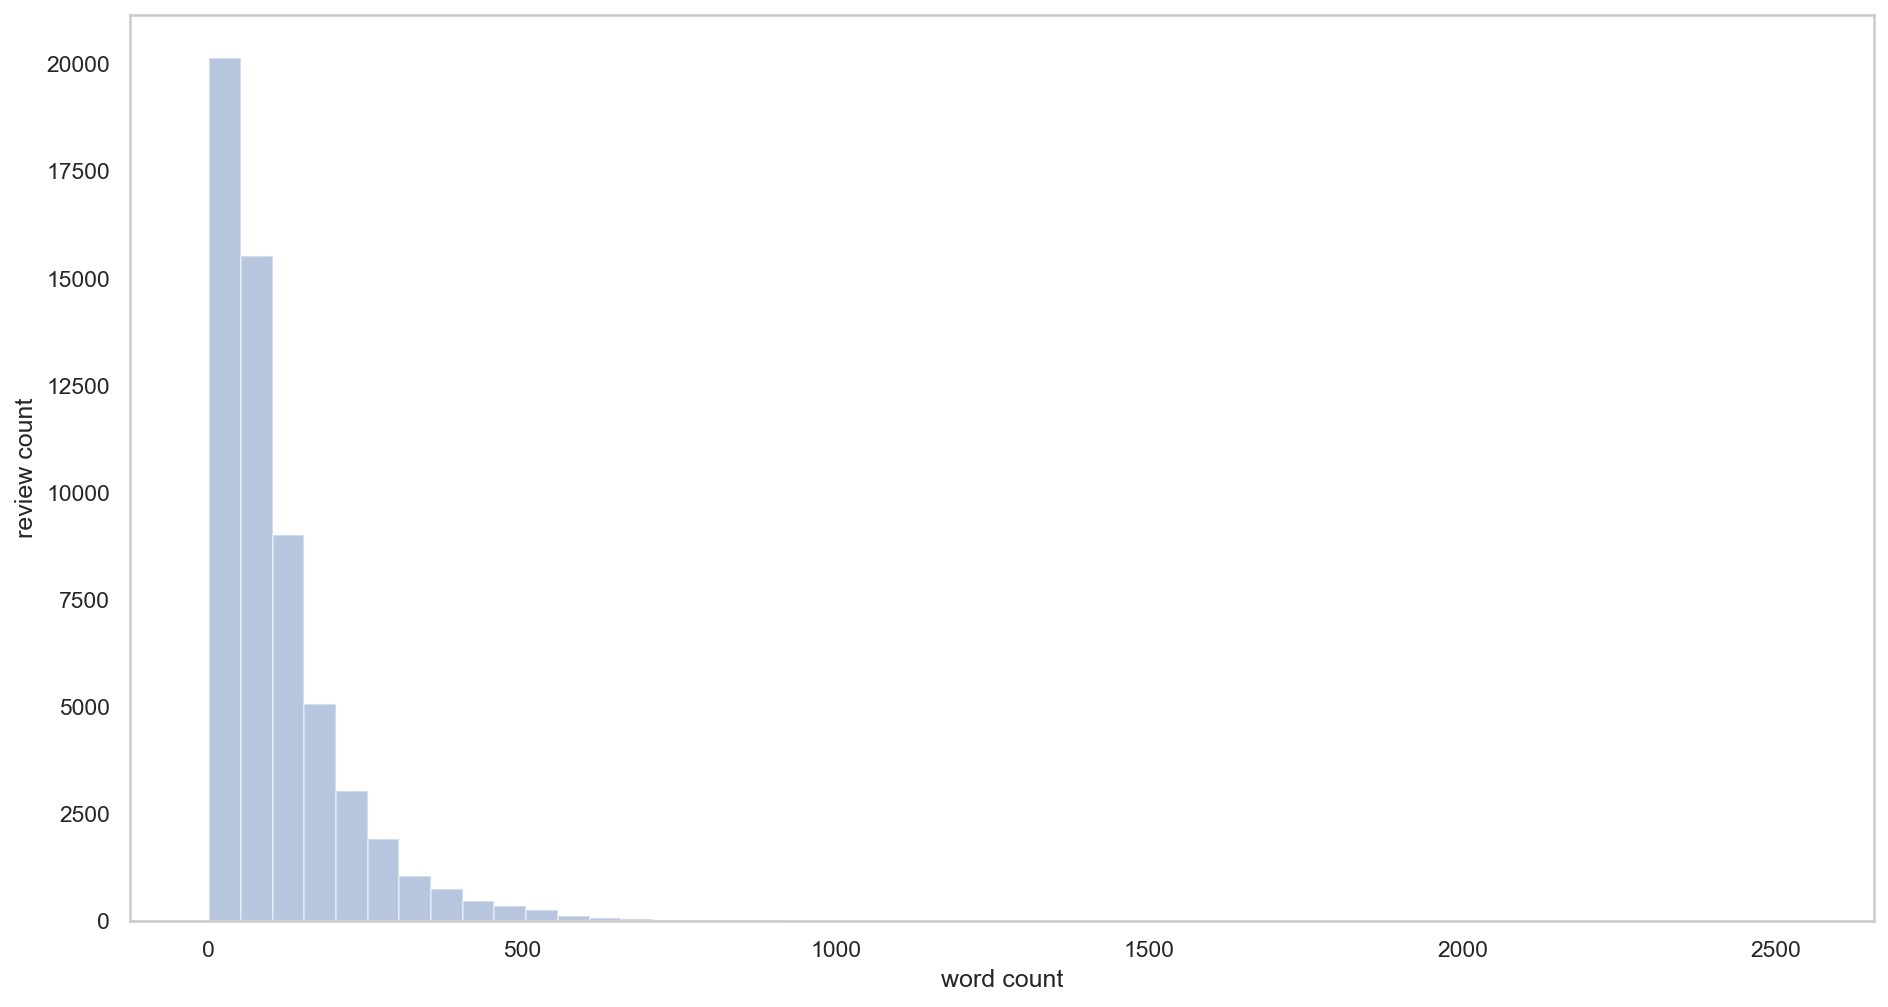

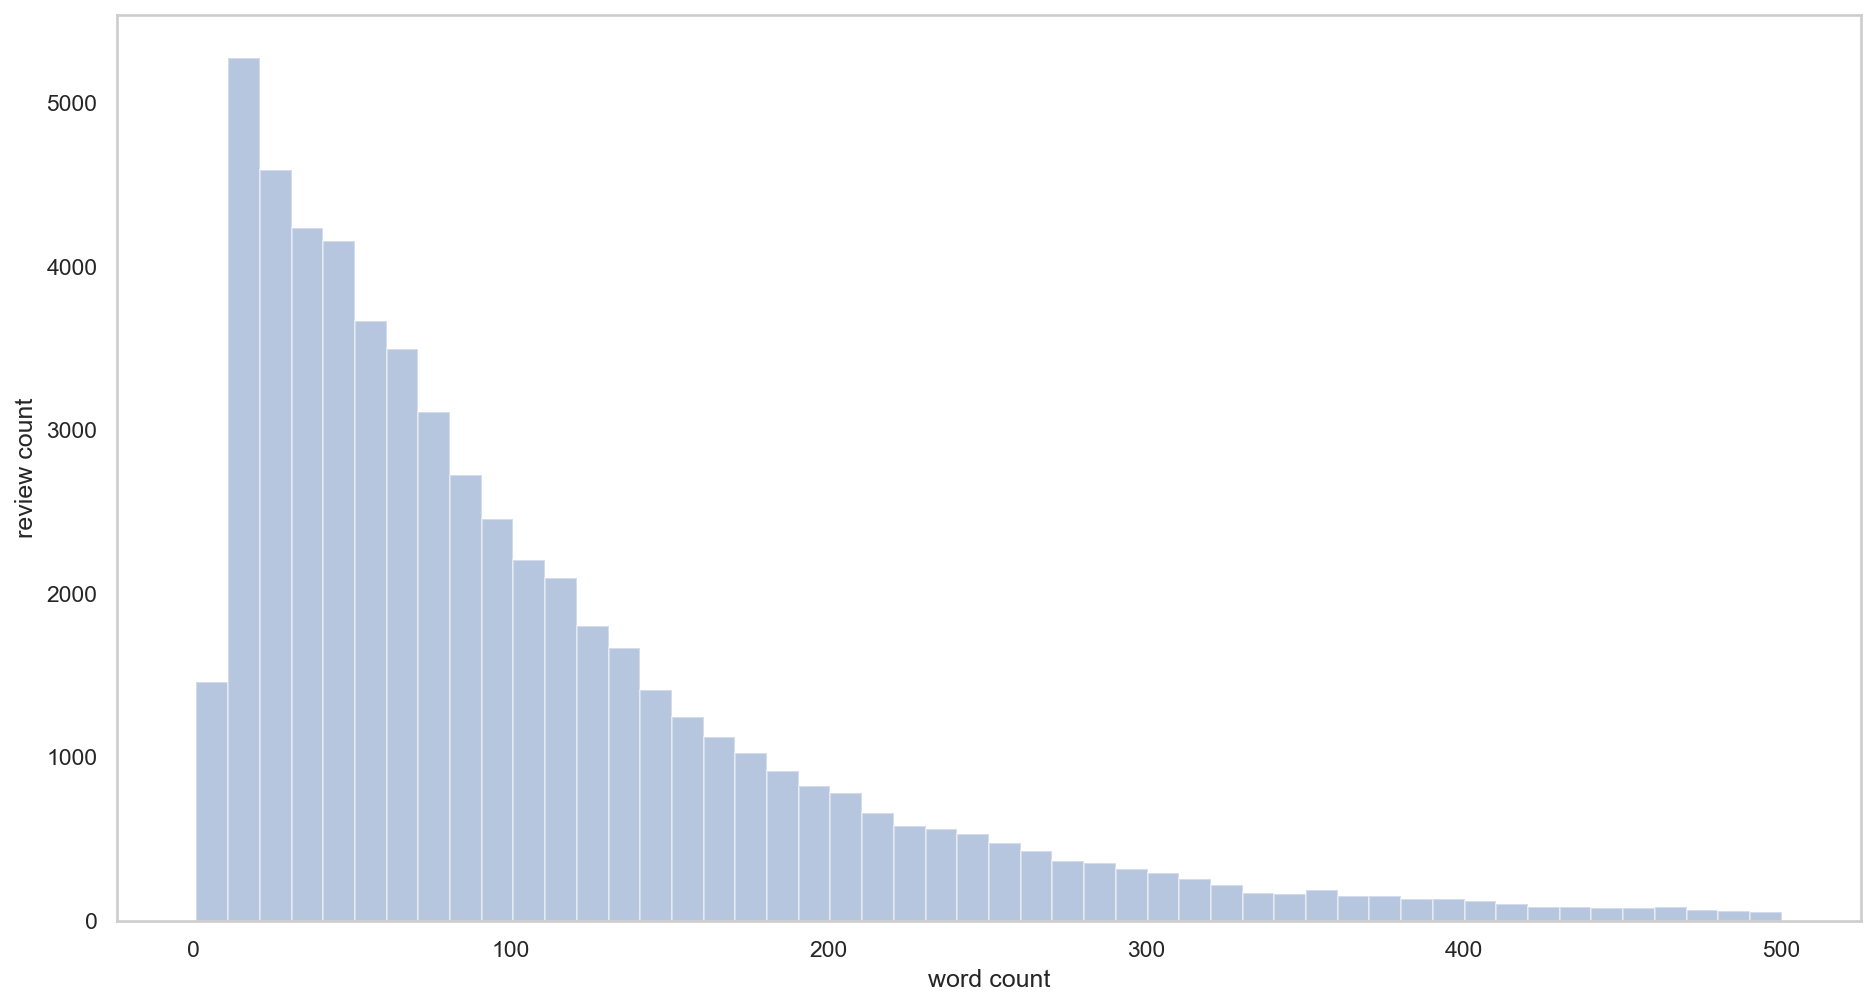

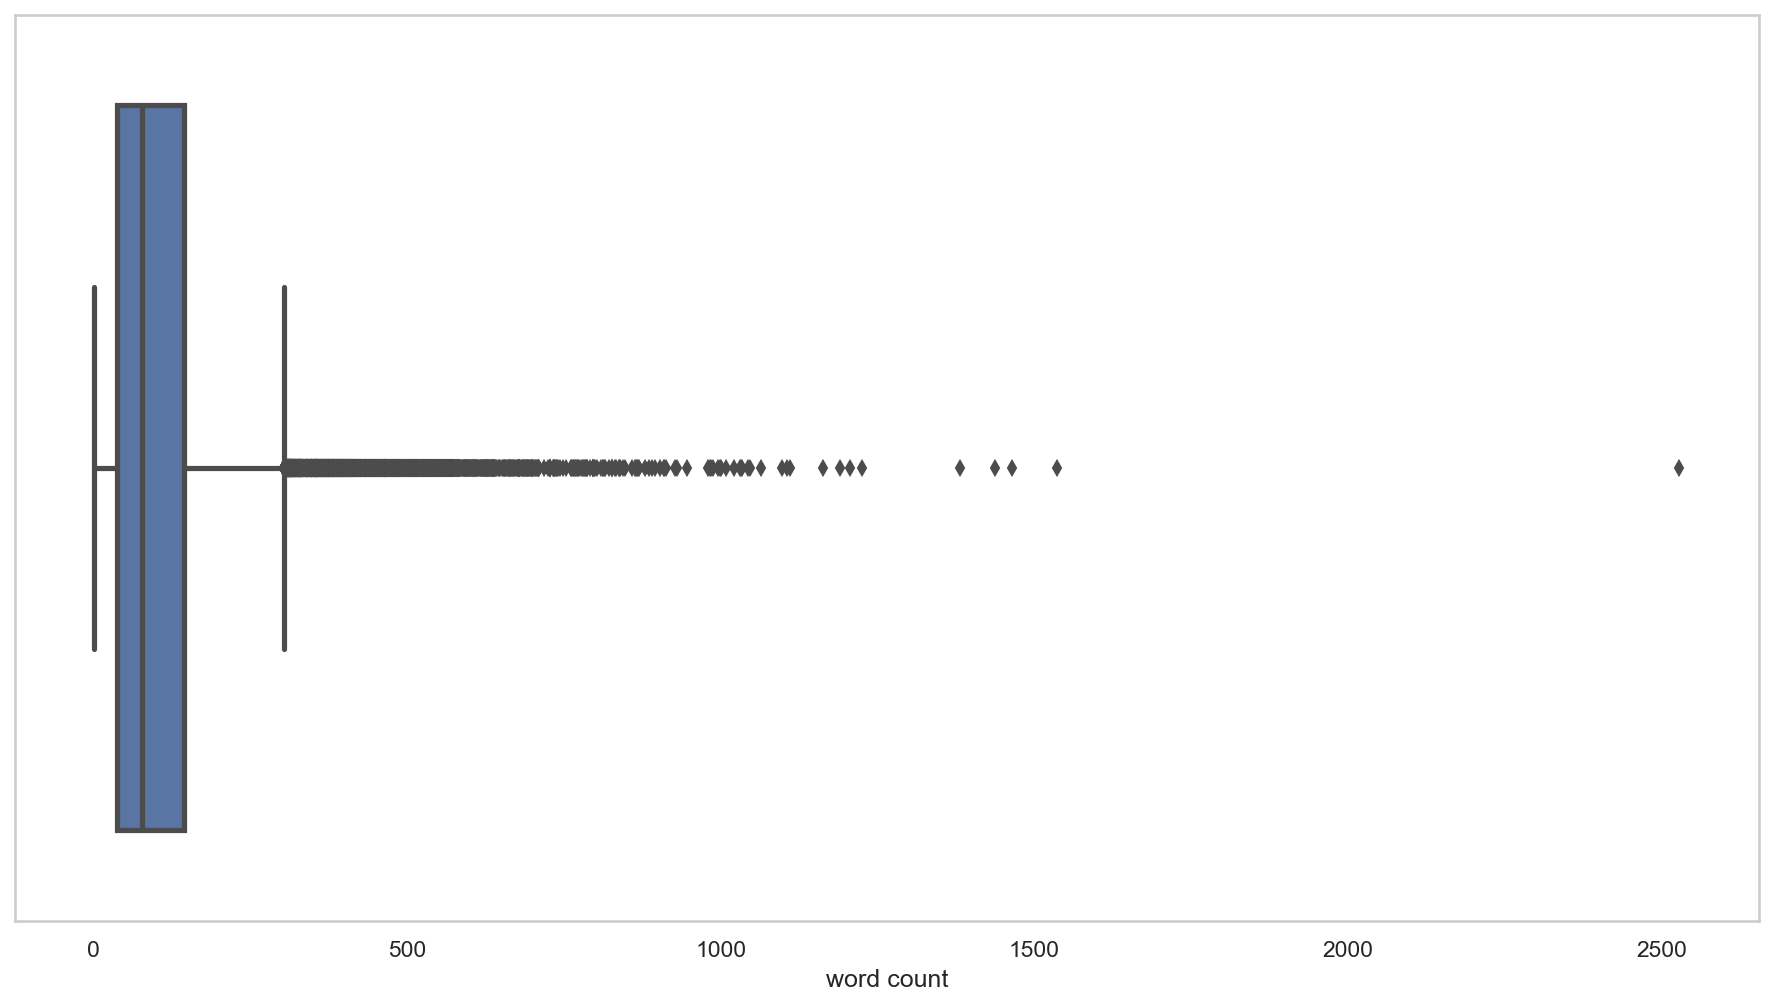

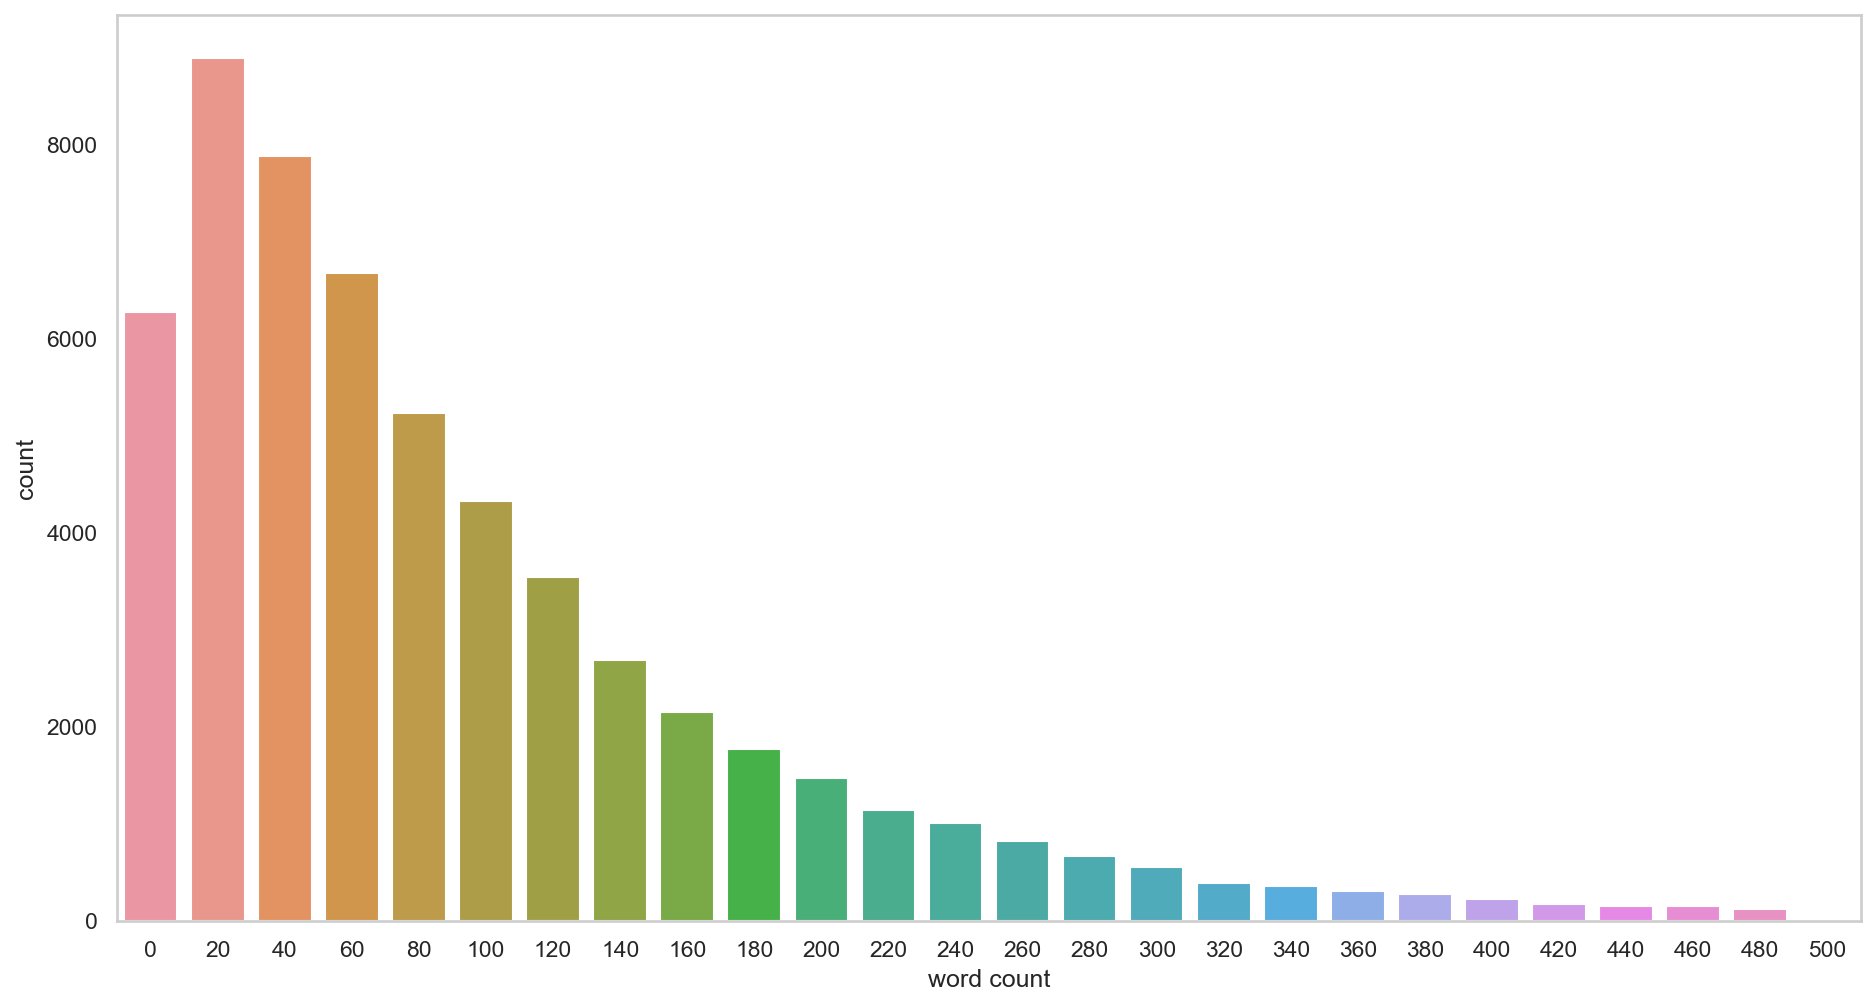

In [300]:
_ = plt.figure(figsize=(15, 8))
ax = sns.distplot(prep_df.clean_word_count, kde=False)
plt.grid(False)
_ = plt.ylabel("review count")
_ = plt.xlabel("word count")
plt.show()

_ = plt.figure(figsize=(15, 8))
ax = sns.distplot(prep_df[prep_df.clean_word_count <= 500].clean_word_count, kde=False)
plt.grid(False)
_ = plt.ylabel("review count")
_ = plt.xlabel("word count")
plt.show()

_ = plt.figure(figsize=(15, 8))
ax = sns.boxplot(x=prep_df.clean_word_count)
plt.grid(False)
_ = plt.xlabel("word count")
plt.show()

_ = plt.figure(figsize=(15, 8))
ax = sns.countplot(
    x=round(prep_df[prep_df.clean_word_count <= 500].clean_word_count // 20) * 20
)
plt.grid(False)
_ = plt.xlabel("word count")
plt.show()


In [301]:
prep_df[["clean_word_count"]].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

max_review_length = int(round(prep_df[["clean_word_count"]].quantile(0.5)))

print(
    f"Based on the average review length, the max review length should be: {max_review_length}"
)


,clean_word_count
count,57917.00
mean,109.55
std,106.94
min,1.00
25%,38.00
50%,77.00
75%,144.00
90%,241.00
95%,316.00
max,2529.00


Based on the average review length, the max review length should be: 77


###  2.  Describe the goals of the tokenization process, including any code generated and packages that are used to normalize text during the tokenization process.

####  Goals
> The tokenization process goal for this analysis is to separate each review's text into smaller chunks, referred to as tokens. These tokens can be in the form of words, characters, or word stems. During this process, we'll strip leading and trailing whitespaces, lowercase words, remove non-word characters and lemmatize the words (Pai, 2022). Lastly, this process will generate an index of unique tokens where the index keys are tokens and the values are the token frequencies — this index also provides us with the vocabulary size for the embeddings.

####  packages that are used to normalize text during the tokenization process.

> The two main packages used for this process were tensorflow.keras.preprocessing.text.Tokenizer and nltk.tokenize.RegexpTokenizer. We used Tokenizer to build the word index and calculate the vocabulary size. We used RegexpTokenizer to split the original review text using a regular expression. Additionally, we used nltk.WordNetLemmatizer to lemmatize the words and nltk.stopwords.words('english') to remove stopwords from the text.

In [302]:
prep_df["encoded_text"] = TOKENIZER.texts_to_sequences(prep_df.clean_text.values)

prep_df.head()



,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count,encoded_text
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 284, 774, 1447, 158, 30, 430, 9, 1881, 22, 2680, 15, 1, 84, 11, 2, 32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]"
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5,103,1,clasically styled introverted album memory tree masterpiece subtlety many song endearing shyness soft piano lovely quiet voice within every introvert inferno enya let fire explode couple song absolutely burst expected raw power never heard enya might want start one popularized work like watermark play safe already fan collection complete without beautiful work musical art,54,"[1, 2999, 1, 2, 774, 1447, 314, 4633, 42, 3, 4184, 1, 541, 185, 741, 971, 59, 843, 67, 1, 1, 1, 172, 364, 4939, 333, 3, 478, 2628, 1203, 603, 301, 60, 61, 1, 220, 87, 123, 6, 1, 52, 7, 1, 142, 1759, 267, 34, 108, 549, 145, 117, 52, 139, 498]"
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",5,84,1,never thought enya would reach sublime height evacuee marble hall 'shepherd moon ' 'the celt watermark day ' pleasant admirable throughout le ambitious lyrically musically hop

### 3.  Explain the padding process used to standardize the length of sequences, including the following in your explanation:
> A neural network requires our inputs to have the same vector dimensions. During our EDA, we discovered that the text review had non-uniform lengths. Some reviews were as short as one word, whereas others were as long as 2,529 words. As a result, we needed to make the dimensions of these network inputs uniform (Kilinc, 2020). 

> The padding process was used to standardize the length of word sequences. More specifically, this process will ensure the word sequences that were shorter than an average of 77 words were padded with empty words or 0. Similarly, sequences longer than 77 words were truncated to 77 words. We used the default approach of padding and truncating at the beginning of the text sequence.


In [303]:
f"{max_review_length = }"

prep_df["padded_text"] = prep_df["encoded_text"].apply(
    lambda x: pad_sequences(
        sequences=[x], maxlen=max_review_length, padding="pre", truncating="pre"
    )[0]
)
prep_df.head()


'max_review_length = 77'

,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count,encoded_text,padded_text
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 284, 774, 1447, 158, 30, 430, 9, 1881, 22, 2680, 15, 1, 84, 11, 2, 32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]","[32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]"
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5,103,1,clasically styled introverted album memory tree masterpiece subtlety many song endearing shyness soft piano lovely quiet voice within every introvert inferno enya let fire explode couple song absolutely burst expected raw power never heard enya might want start one popularized work like watermark play safe already fan collection complete without beautiful work musical art,54,"[1, 2999, 1, 2, 774, 1447, 314, 4633, 42, 3, 4184, 1, 541, 185, 741, 971, 59, 843, 67, 1, 1, 1, 172, 364, 4939, 333, 3, 478, 2628, 1203, 603, 301, 60, 61, 1, 220, 87, 123, 6, 1, 52, 7, 1, 142, 1759, 267, 34, 108, 549, 145, 117, 52, 139, 498]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2999, 1, 2, 774, 1447, 314, 4633, 42, 3, 4184, 1, 541, 185, 741, 971, 59, 843, 67, 1, 1, 1, 172, 364, 4939, 333, 3, 478, 2628, 1203, 603, 301, 60, 61, 1, 220, 87, 123, 6, 1, 52, 7, 1, 142, 1759, 267, 34, 108, 549, 145, 117, 52, 139, 498]"
2,"I never thou

####  a. if the padding occurs before or after the text sequence

The padding occurs before the text sequence

#### b. a screenshot of a single padded sequence

In [304]:
print(f"{prep_df.raw_text[1] = }", end="\n\n")

print(f"{prep_df.clean_text[1] = }", end="\n\n")

print(f"{prep_df.encoded_text[1] = }", end="\n\n")

print(f"{prep_df.padded_text[1] = }", end="\n\n")


prep_df.raw_text[1] = "A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety.  Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice.  But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe.  But if you're already a fan, then your collection is not complete without this beautiful work of musical art."

prep_df.clean_text[1] = 'clasically styled introverted album memory tree masterpiece subtlety many song endearing shyness soft piano lovely quiet voice within every introvert inferno enya let fire explode couple song absolutely burst expected raw power never heard enya might want start one popularized work like watermark play safe already fan collection complete without beautiful work musical art'

###  4.  Identify how many categories of sentiment will be used and an activation function for the final dense layer of the network.

Two sentiment categories will be used: positive — represented by 1 and negative — represented by 0. The activation function on the final dense layer will be the sigmoid function.

### 5.  Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split.

In [305]:
prep_df.head(1)


,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count,encoded_text,padded_text
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 284, 774, 1447, 158, 30, 430, 9, 1881, 22, 2680, 15, 1, 84, 11, 2, 32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]","[32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]"


In [306]:
from sklearn.model_selection import train_test_split

X, y = prep_df[["raw_text", "padded_text"]], prep_df["pos_neg_sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

cols = ["raw_text", "padded_text", "pos_neg_sentiment"]

train_df = pd.concat([X_train, y_train], axis=1, ignore_index=False)
train_df.head(1)
train_df.pos_neg_sentiment.value_counts()

test_df = pd.concat([X_test, y_test], axis=1, ignore_index=False)
test_df.head(1)
test_df.pos_neg_sentiment.value_counts()


,raw_text,padded_text,pos_neg_sentiment
62195,Train is a favorite of mine lately. I enjoyed this song when I heard it on the radio and have worn it out since I got it.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1130, 54, 740, 2478, 710, 3, 61, 154, 3417, 105, 72]",1


1    41692
0     4641
Name: pos_neg_sentiment, dtype: int64

,raw_text,padded_text,pos_neg_sentiment
58438,"When the cover is the best part of the CD, you're in trouble. Jupiter One's ""Sunshower"" is derivative and strangely hollow. The music is constructed of spare parts left over from other bands, particularly the Flaming Lips. Musically, they seem to know how to play their instruments, which is a plus. Not a note or a harmony out of place.Or perhaps I should say, their producer can edit things together to where it sounds like they know how to play their instruments. The reason I say that last is because there is a falseness, a hollowness, to Jupiter One's music that I can't precisely define. Their music gives the illusion of substance but when I really listen to it, it dissolves into its derivatives and disappears. The lyrics vary between I-love-you rubbish and incomprehensibility, always seeming like they're going to say something enlightening, but they never really make it. The music is the same; it almost seems like something is going to happen, but it never does.Jupiter One's ""Sunshower"" is clever in a completely vacuous way. It gives the illusion of being memorable pop, but their hooks don't stick in the brain and their songs don't return to haunt me. ""Sunshower"" is a candy bar; sweet for a moment, empty calories, made by a corporation, and in the final analysis, not all that good for you. The best thing about the CD is ultimately the cover, which is peculiar enough to almost be art. The rest of it? Not so much.Finally, I find it very odd that their promotional material mentions the producer when the production itself is so poor. I have to be honest. The sound is muddy and ill-mixed, and nobody should be proud of the production, engineering or mixing on this album. The dynamics of the music are muddled and nothing sounds as if it were recorded right, or well. If I were Chris Ribando I definitely would not have insisted on a producer credit, or I would have used an ""Alan Smithee"" on this one. The production is some of the worst I've heard coming from a major label.","[48, 263, 943, 1758, 3, 584, 1, 1, 1605, 1211, 385, 276, 1849, 1, 77, 1, 664, 1, 12, 17, 58, 13, 1746, 164, 1, 162, 134, 498, 202, 31, 365, 115, 1177, 1, 238, 734, 354, 101, 1288, 928, 14, 2395, 1684, 821, 1079, 1862, 101, 1, 2068, 2, 1331, 10, 1, 152, 14, 253, 97, 22, 1267, 1, 177, 26, 1, 354, 905, 26, 257, 3448, 1, 6, 101, 647, 136, 61, 381, 578, 482]",0


1    10424
0     1160
Name: pos_neg_sentiment, dtype: int64

###  6.  Provide a copy of the prepared dataset.

In [307]:
prep_df.to_json("./reviews_Digital_Music_5_prepared.json", orient="records")
train_df.to_json("./reviews_Digital_Music_5_prepared_train.json", orient="records")
test_df.to_json("./reviews_Digital_Music_5_prepared_test.json", orient="records")

# train_df.sample(n=1000, random_state=RANDOM_STATE).to_json("./reviews_Digital_Music_5_prepared_train.json", orient="records")
# test_df.sample(n=1000, random_state=RANDOM_STATE).to_json("./reviews_Digital_Music_5_prepared_test.json", orient="records")

prep_df.head(1)
train_df.head(1)
test_df.head(1)


,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count,encoded_text,padded_text
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 284, 774, 1447, 158, 30, 430, 9, 1881, 22, 2680, 15, 1, 84, 11, 2, 32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]","[32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]"


,raw_text,padded_text,pos_neg_sentiment
62195,Train is a favorite of mine lately. I enjoyed this song when I heard it on the radio and have worn it out since I got it.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1130, 54, 740, 2478, 710, 3, 61, 154, 3417, 105, 72]",1


,raw_text,padded_text,pos_neg_sentiment
58438,"When the cover is the best part of the CD, you're in trouble. Jupiter One's ""Sunshower"" is derivative and strangely hollow. The music is constructed of spare parts left over from other bands, particularly the Flaming Lips. Musically, they seem to know how to play their instruments, which is a plus. Not a note or a harmony out of place.Or perhaps I should say, their producer can edit things together to where it sounds like they know how to play their instruments. The reason I say that last is because there is a falseness, a hollowness, to Jupiter One's music that I can't precisely define. Their music gives the illusion of substance but when I really listen to it, it dissolves into its derivatives and disappears. The lyrics vary between I-love-you rubbish and incomprehensibility, always seeming like they're going to say something enlightening, but they never really make it. The music is the same; it almost seems like something is going to happen, but it never does.Jupiter One's ""Sunshower"" is clever in a completely vacuous way. It gives the illusion of being memorable pop, but their hooks don't stick in the brain and their songs don't return to haunt me. ""Sunshower"" is a candy bar; sweet for a moment, empty calories, made by a corporation, and in the final analysis, not all that good for you. The best thing about the CD is ultimately the cover, which is peculiar enough to almost be art. The rest of it? Not so much.Finally, I find it very odd that their promotional material mentions the producer when the production itself is so poor. I have to be honest. The sound is muddy and ill-mixed, and nobody should be proud of the production, engineering or mixing on this album. The dynamics of the music are muddled and nothing sounds as if it were recorded right, or well. If I were Chris Ribando I definitely would not have insisted on a producer credit, or I would have used an ""Alan Smithee"" on this one. The production is some of the worst I've heard coming from a major label.","[48, 263, 943, 1758, 3, 584, 1, 1, 1605, 1211, 385, 276, 1849, 1, 77, 1, 664, 1, 12, 17, 58, 13, 1746, 164, 1, 162, 134, 498, 202, 31, 365, 115, 1177, 1, 238, 734, 354, 101, 1288, 928, 14, 2395, 1684, 821, 1079, 1862, 101, 1, 2068, 2, 1331, 10, 1, 152, 14, 253, 97, 22, 1267, 1, 177, 26, 1, 354, 905, 26, 257, 3448, 1, 6, 101, 647, 136, 61, 381, 578, 482]",0


# Part III:  Network Architecture



## C.  Describe the type of network used by doing the following:



### Load Prepared Data

In [308]:
%%time
# load the prepared data and reset the dataframe
df = pd.read_json("./reviews_Digital_Music_5_prepared_train.json",  dtype={"padded_text": np.array})
test_df = pd.read_json("./reviews_Digital_Music_5_prepared_test.json", dtype={"padded_text": np.array})

display(df.head(1))
df.info()
display(test_df.head(1))


,raw_text,padded_text,pos_neg_sentiment
0,Train is a favorite of mine lately. I enjoyed this song when I heard it on the radio and have worn it out since I got it.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1130, 54, 740, 2478, 710, 3, 61, 154, 3417, 105, 72]",1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46333 entries, 0 to 46332
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   raw_text           46333 non-null  object
 1   padded_text        46333 non-null  object
 2   pos_neg_sentiment  46333 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


,raw_text,padded_text,pos_neg_sentiment
0,"When the cover is the best part of the CD, you're in trouble. Jupiter One's ""Sunshower"" is derivative and strangely hollow. The music is constructed of spare parts left over from other bands, particularly the Flaming Lips. Musically, they seem to know how to play their instruments, which is a plus. Not a note or a harmony out of place.Or perhaps I should say, their producer can edit things together to where it sounds like they know how to play their instruments. The reason I say that last is because there is a falseness, a hollowness, to Jupiter One's music that I can't precisely define. Their music gives the illusion of substance but when I really listen to it, it dissolves into its derivatives and disappears. The lyrics vary between I-love-you rubbish and incomprehensibility, always seeming like they're going to say something enlightening, but they never really make it. The music is the same; it almost seems like something is going to happen, but it never does.Jupiter One's ""Sunshower"" is clever in a completely vacuous way. It gives the illusion of being memorable pop, but their hooks don't stick in the brain and their songs don't return to haunt me. ""Sunshower"" is a candy bar; sweet for a moment, empty calories, made by a corporation, and in the final analysis, not all that good for you. The best thing about the CD is ultimately the cover, which is peculiar enough to almost be art. The rest of it? Not so much.Finally, I find it very odd that their promotional material mentions the producer when the production itself is so poor. I have to be honest. The sound is muddy and ill-mixed, and nobody should be proud of the production, engineering or mixing on this album. The dynamics of the music are muddled and nothing sounds as if it were recorded right, or well. If I were Chris Ribando I definitely would not have insisted on a producer credit, or I would have used an ""Alan Smithee"" on this one. The production is some of the worst I've heard coming from a major label.","[48, 263, 943, 1758, 3, 584, 1, 1, 1605, 1211, 385, 276, 1849, 1, 77, 1, 664, 1, 12, 17, 58, 13, 1746, 164, 1, 162, 134, 498, 202, 31, 365, 115, 1177, 1, 238, 734, 354, 101, 1288, 928, 14, 2395, 1684, 821, 1079, 1862, 101, 1, 2068, 2, 1331, 10, 1, 152, 14, 253, 97, 22, 1267, 1, 177, 26, 1, 354, 905, 26, 257, 3448, 1, 6, 101, 647, 136, 61, 381, 578, 482]",0


CPU times: user 527 ms, sys: 90.2 ms, total: 618 ms
Wall time: 616 ms


### Format Data for Network

In [309]:
X_train = np.array(df["padded_text"].to_list())
X_train.shape
y_train = df["pos_neg_sentiment"]

X_test = np.array(test_df["padded_text"].to_list())
X_test.shape
y_test = test_df["pos_neg_sentiment"]


(46333, 77)

(11584, 77)

In [332]:
def plot_scores(
    history,
    model,
    num_epochs=range(1, 6),
    ticks=range(0, 5),
    include_test=False,
    X_test=None,
    y_test=None,
):
    hist_df = pd.DataFrame(history.history).round(3)
    display(hist_df)
    accuracy_cols = ["accuracy", "val_accuracy"]
    loss_cols = ["loss", "val_loss"]

    if include_test:
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        hist_df["test_loss"] = test_loss
        hist_df["test_accuracy"] = test_accuracy
        accuracy_cols.append("test_accuracy")
        loss_cols.append("test_loss")

    _ = sns.lineplot(data=hist_df[accuracy_cols])
    _ = plt.xticks(ticks=ticks, labels=num_epochs)
    plt.show()

    _ = sns.lineplot(data=hist_df[loss_cols])
    _ = plt.xticks(ticks=ticks, labels=num_epochs)
    plt.show()

def create_conf_matrix(y_test, y_pred):
    c_matrix = metrics.confusion_matrix(y_test, y_pred)
    (tn, fp), (fn, tp) = c_matrix
    rnd = lambda v: v.round(3)

    sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu", fmt="g")
    plt.title("Confusion matrix", y=1.1)
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

    print("Accuracy:", rnd(metrics.accuracy_score(y_test, y_pred)))
    print("Precision:", rnd(metrics.precision_score(y_test, y_pred)))
    print(
        "Recall / Sensitivity:", rnd(metrics.recall_score(y_test, y_pred)),
    )
    print("F1 Score:", rnd(metrics.f1_score(y_test, y_pred)))
    print("ROC-AUC Score:", rnd(metrics.roc_auc_score(y_test, y_pred)))
    print("Confusion Matrix:")
    print(c_matrix)

    plt.show()


In [311]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False,
)


In [ ]:
from tensorflow.keras.datasets import imdb

tf.__version__

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=20000)

X_train, y_train, X_test, y_test
X_train.shape


In [ ]:
X_train = pad_sequences(X_train, maxlen=100)
X_train.shape

X_test = pad_sequences(X_test, maxlen=100)
X_test.shape


In [ ]:
vocab_size = 20000
embed_size = 128


In [ ]:
# BUILD THE NETWORK
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
model = Sequential()
model.add(
    Embedding(
        input_dim=vocab_size, output_dim=embed_size, input_shape=(X_train.shape[1],)
    )
)
model.add(LSTM(units=60, activation="tanh"))
model.add(Dense(units=1, activation="sigmoid"))

# Configures the model for training.
model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

# Prints a string summary of the network.
model.summary()


In [ ]:
# Stop training when a monitored metric has stopped improving.
# helps avoid overfitting
# Assuming the goal of a training is to minimize the loss. With this, the
# metric to be monitored would be `'loss'`, and mode would be `'min'`. A
# `model.fit()` training loop will check at end of every epoch whether
# the loss is no longer decreasing, considering the `min_delta` and
# `patience` if applicable. Once it's found no longer decreasing,
# `model.stop_training` is marked True and the training terminates.

early_stopping_monitor = EarlyStopping(patience=2)

# Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=5,
    batch_size=128,
    callbacks=[early_stopping_monitor],
    validation_data=(X_test, y_test),
)



In [ ]:
history.history


In [ ]:
# PLOT TRAINING AND VALIDATION ACCURACY SCORES

hist_df = pd.DataFrame(history.history)
hist_df.shape

num_epochs = range(1, hist_df.shape[0] + 1)

_ = sns.lineplot(data=hist_df[["accuracy", "val_accuracy"]])
_ = plt.xticks(ticks=range(0, hist_df.shape[0]), labels=num_epochs)
plt.show()

_ = sns.lineplot(data=hist_df[["loss", "val_loss"]])
_ = plt.xticks(ticks=range(0, hist_df.shape[0]), labels=num_epochs)
plt.show()


In [ ]:
# MODEL EVALUATION AGAINST TEST
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy



In [ ]:
# CONFUSION MATRIX

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# https://stackoverflow.com/questions/50920908/get-confusion-matrix-from-a-keras-multiclass-model
y_pred = model.predict(X_test).argmax(axis=1)
# tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()


In [ ]:
y_pred
y_test

# def create_cm(y_test, y_pred, display_labels=[0,1]):
#     cm = confusion_matrix(y_test, y_pred)
#     cm

#     (tn, fp), (fn, tp) = cm

#     tn, fp, fn, tp

#     ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot()
#     plt.show()

predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]

confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

ax = plt.axes()
sns.heatmap(confusion_matrix, annot=True, fmt="d", ax=ax)
ax.set_title("Tensorflow NLP Model: Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.show()

create_conf_matrix(y_test, predictions)


In [ ]:
# SAVING THE MODEL
model.save("Trained_Model.keras")


###  1.  Provide the output of the model summary of the function from TensorFlow.

In [ ]:
def create_network():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=2,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=False,
    )

    # `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
    model = Sequential()

    # input
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=max_sequence_embedding,
            input_length=len(X_train[0]),
        )
    )
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    # model.add(Dropout(0.5))

    # hidden 1
    # model.add(LSTM(units=60, activation="tanh"))
    # keras.layers.SimpleRNN
    # model.add(keras.layers.SimpleRNN(units = 100, activation='relu', use_bias=True))
    model.add(keras.layers.SimpleRNN(units=100, use_bias=True))

    # model.add(LSTM(units=60))
    # model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    #     # hidden 2
    #     # model.add(keras.layers.Dense(16, activation='relu'))
    #     model.add(keras.layers.Dense(30))
    #     # model.add(BatchNormalization())
    #     model.add(Activation('relu'))
    #     model.add(BatchNormalization())
    #     model.add(Dropout(0.25))

    # model.add(Dense(64))
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    # model.add(Dropout(0.5))

    # output
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation("sigmoid"))

    # Configures the model for training.
    model.compile(
        optimizer="adam",
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
    )

    # model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

    # Prints a string summary of the network.
    model.summary()

    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=20,
        callbacks=[callback],
        validation_split=0.2,
        validation_data=(X_test, y_test),
        verbose=2,
    )

    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy

    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    # predictions
    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax=ax)
    ax.set_title("Tensorflow NLP Model: Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()

    create_conf_matrix(y_test, predictions)


create_network()


# len(X_train[0])


Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, 77, 18)            2044782   
                                                                 
 spatial_dropout1d (SpatialD  (None, 77, 18)           0         
 ropout1D)                                                       
                                                                 
 lstm_57 (LSTM)              (None, 60)                18960     
                                                                 
 dropout_58 (Dropout)        (None, 60)                0         
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense_124 (Dense)           (None, 1)                 61        
                                                     

,loss,accuracy,val_loss,val_accuracy
0,0.27,0.91,0.21,0.93
1,0.19,0.93,0.19,0.94
2,0.18,0.93,0.18,0.94


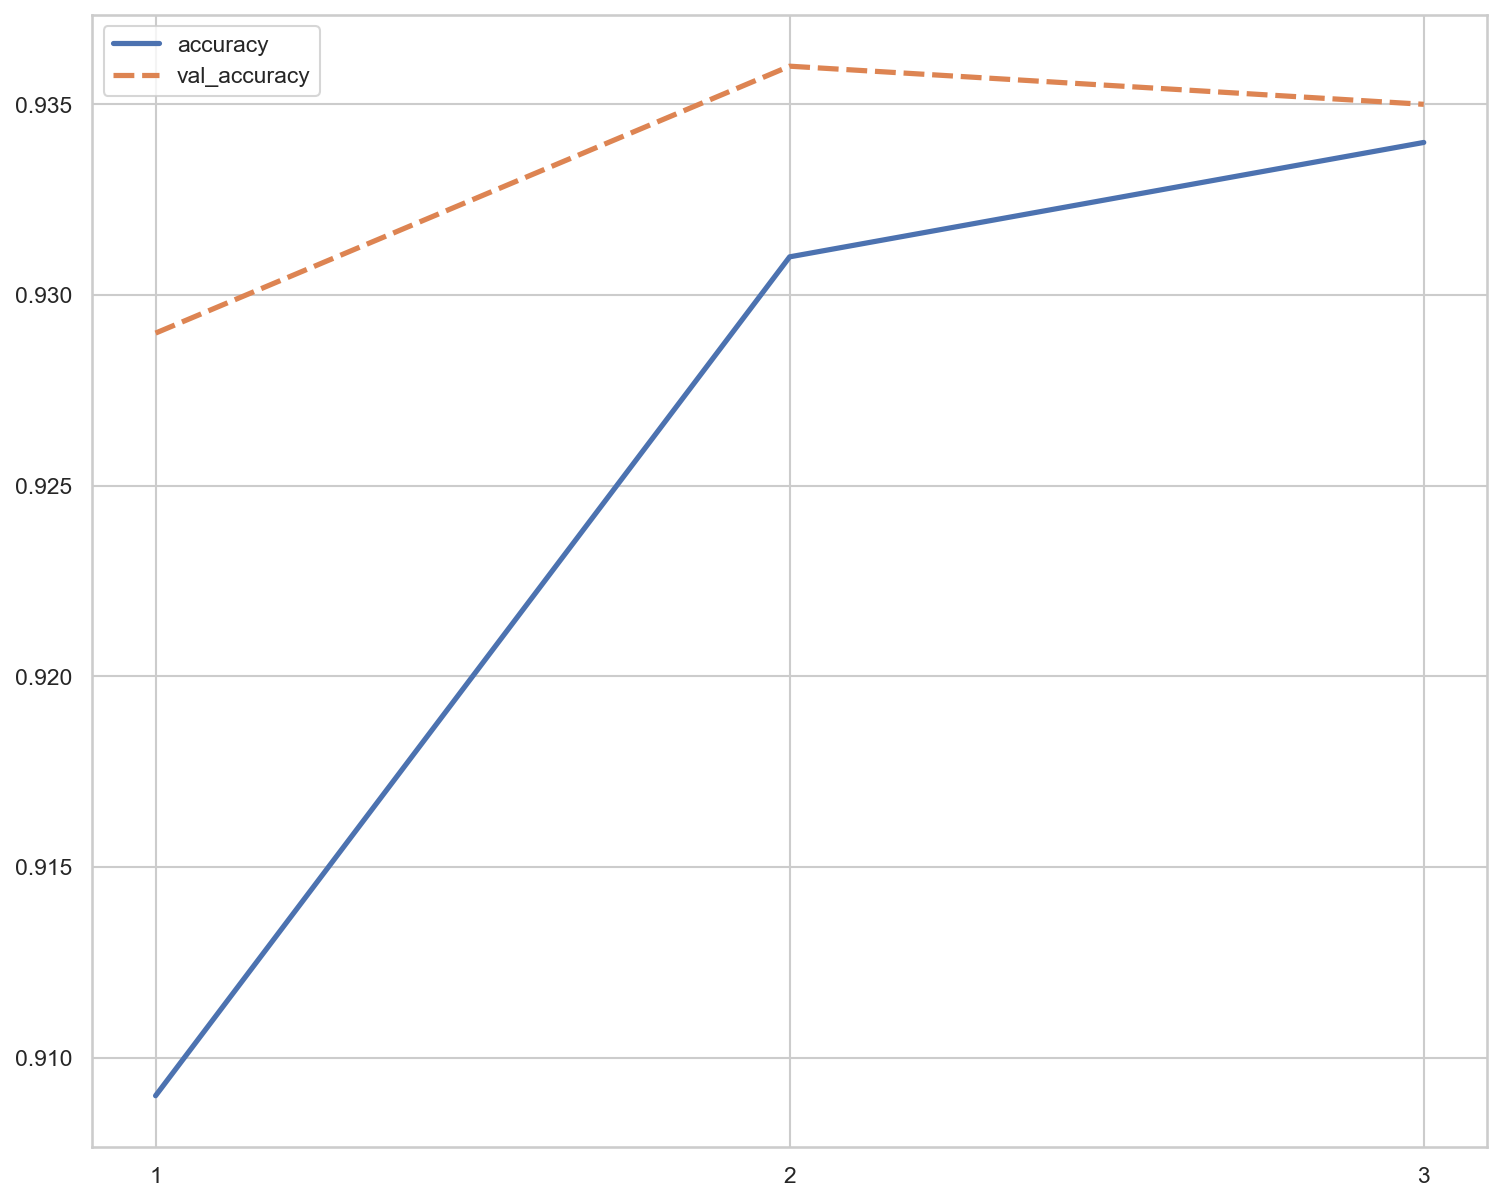

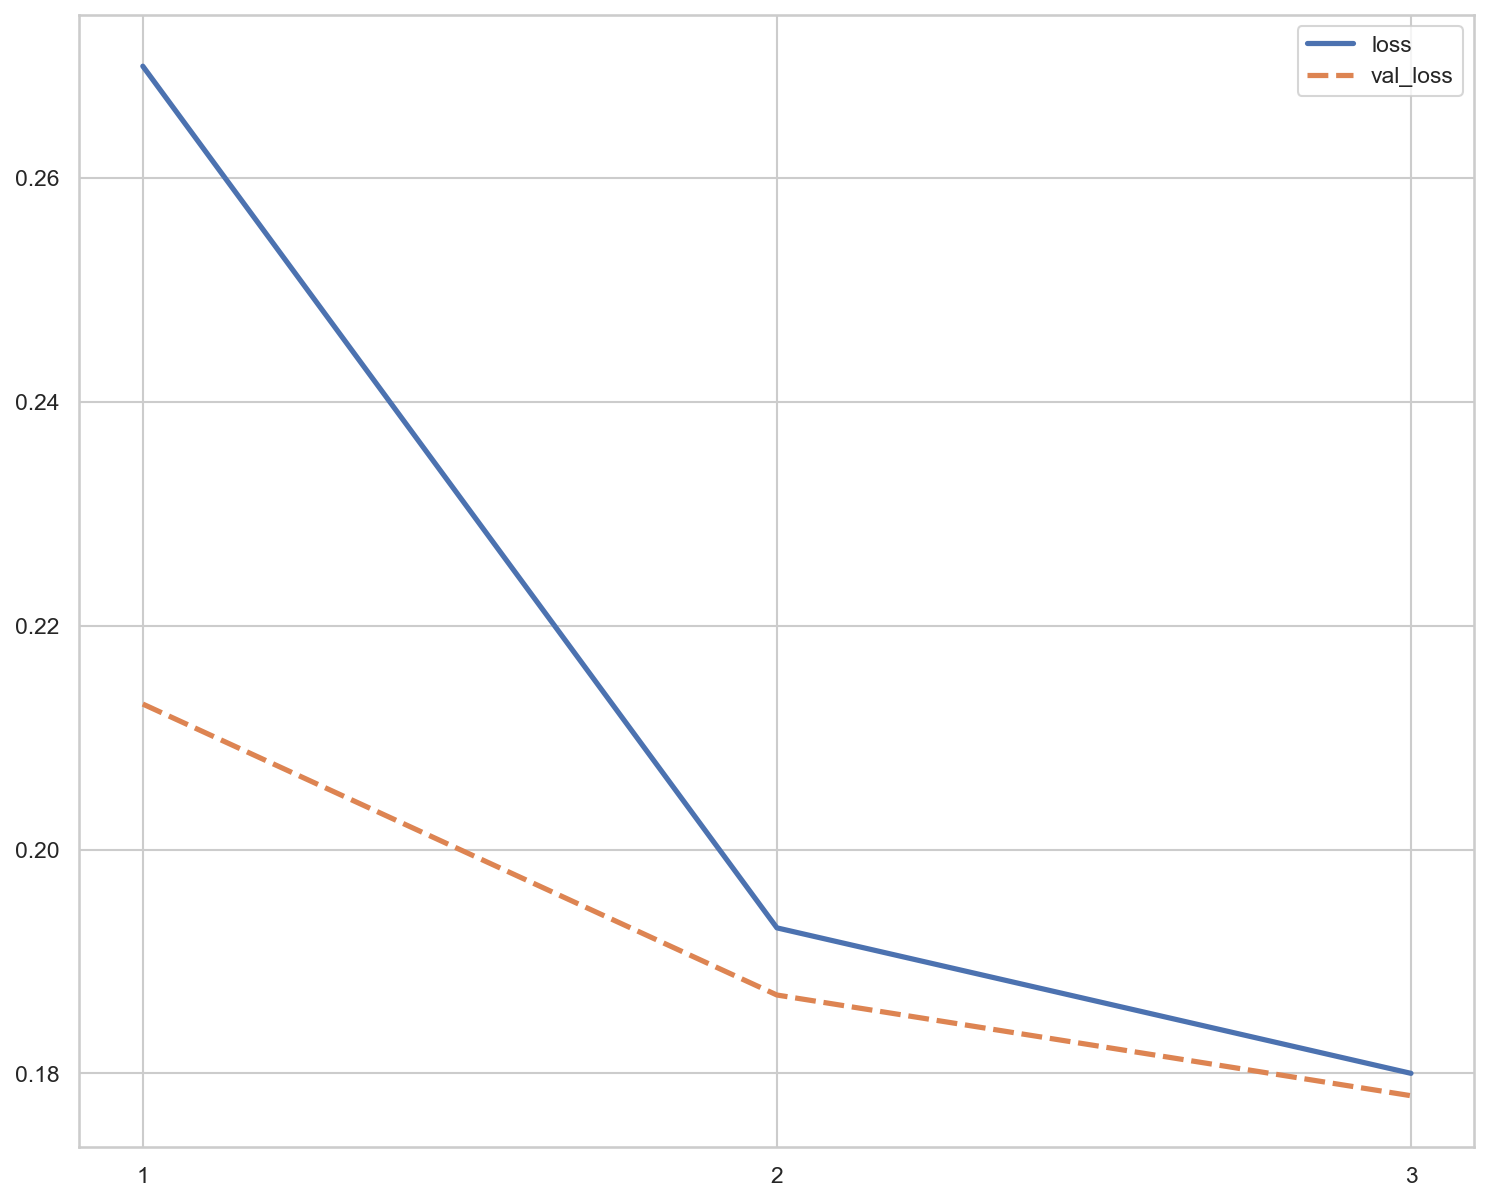

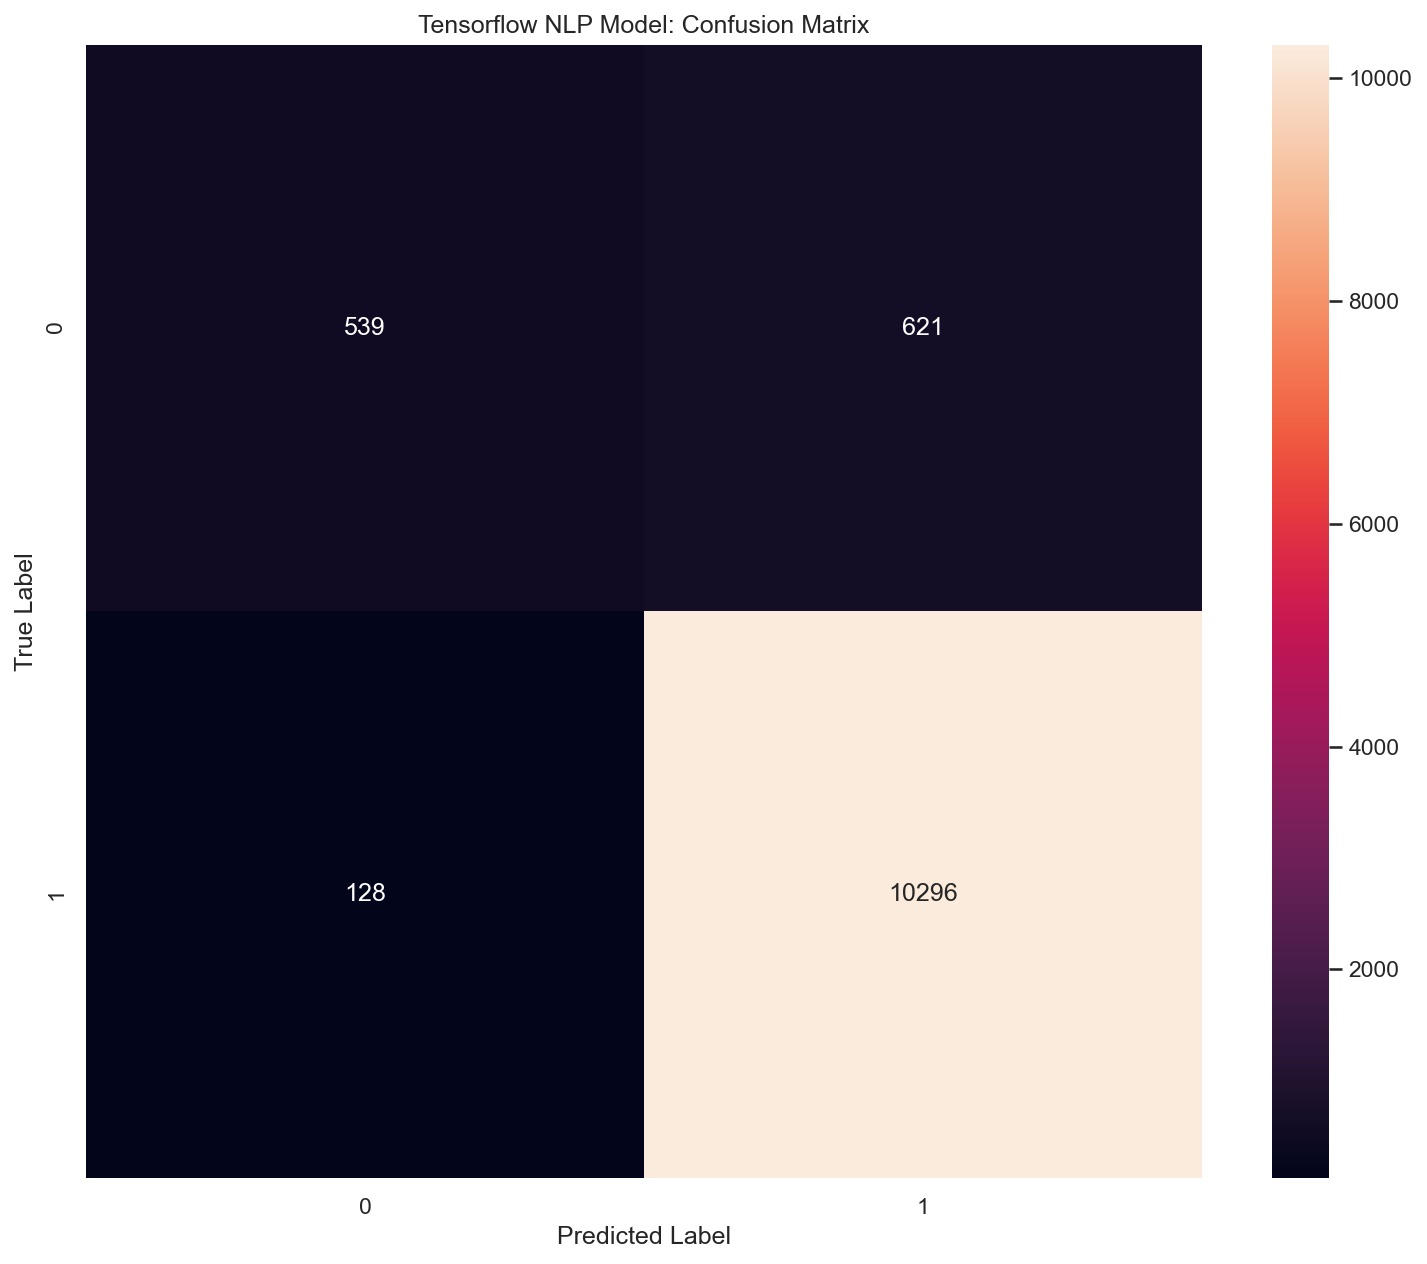

In [312]:
def create_network_1():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        min_delta=0,
        patience=2,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=False,
    )
    
    model = Sequential()

    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=max_sequence_embedding,
        input_length=len(X_train[0]),
    )

    model.add(embedding_layer)

    model.add(SpatialDropout1D(rate=0.5))

    model.add(LSTM(units=60, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(rate=0.20))

    model.add(Flatten())
    model.add(Dense(units=1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    model.summary()
    
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        callbacks=[callback],
        validation_split=0.2,
        validation_data=(X_test, y_test),
        verbose=2,
    )    
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy

    model.save("model_1.keras")

    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    
    create_conf_matrix(y_test, predictions)

    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    num_epochs = len(history.history.get("loss", []))
    num_epochs
    plot_scores(
        history=history,
        model=model,
        num_epochs=range(1, num_epochs + 1),
        ticks=range(0, num_epochs),
    )

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax=ax)
    ax.set_title("Tensorflow NLP Model: Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()    

create_network_1()


Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_80 (Embedding)    (None, 77, 18)            2044782   
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 100)               11900     
                                                                 
 activation_97 (Activation)  (None, 100)               0         
                                                                 
 batch_normalization_119 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 dropout_63 (Dropout)        (None, 100)               0         
                                                                 
 dense_129 (Dense)           (None, 30)                3030      
                                                     

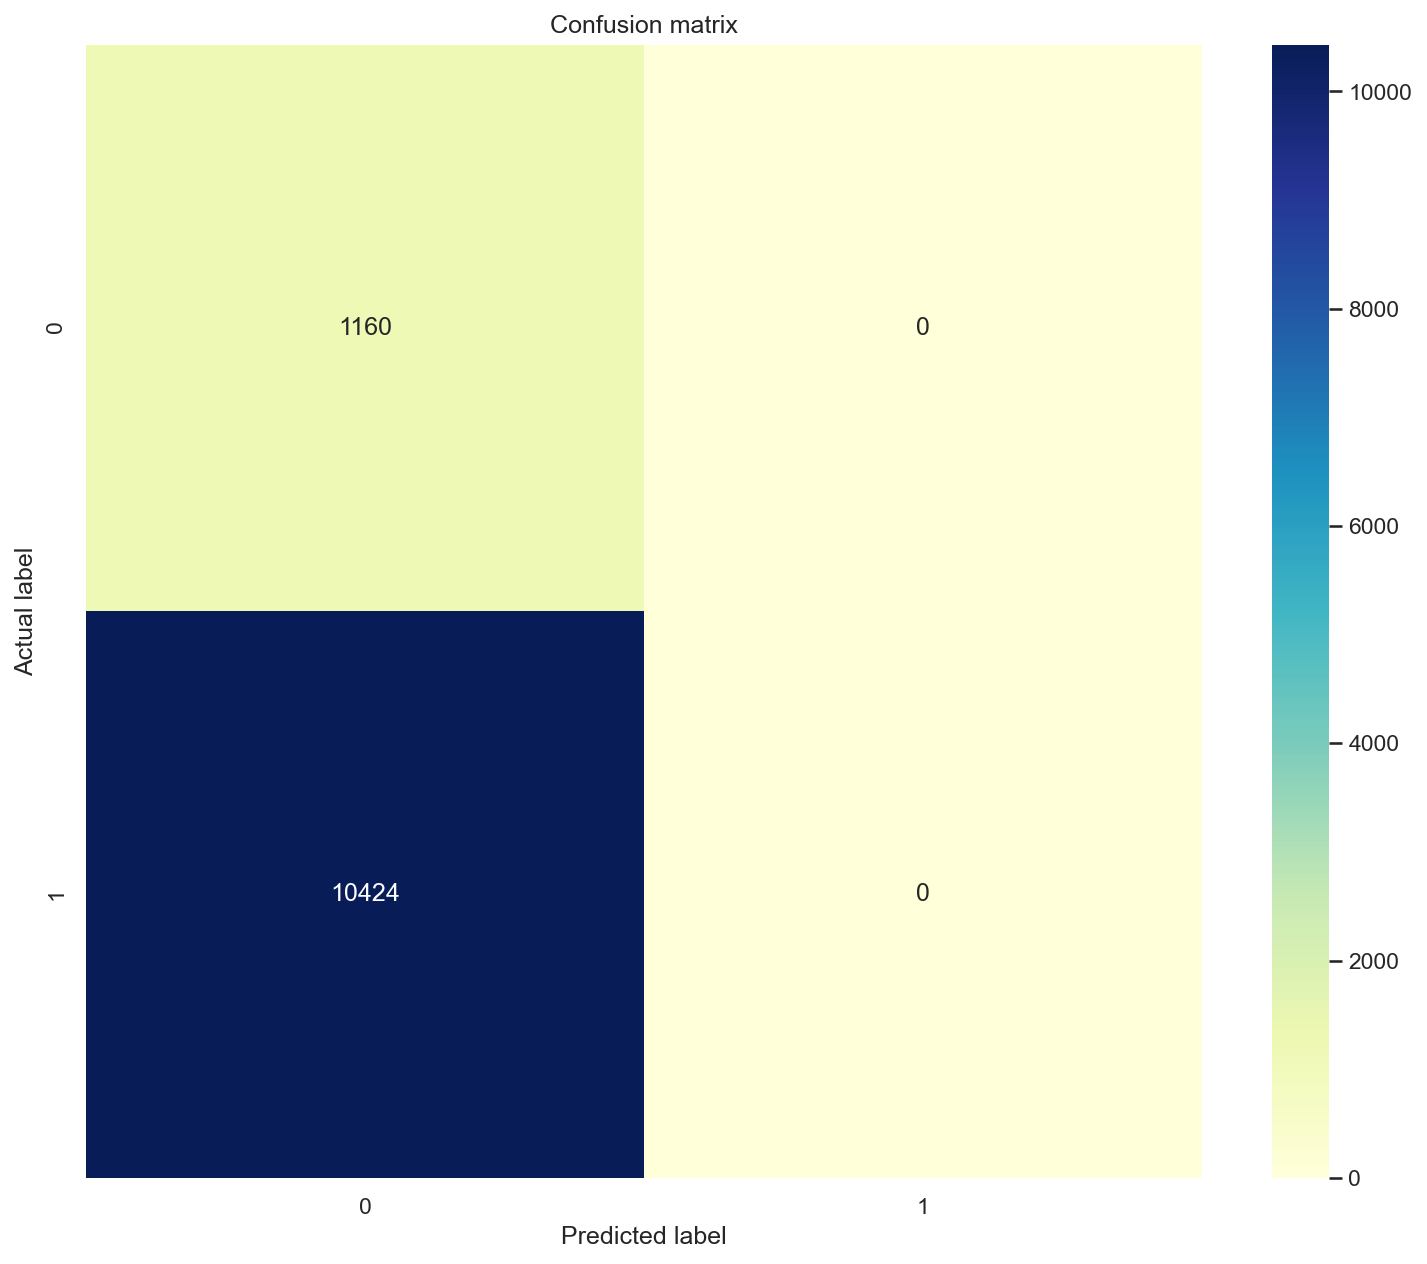

,loss,accuracy,val_loss,val_accuracy
0,0.47,0.81,0.33,0.93
1,0.26,0.93,0.96,0.45
2,0.20,0.93,7.00,0.10


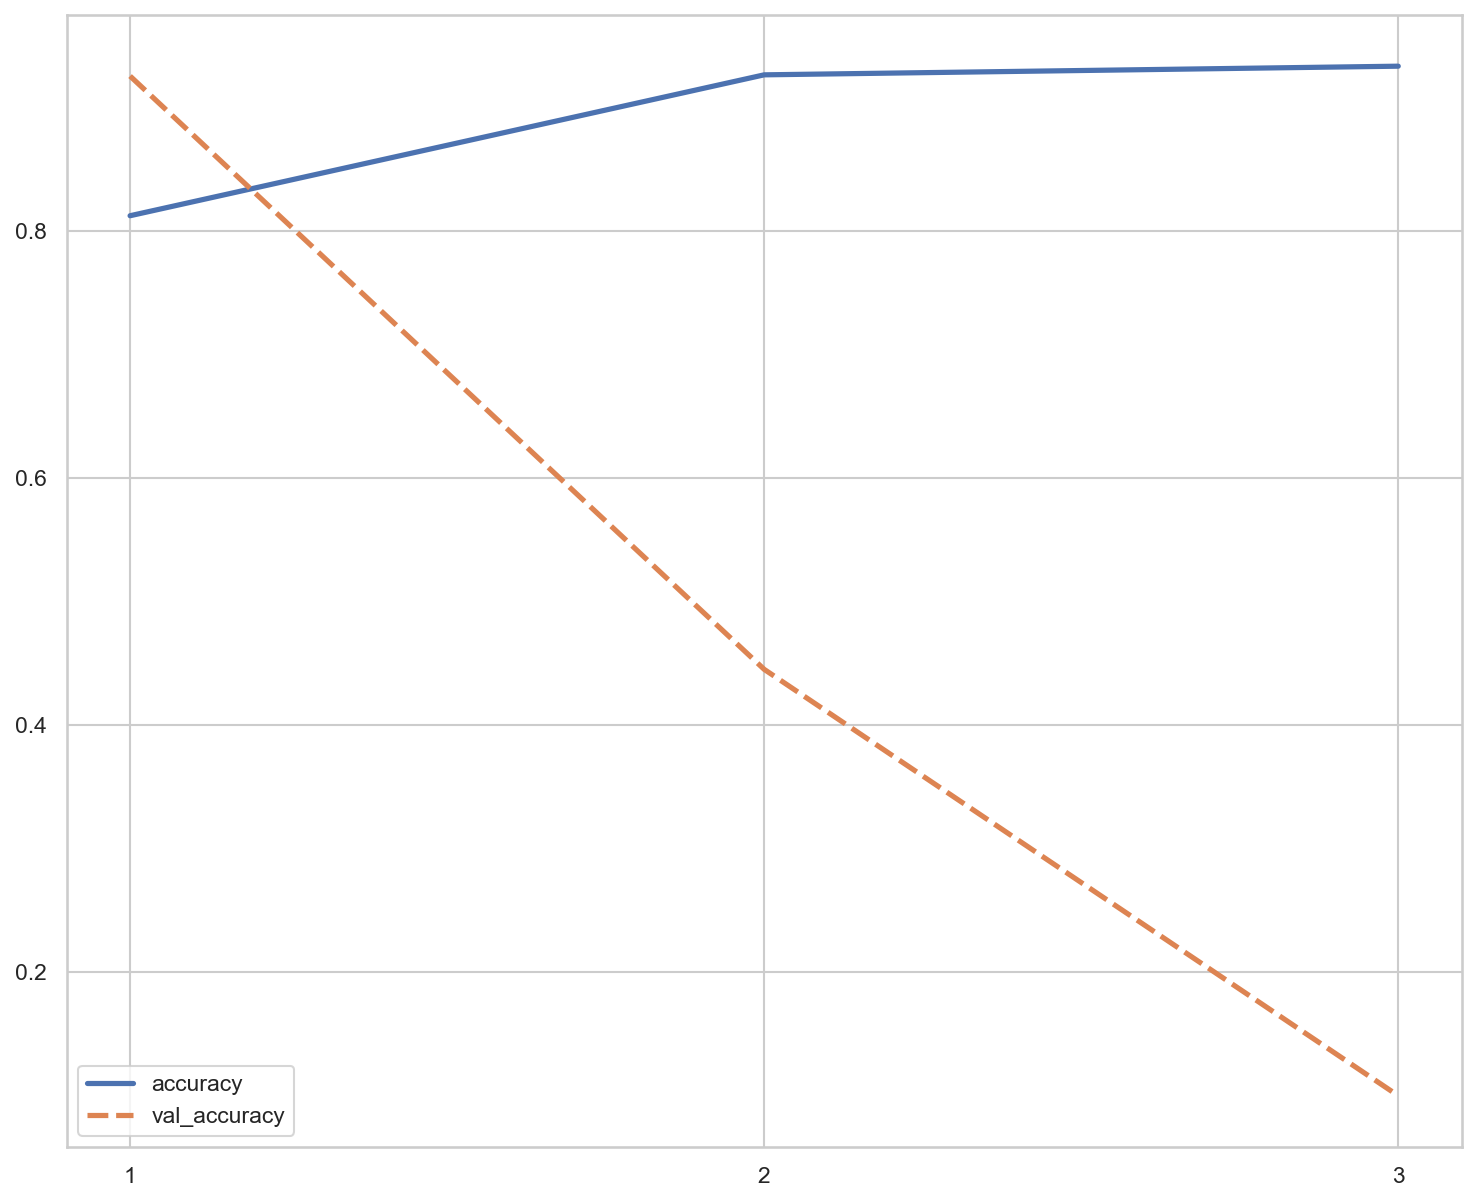

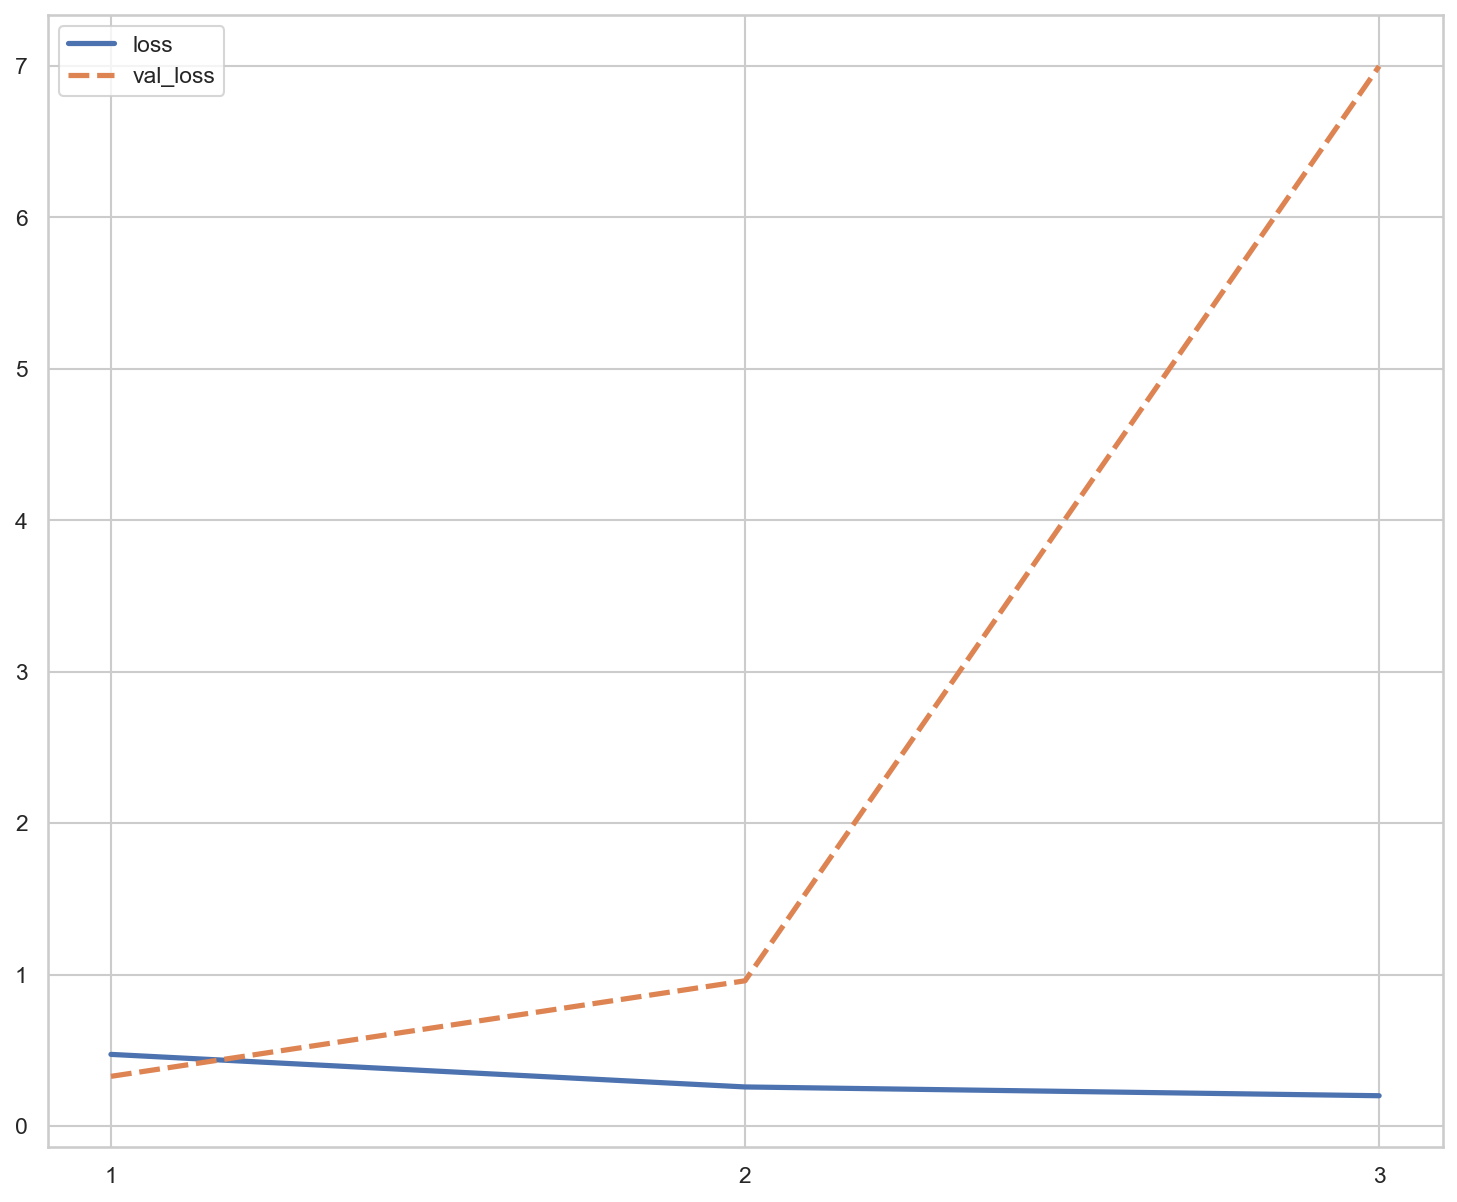

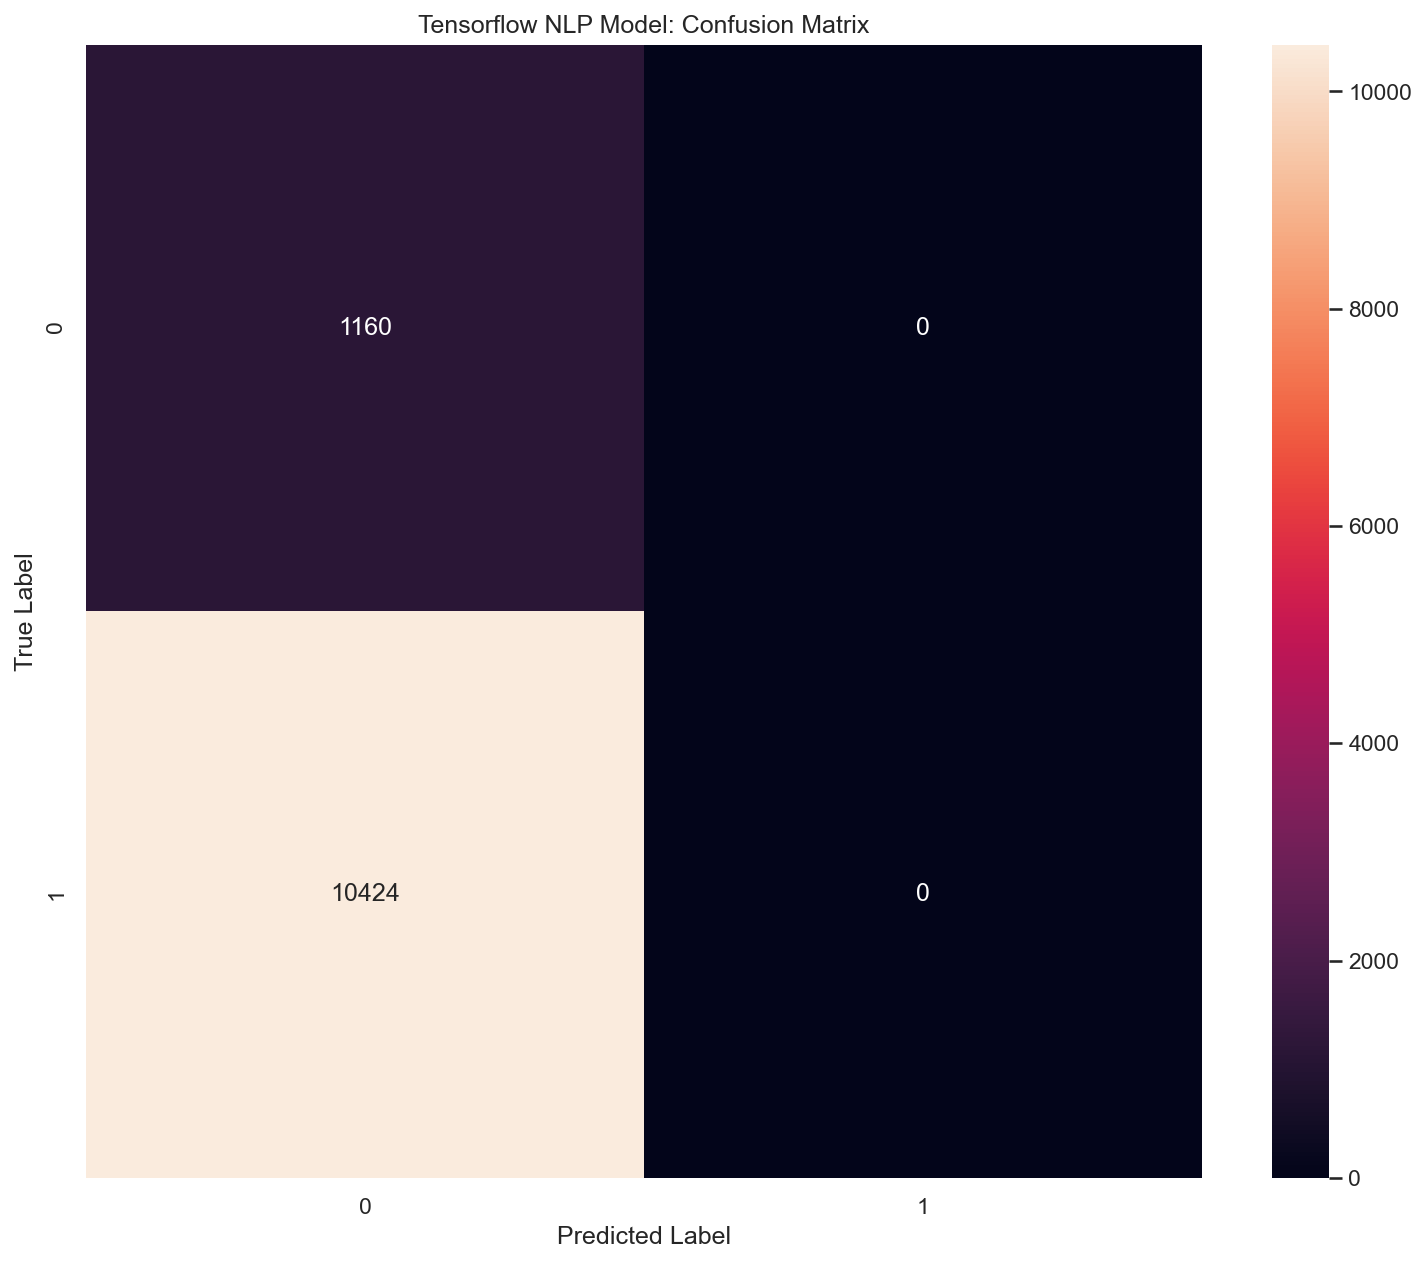

In [315]:
def create_network_2():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        min_delta=0,
        patience=2,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=False,
    )
    
    model = Sequential()

    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=max_sequence_embedding,
        input_length=len(X_train[0]),
    )

    # input
    model.add(embedding_layer)    
    
    # hidden 1
    model.add(keras.layers.SimpleRNN(units=100, activation="relu", use_bias=True))

    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # hidden 2
    model.add(keras.layers.Dense(30))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # output
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation("sigmoid"))

    model.compile(
        optimizer="adam",
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")]
    )

    model.summary()
    
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        callbacks=[callback],
        validation_split=0.2,
        validation_data=(X_test, y_test),
        verbose=2,
    )    
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy

    model.save("model_2.keras")

    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    
    create_conf_matrix(y_test, predictions)

    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    num_epochs = len(history.history.get("loss", []))
    num_epochs
    plot_scores(
        history=history,
        model=model,
        num_epochs=range(1, num_epochs + 1),
        ticks=range(0, num_epochs),
    )

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax=ax)
    ax.set_title("Tensorflow NLP Model: Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()    

create_network_2()



Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_81 (Embedding)    (None, 77, 18)            2044782   
                                                                 
 lstm_58 (LSTM)              (None, 100)               47600     
                                                                 
 activation_100 (Activation)  (None, 100)              0         
                                                                 
 batch_normalization_122 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 dropout_65 (Dropout)        (None, 100)               0         
                                                                 
 dense_131 (Dense)           (None, 1)                 101       
                                                     

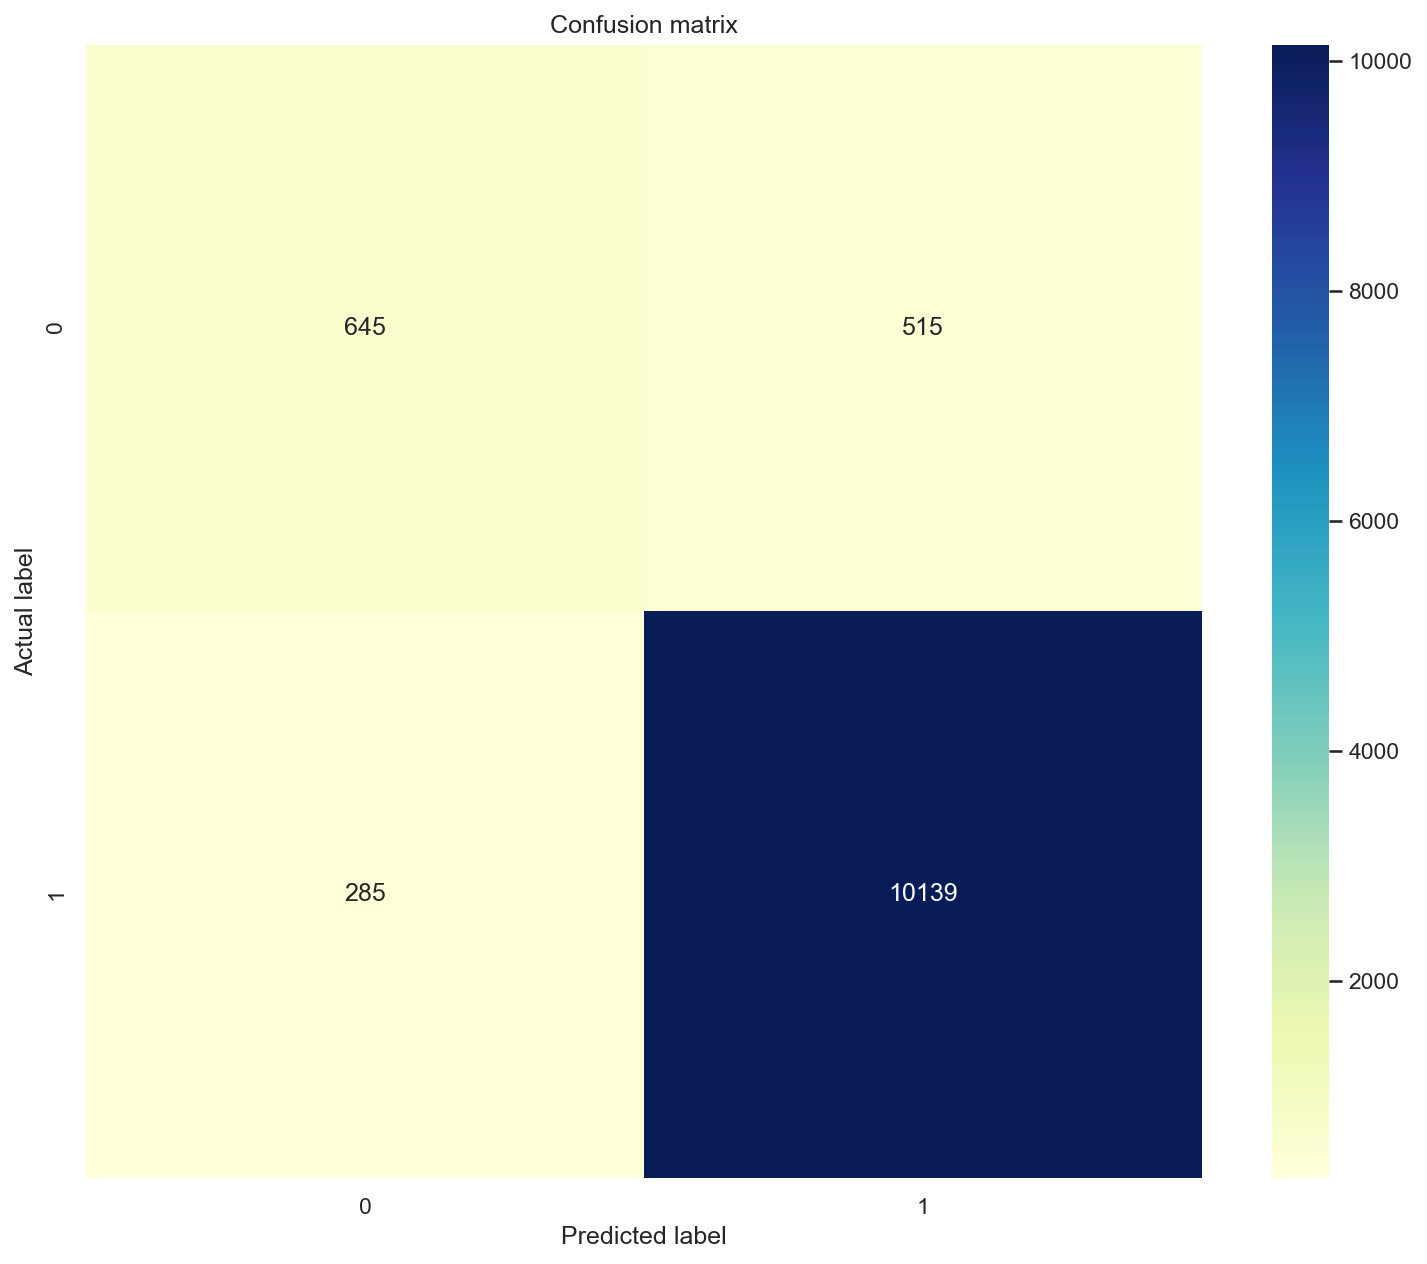

,loss,accuracy,val_loss,val_accuracy
0,0.46,0.84,0.27,0.93
1,0.25,0.94,0.21,0.93
2,0.18,0.94,0.20,0.93


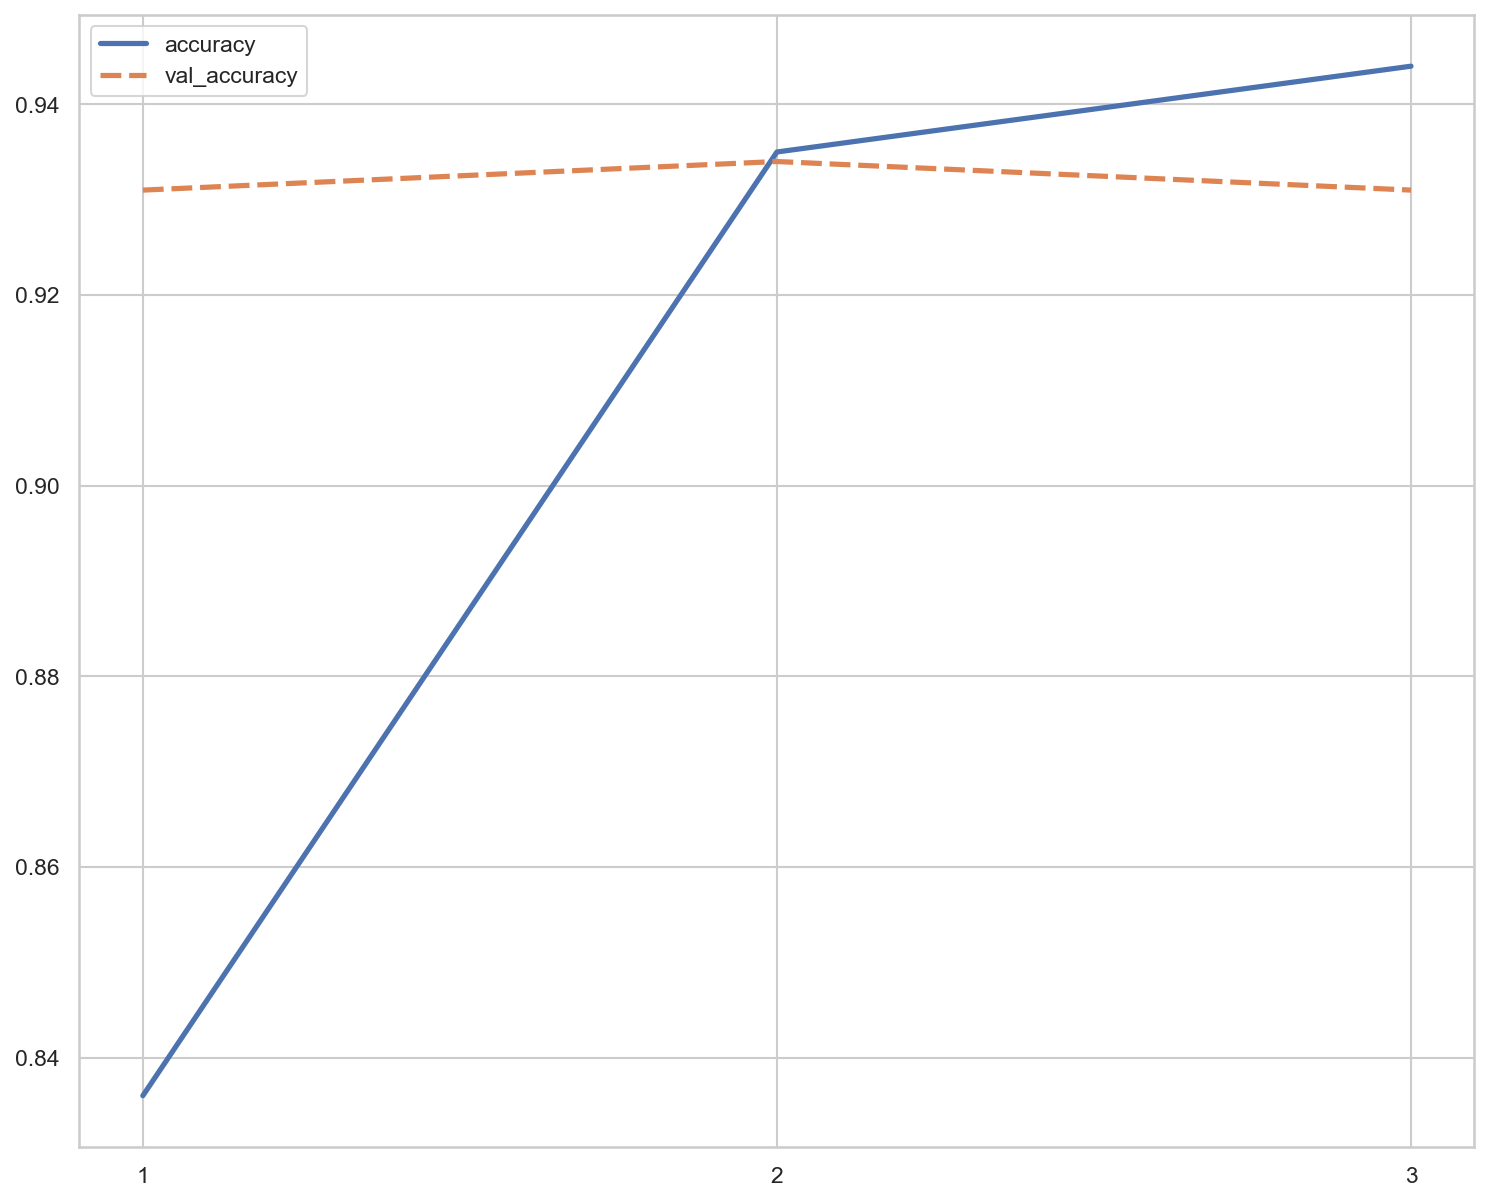

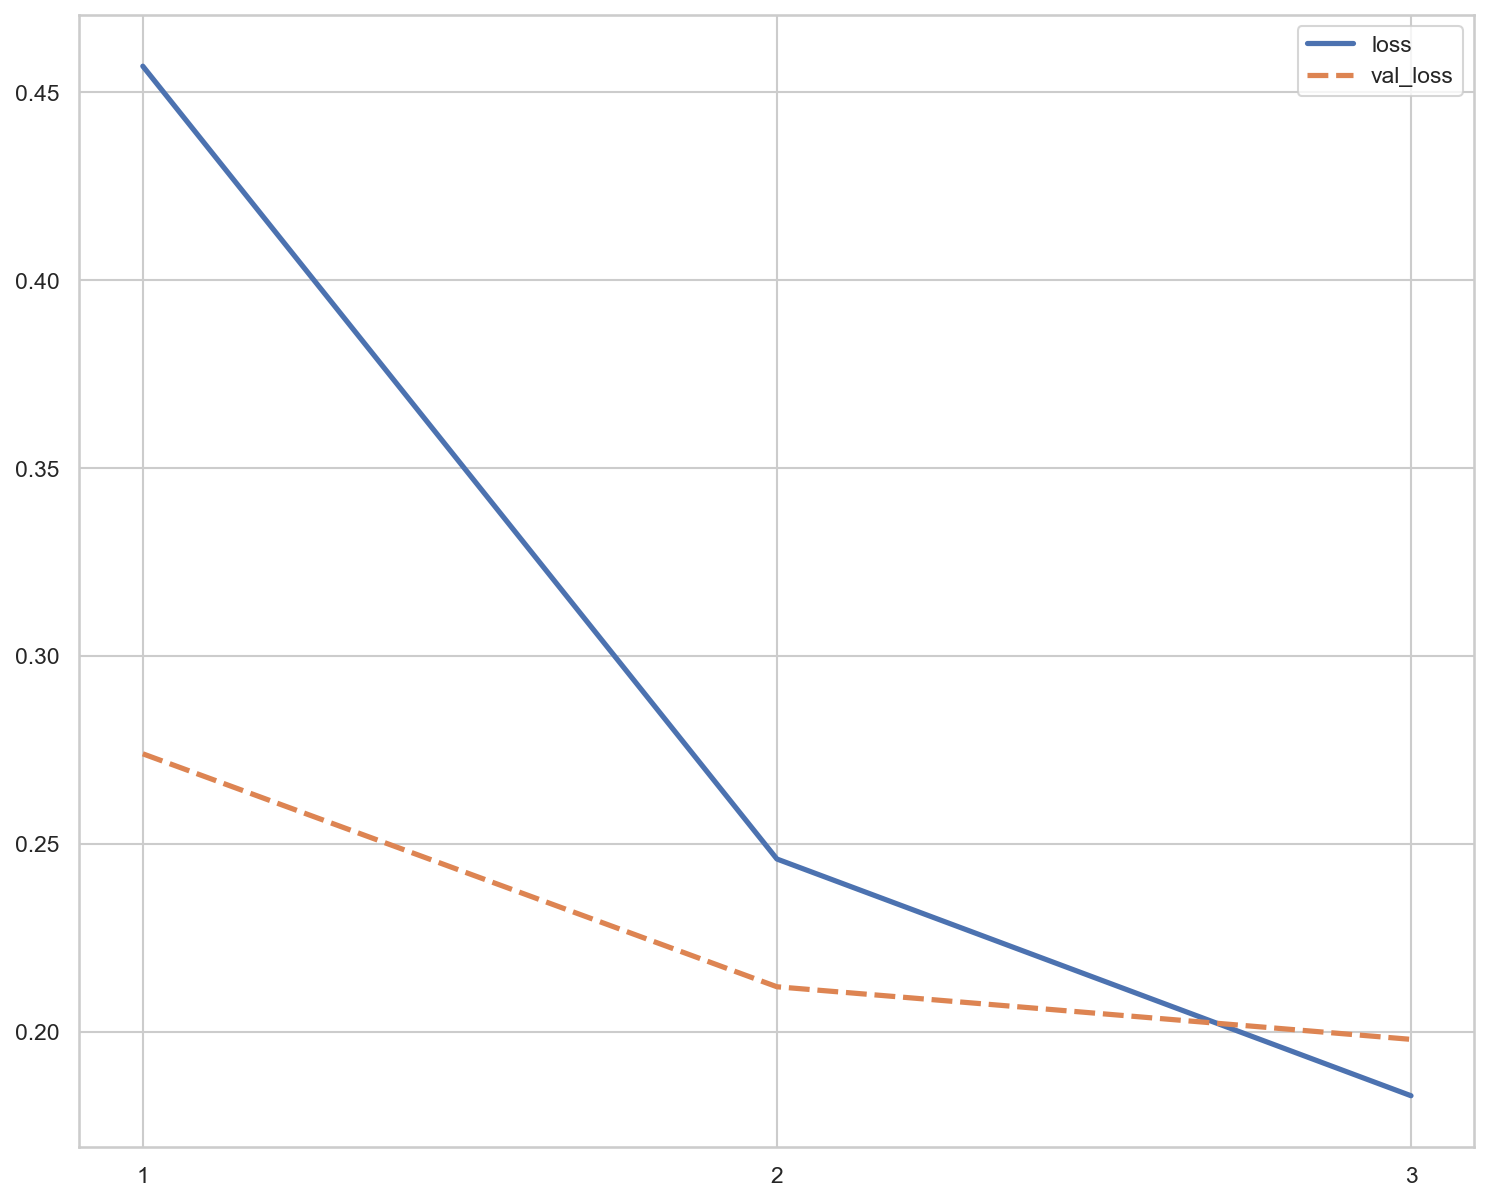

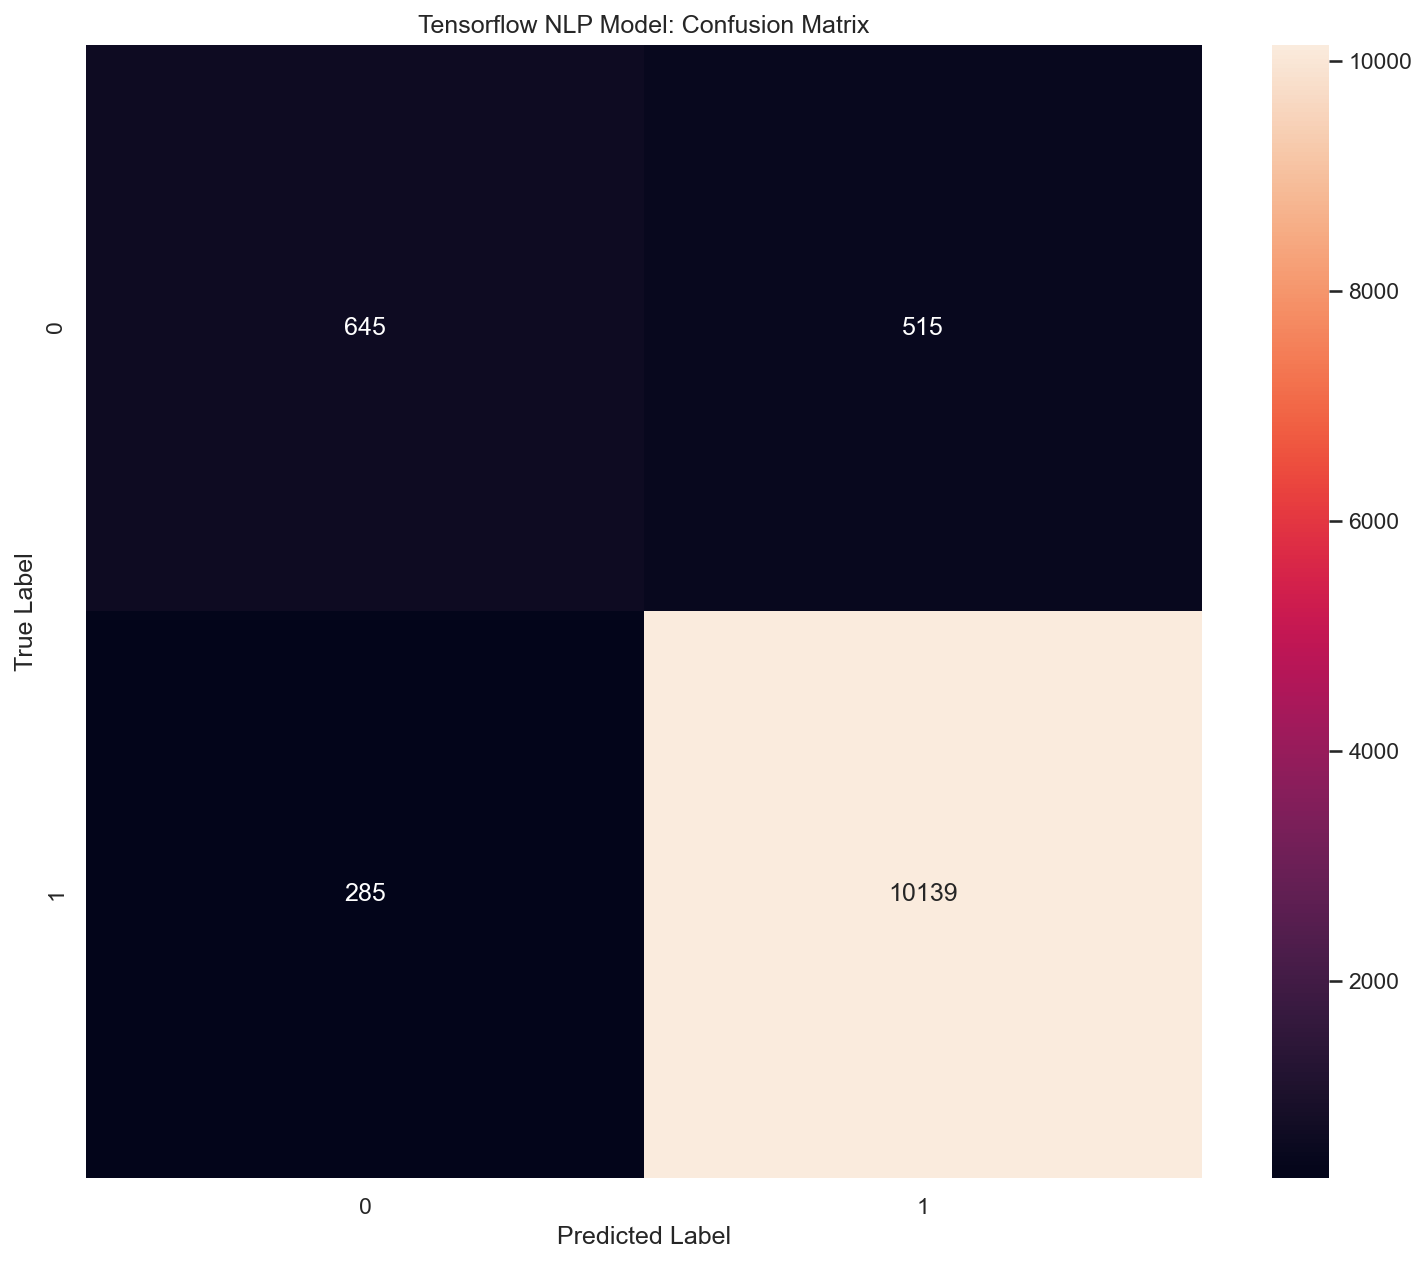

In [316]:
def create_network_3():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=2,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=False,
    )
    
    model = Sequential()

    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=max_sequence_embedding,
        input_length=len(X_train[0]),
    )

    # input
    model.add(embedding_layer)    
    
    # hidden 1
    model.add(LSTM(units=100, use_bias=True))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # output
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation("sigmoid"))

    model.compile(
        optimizer="adam",
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")]
    )

    model.summary()
    
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        callbacks=[callback],
        validation_split=0.2,
        validation_data=(X_test, y_test),
        verbose=2,
    )    
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy

    model.save("model_3.keras")

    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    
    create_conf_matrix(y_test, predictions)

    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    num_epochs = len(history.history.get("loss", []))
    num_epochs
    plot_scores(
        history=history,
        model=model,
        num_epochs=range(1, num_epochs + 1),
        ticks=range(0, num_epochs),
    )

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax=ax)
    ax.set_title("Tensorflow NLP Model: Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()    

create_network_3()


Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_82 (Embedding)    (None, 77, 18)            2044782   
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 100)               11900     
                                                                 
 activation_102 (Activation)  (None, 100)              0         
                                                                 
 batch_normalization_124 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 dropout_66 (Dropout)        (None, 100)               0         
                                                                 
 dense_132 (Dense)           (None, 1)                 101       
                                                     

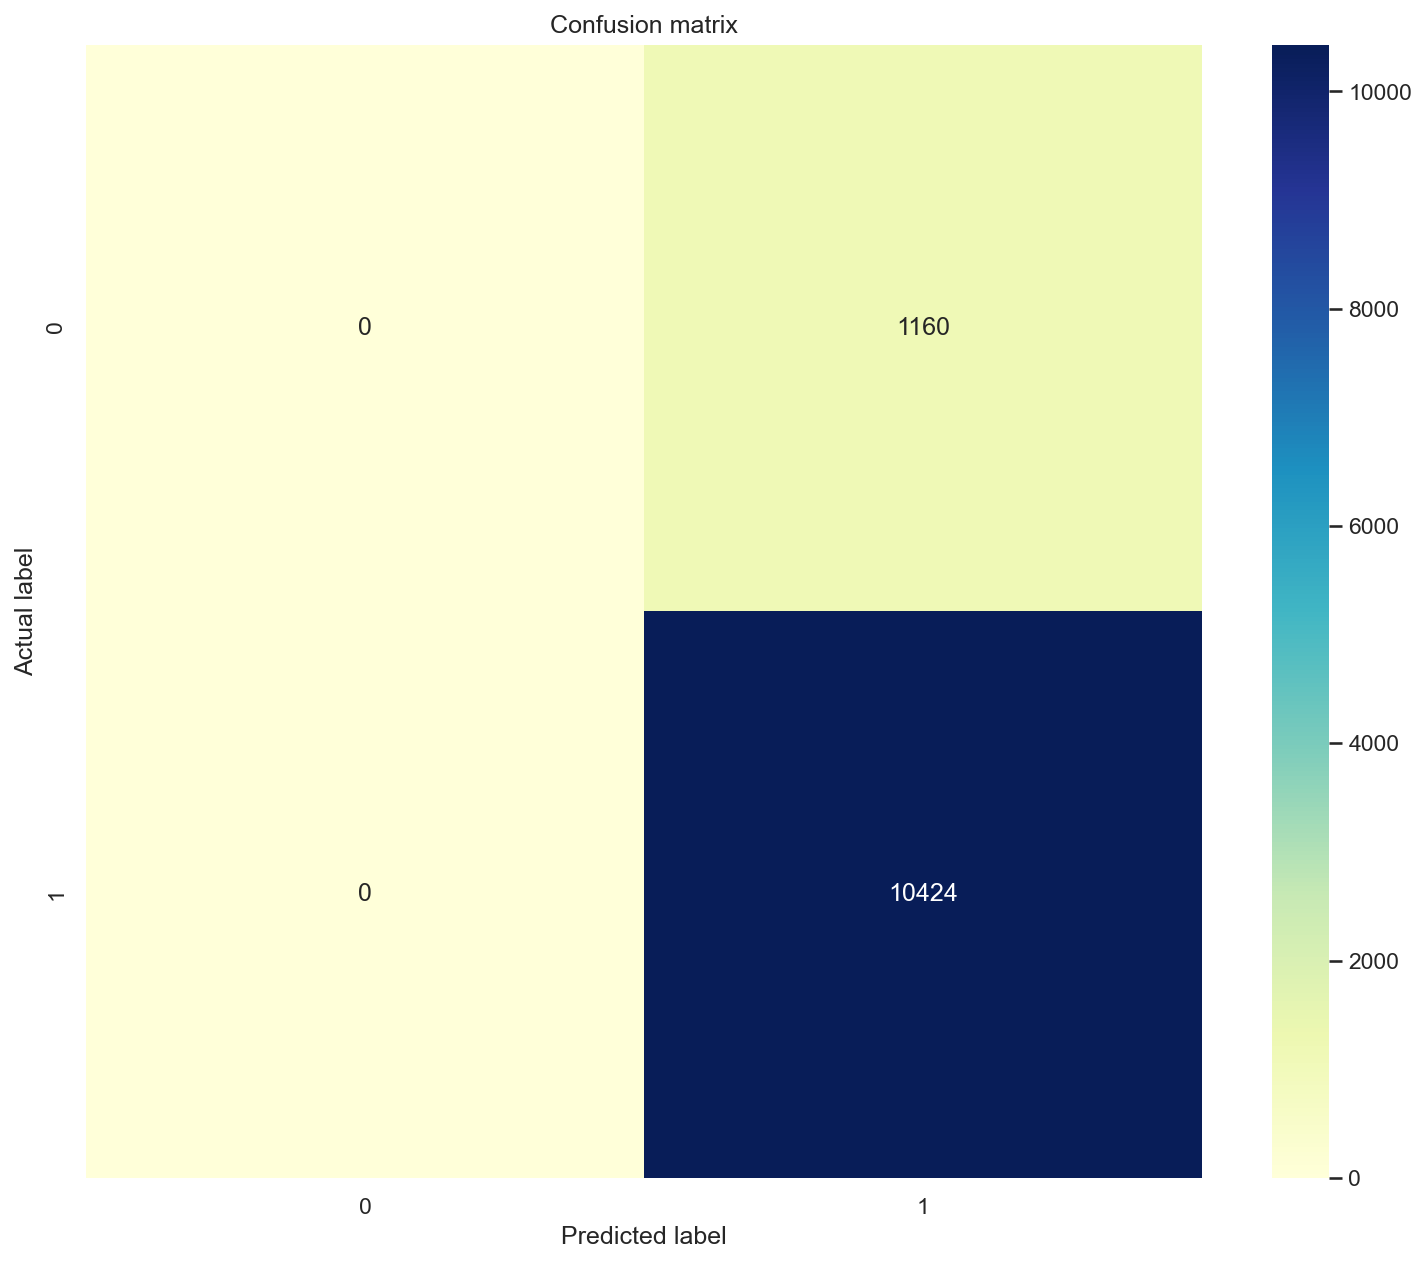

,loss,accuracy,val_loss,val_accuracy
0,0.52,0.79,3.27,0.11
1,0.33,0.90,13.27,0.10
2,0.28,0.90,0.32,0.90


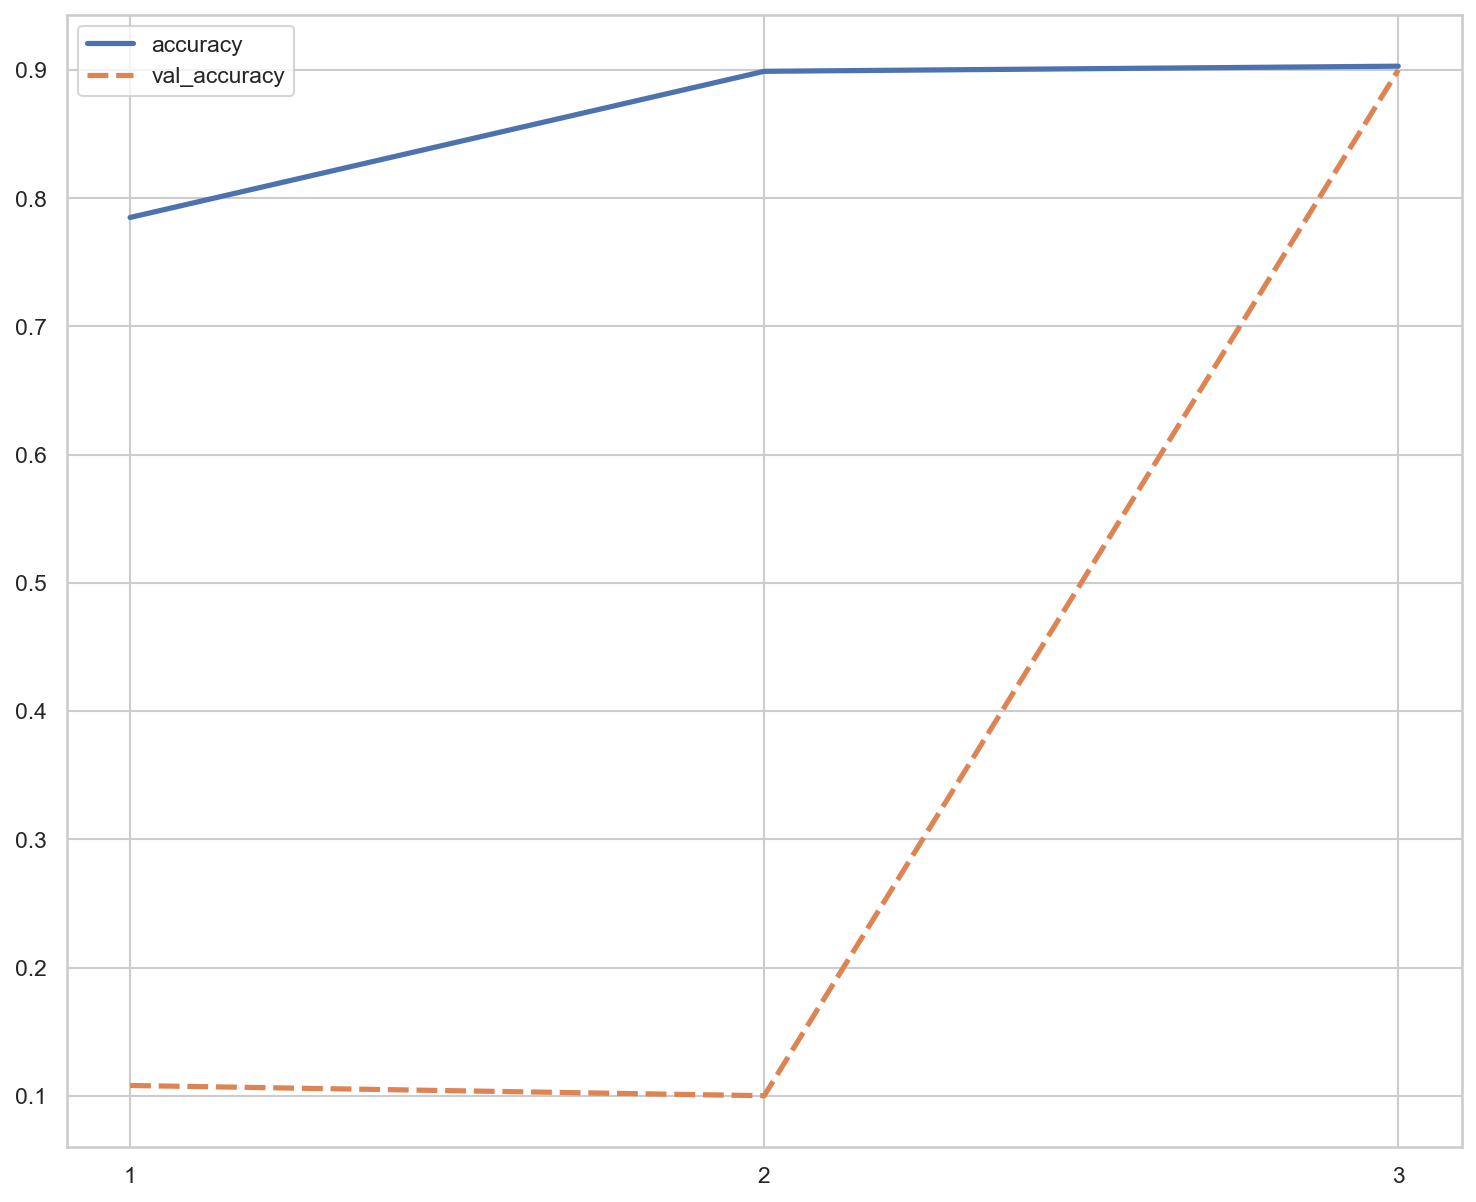

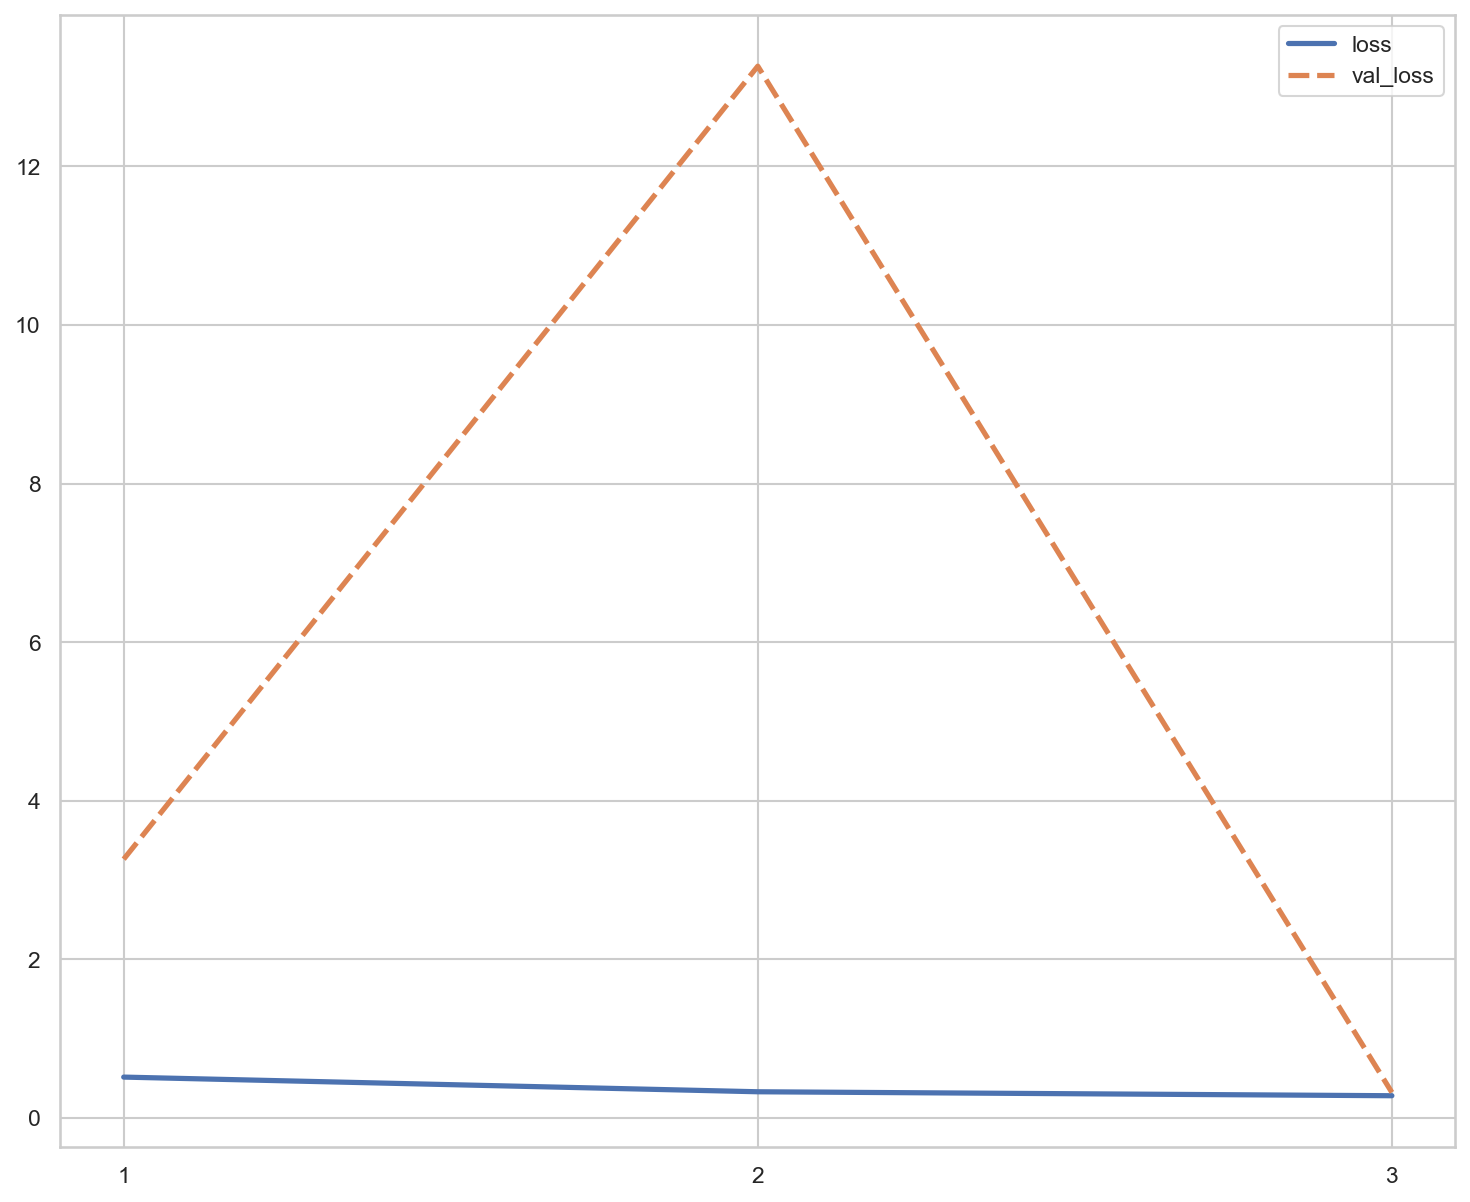

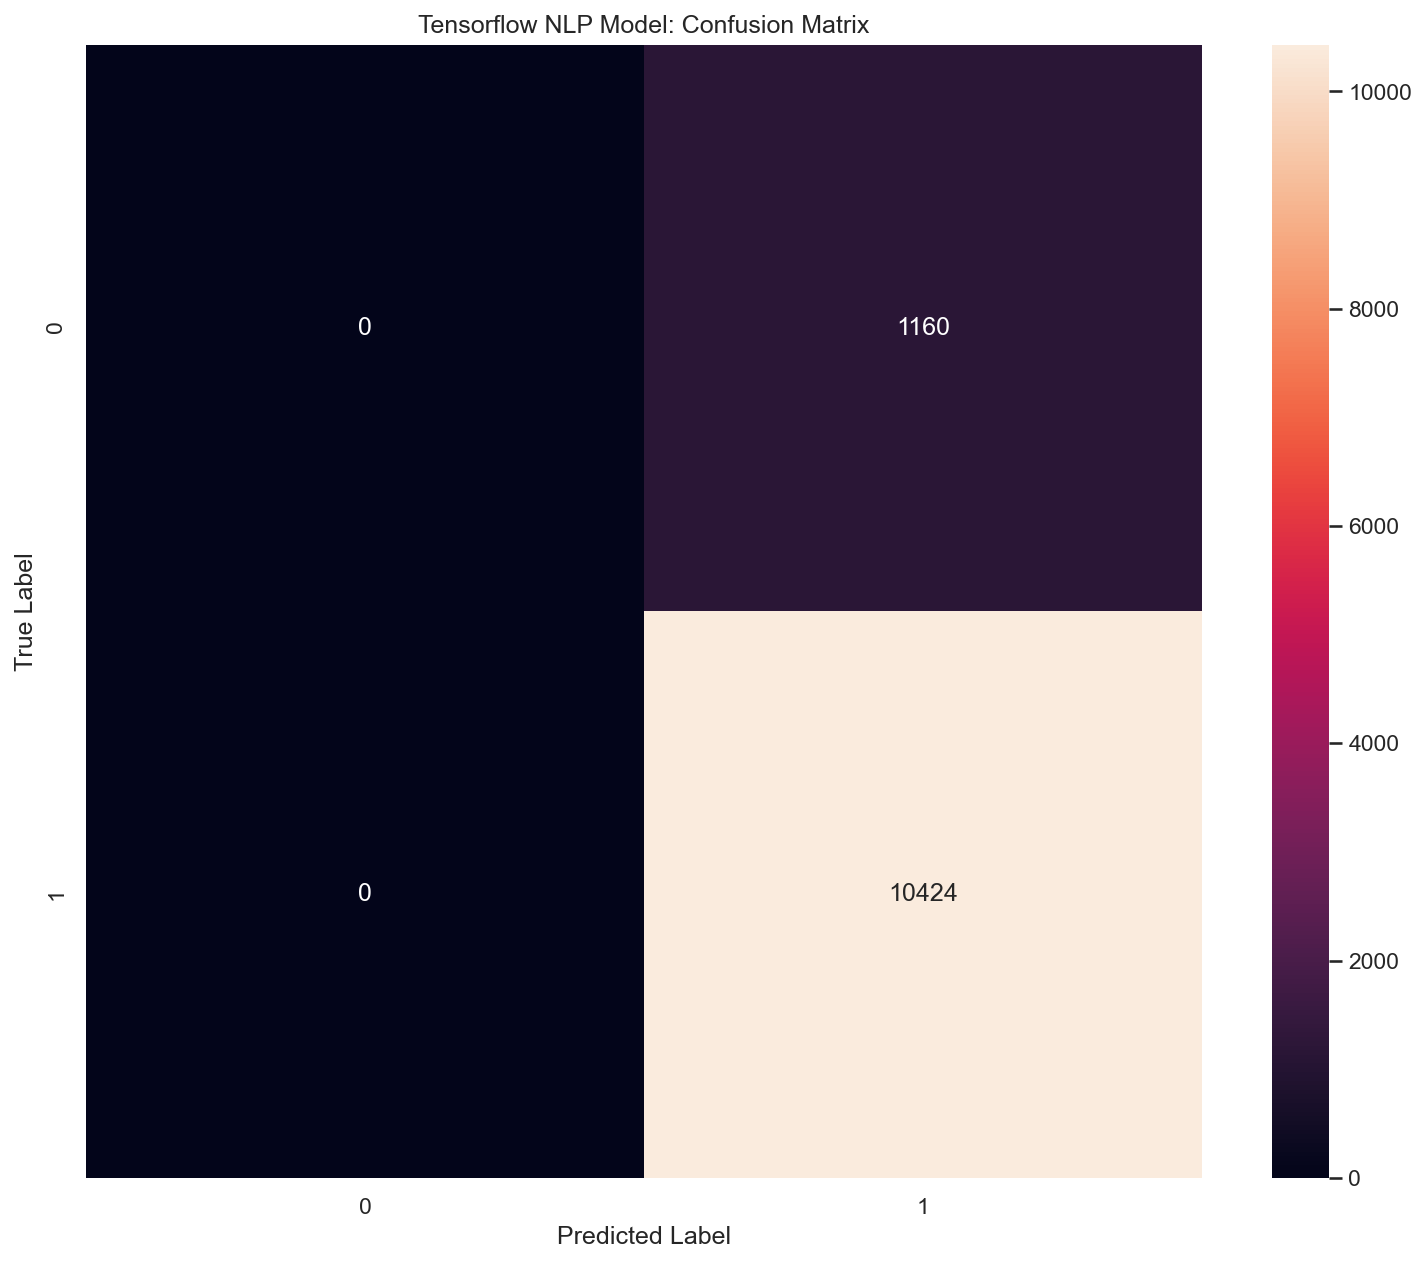

In [317]:
def create_network_4():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=2,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=False,
    )
    
    model = Sequential()

    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=max_sequence_embedding,
        input_length=len(X_train[0]),
    )

    # input
    model.add(embedding_layer)    
    
    # hidden 1
    model.add(keras.layers.SimpleRNN(units=100, use_bias=True))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # output
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation("sigmoid"))

    model.compile(
        optimizer="adam",
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")]
    )

    model.summary()
    
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        callbacks=[callback],
        validation_split=0.2,
        validation_data=(X_test, y_test),
        verbose=2,
    )    
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy

    model.save("model_4.keras")

    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    
    create_conf_matrix(y_test, predictions)

    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    num_epochs = len(history.history.get("loss", []))
    num_epochs
    plot_scores(
        history=history,
        model=model,
        num_epochs=range(1, num_epochs + 1),
        ticks=range(0, num_epochs),
    )

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax=ax)
    ax.set_title("Tensorflow NLP Model: Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()    

create_network_4()


### FINAL MODEL

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_83 (Embedding)    (None, 77, 18)            2044782   
                                                                 
 lstm_59 (LSTM)              (None, 60)                18960     
                                                                 
 activation_104 (Activation)  (None, 60)               0         
                                                                 
 batch_normalization_126 (Ba  (None, 60)               240       
 tchNormalization)                                               
                                                                 
 dropout_67 (Dropout)        (None, 60)                0         
                                                                 
 dense_133 (Dense)           (None, 30)                1830      
                                                     

,loss,accuracy,val_loss,val_accuracy
0,0.46,0.85,0.34,0.91
1,0.25,0.93,0.26,0.92
2,0.19,0.94,0.21,0.93
3,0.16,0.94,0.24,0.90
4,0.14,0.95,0.20,0.93
5,0.12,0.96,0.22,0.93
6,0.11,0.97,0.22,0.92


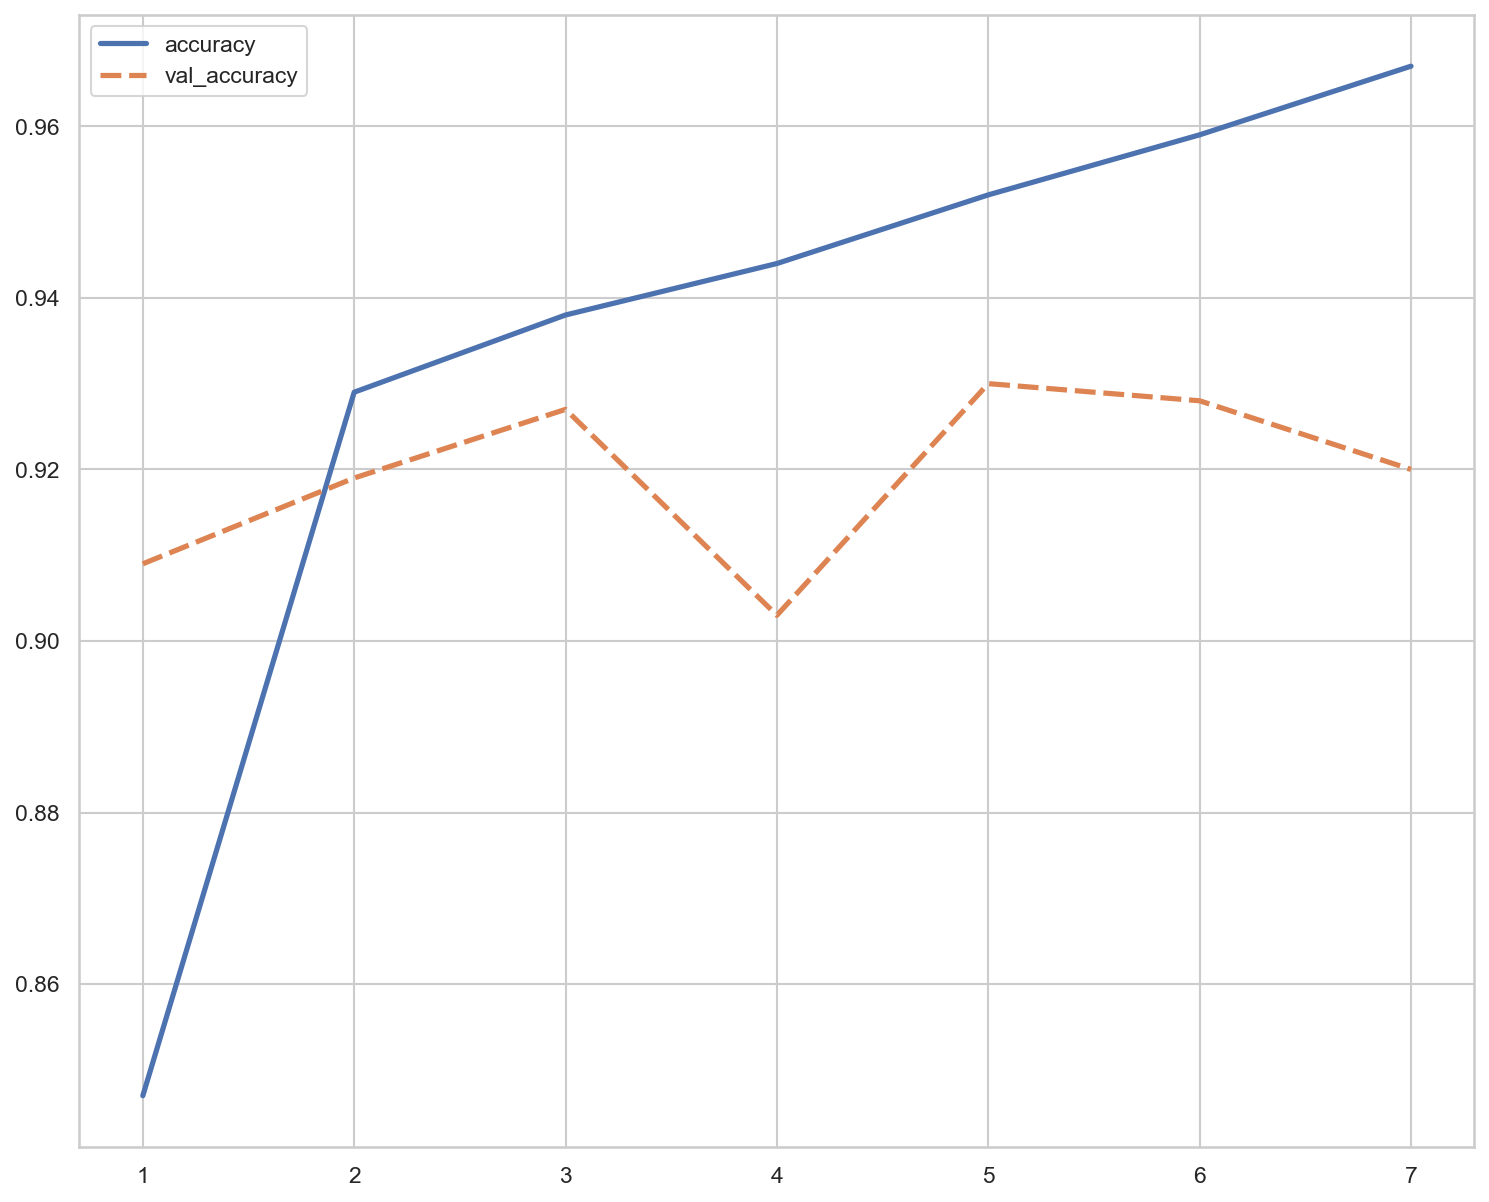

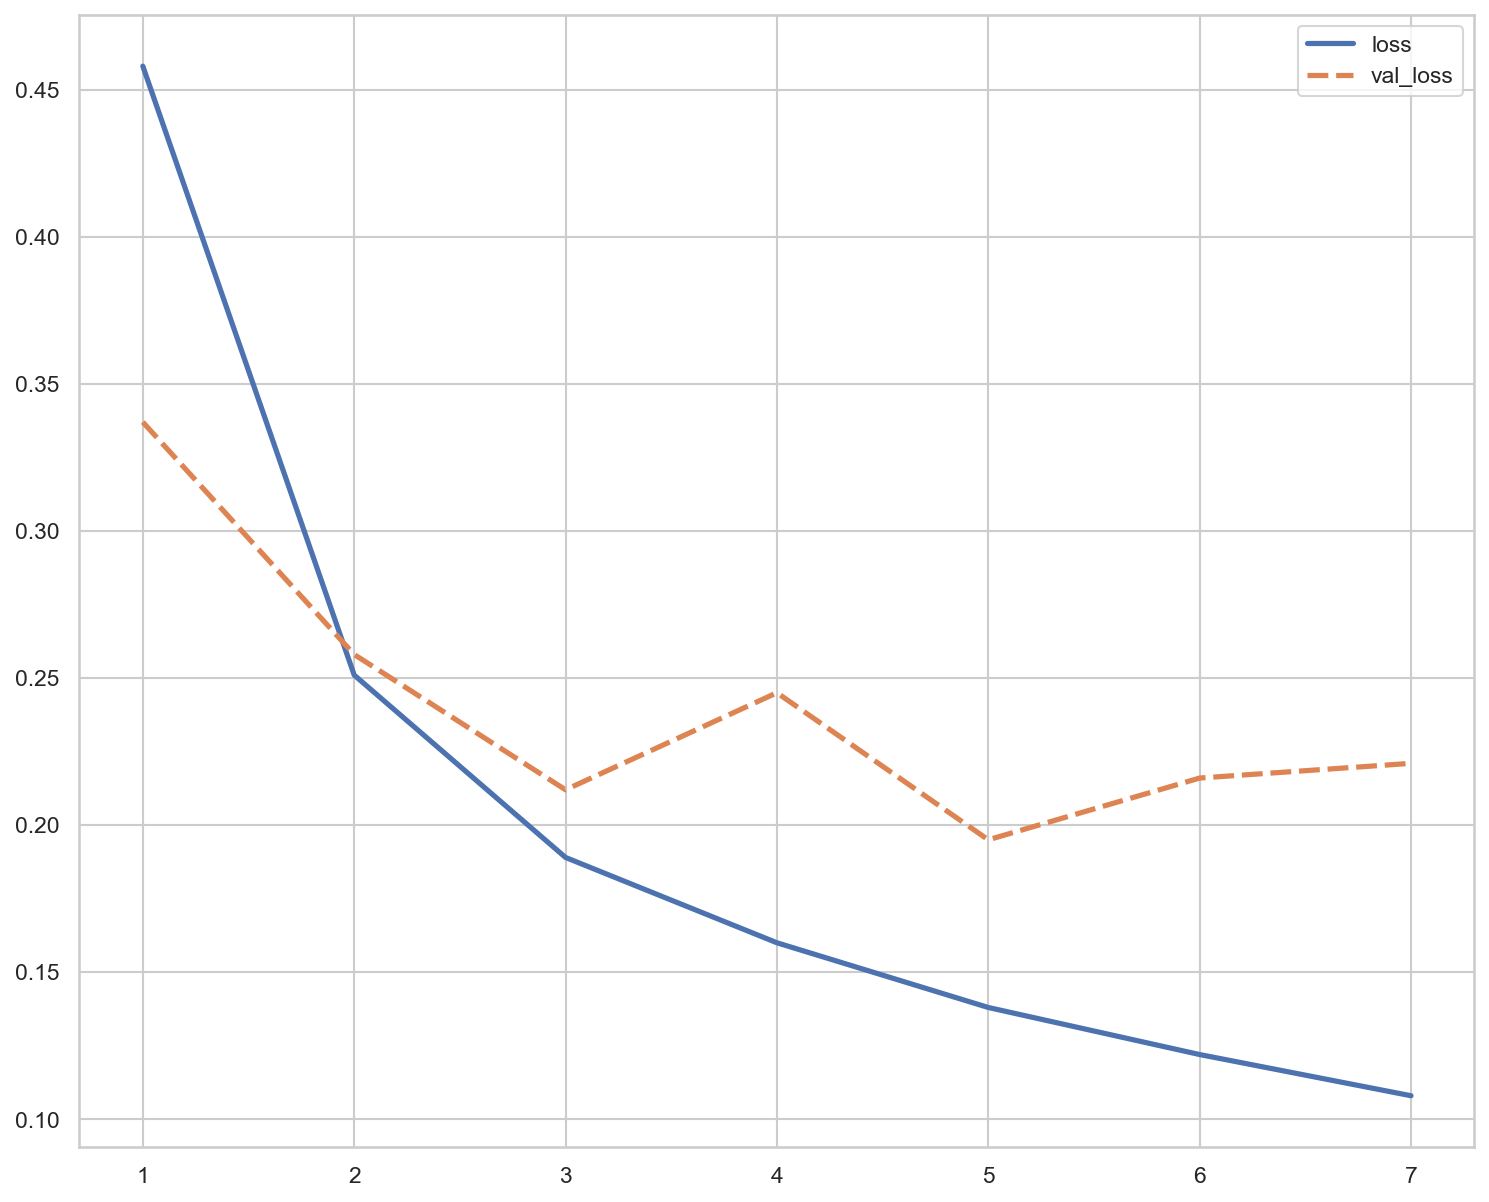

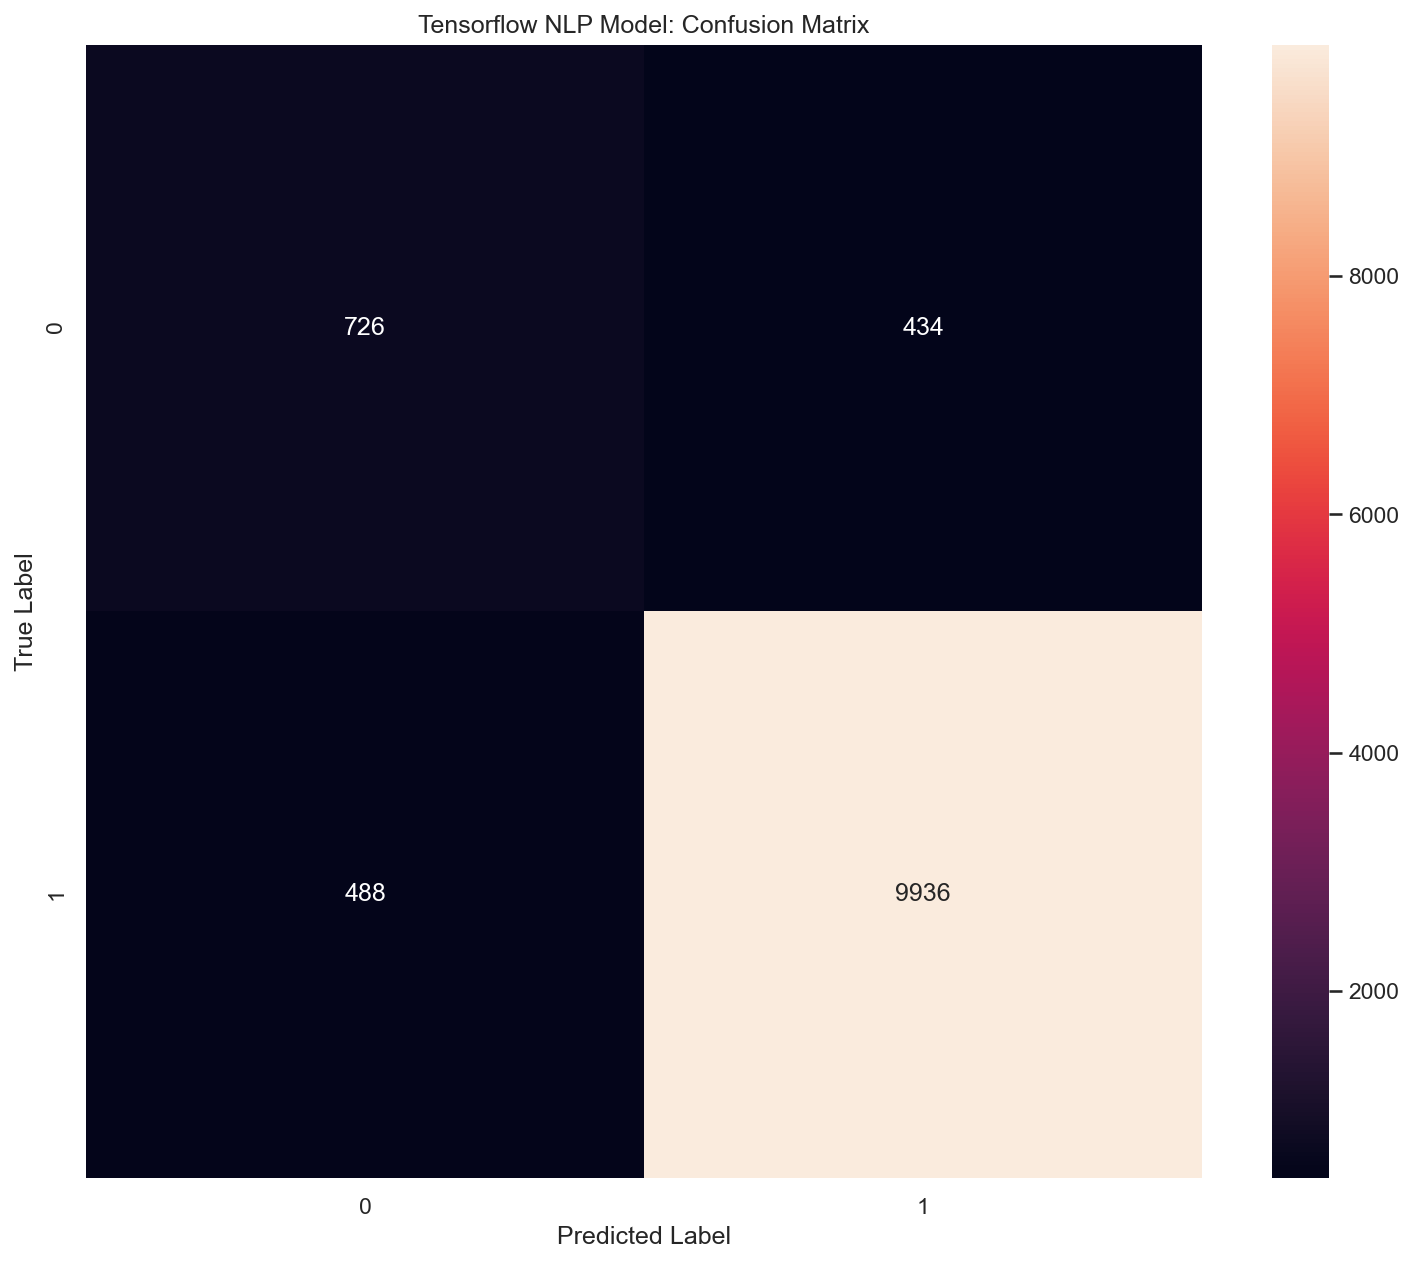

Accuracy: 0.92
Precision: 0.958
Recall / Sensitivity: 0.953
F1 Score: 0.956
ROC-AUC Score: 0.79
Confusion Matrix:
[[ 726  434]
 [ 488 9936]]


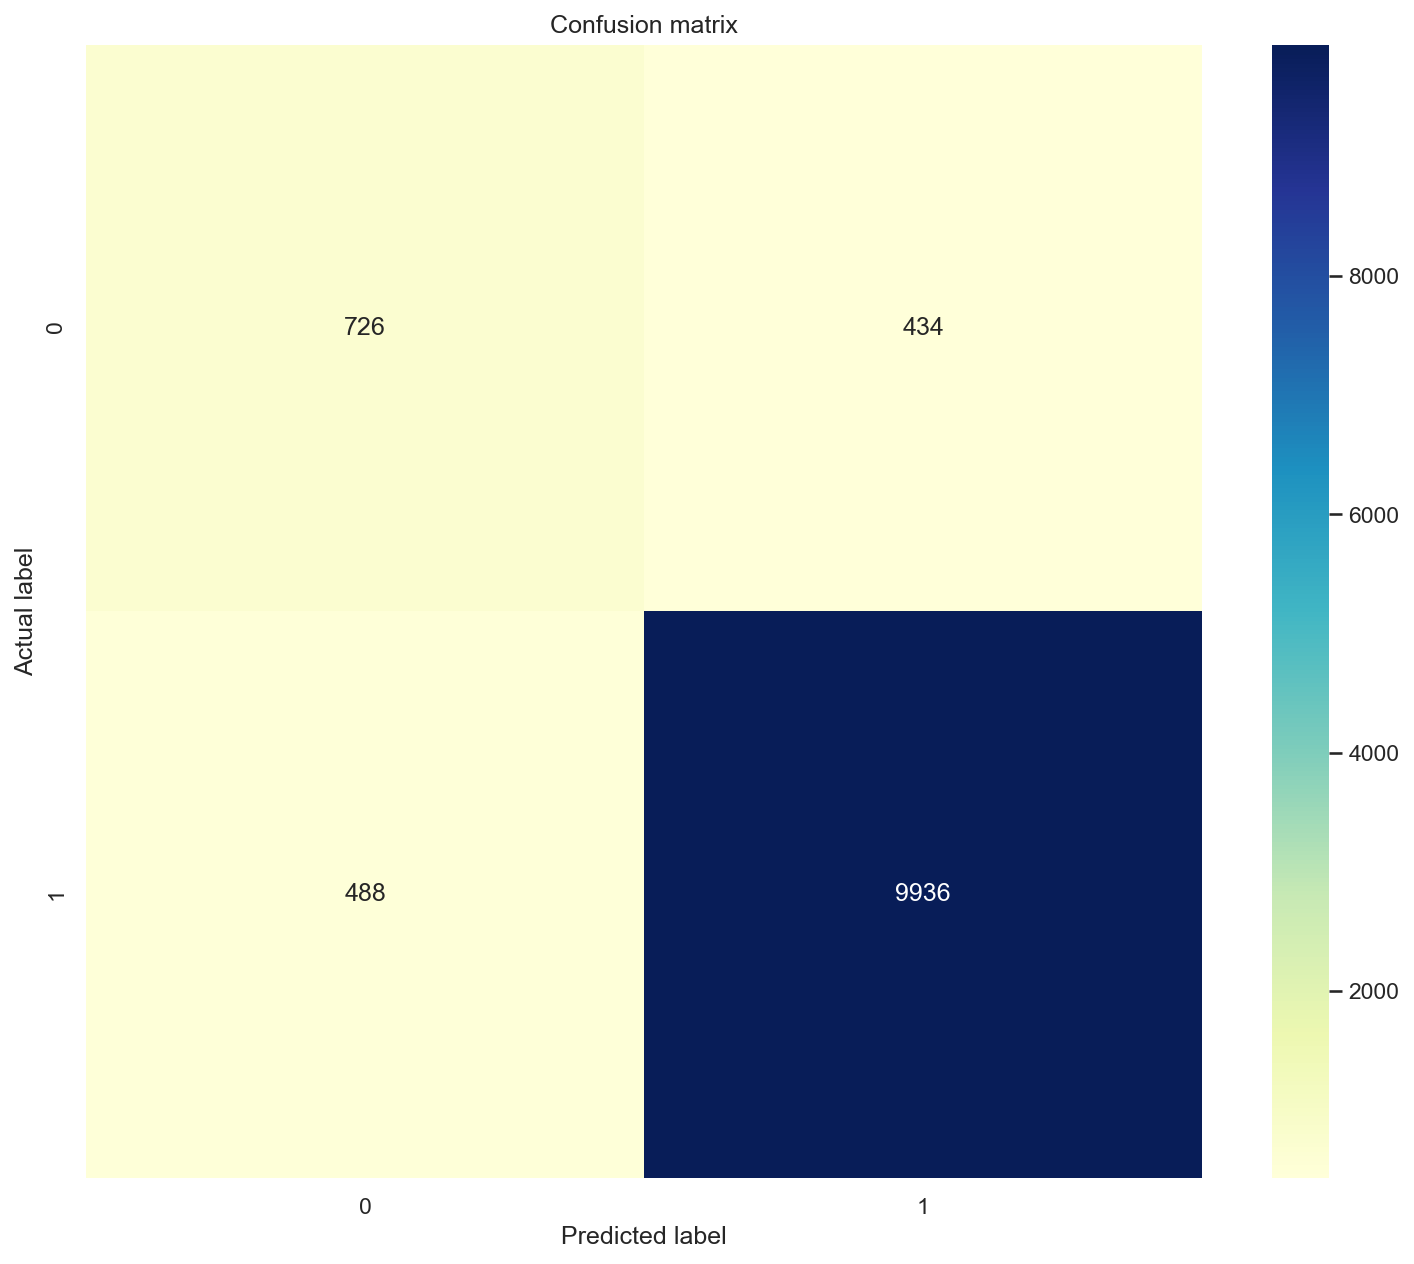

In [318]:
def create_final_network():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=2,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=False,
    )

    model = Sequential()

    # input layer
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=max_sequence_embedding,
            input_length=len(X_train[0]),
        )
    )

    # hidden layers 1
    model.add(LSTM(units=60))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # hidden layers 2
    model.add(keras.layers.Dense(30))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # output layer
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation("sigmoid"))

    model.compile(
        optimizer="adam",
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
    )

    model.summary()

    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=20,
        callbacks=[callback],
        validation_split=0.2,
        validation_data=(X_test, y_test),
        verbose=2,
    )

    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy

    model.save("FINAL_MODEL.keras")

    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]

    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    num_epochs = len(history.history.get("loss", []))
    num_epochs
    plot_scores(
        history=history,
        model=model,
        num_epochs=range(1, num_epochs + 1),
        ticks=range(0, num_epochs),
    )

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax=ax)
    ax.set_title("Tensorflow NLP Model: Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()

    create_conf_matrix(y_test, predictions)
    
    


create_final_network()



###  2.  Discuss the number of layers, the type of layers, and total number of parameters.

> The network included 12 layers.

>  The network included several layer types: Embedding, LSTM, Activation, Batch Normalization, Dense, and Dropout.

> The Input Layer is the first layer and the layer that receives the input data into the network.

> The Embedding Layer encodes the word index into a dimensional vector space with consistent vector lengths. Each word embedding is a real number, a vector representation of a word. This layer provides a densely populated encoded-word embedding space such that words are numerically represented in vectors instead of a large one-hot encoded vector (Heidenreich, 2018).

> The Long Short-Term Memory (LSTM) Layer is an RNN layer with three gates that handle information persistence. The Forget Gate determines if incoming data from a previous epoch is worth retaining or forgetting. Next, the Input Gate attempts to derive new information from input. Lastly, the Output Gate forwards new or updated information to the next epoch (Saxena, 2021).

> The Activation Layers map the summed weighted input to the output of the neuron (Kurama, 2022). These layers effectively take inputs from a previous layer and generate a nonlinear output value for the next layer. In our model, we’re using a Sigmoid Activation function to guarantee an output value between 0 and 1 (Saeed, 2021).

> The Batch Normalization Layers transform a neuron’s output such that the mean is close to 0 and the standard deviation is close to 1 (Team). This transformation effectively normalizes the value.

> The Dense Layers interconnect network layers by connecting each neuron to every neuron within the next layer. This connectivity allows a connected neuron to pass its weighted output to another neuron as an input. During the training process, the model constantly updates the weight of a neuron’s output. A weight is a coefficient that effectively controls the input’s strength or amount of signal as it travels from one neuron to the next (D, 2022).

> The Dropout Layers aid in reducing model overfitting. During this layer, we randomly zero out the weight on a percentage of a layer’s neurons. This tactic forces the network to strengthen its classification rules because the network can no longer rely on or anticipate what neurons will output to the next layer (GeeksforGeeks, 2022).

> The Output Layer represents the final network layer and the network or evaluation outcome. Since we’re using a Sigmoid Activation, we’ll receive an output between 0 and 1. Values greater than 0.5 indicate positive sentiment, whereas values less than 0.5 indicate a negative sentiment.

 

> The total number of parameters is 2,065,949. 2,065,767 of the parameters were trainable, whereas 182 were not.


### 3.   Justify the choice of hyperparameters, including the following elements:



####  activation functions
> The output layer’s activation function is Sigmoid. This function was selected because the output value needed to be between 0 and 1. Values greater than 0.5 indicate positive sentiment, whereas values less than 0.5 indicate a negative sentiment.


####  number of nodes per layer
> The number of neurons for each layer was designed such that the number of neurons decreased the further the data moved toward the output layer. Additionally, the output layer was specified to have a signal neuron that represented a binary value of 1 or 0. The Embedding Layer’s dimensions were constructed using the word index’s vocabulary size (113,598), the 4th root of the vocabulary size (18), and the average review sequence length (77). These values created an output dimension of 77x18. The input layer consisted of 77 neurons — 1 neuron per word sequence.

#### loss function
> The network’s loss function was Binary Crossentropy. We selected this function because our rating sentiments are a binary 1 or 0 value. This loss function essentially allowed us to minimize the difference between observed sentiment and predicted sentiment. Ultimately, this function worked by penalizing predictions that deviate from the observed sentiment (Jbencook, 2021).


####  optimizer

> We selected the Adaptive Moment (Adam) optimizer for the network. This optimizer was recommended as a good starting point and performed well using its default parameters.

####  stopping criteria

> We configured the stopping criteria using tf.keras.callbacks.EarlyStopping. This configuration monitored the validation loss during the training process to ensure the validation loss wasn’t increasing during two successive epochs. This callback provided a mechanism to prevent overfitting and allowed the model to conclude training if current epoch iterations failed to improve evaluation metrics.

####  evaluation metric
> The primary evaluation metric for the model was accuracy. This metric identified how often the model correctly predicted positive or negative sentiment. Additionally, this metric allowed us to see model overfitting by comparing the accuracy of the training, validation, and test datasets. The training accuracy was 96%, the validation accuracy was 92% and the testing accuracy was 92%. Overall, there was slight overfitting, but the accuracy was high and close on the validation and test datasets.

# Part IV:  Model Evaluation



## D.  Evaluate the model training process and its relevant outcomes by doing the following:


### 1.  Discuss the impact of using stopping criteria instead of defining the number of epochs, including a screenshot showing the final training epoch.
> The stopping criteria and the early stopping callback played a crucial role in reducing overfitting and reducing the feedback loop during hyperparameter tuning. We configured the network to run 20 epochs, however, the stopping criteria determined it was worth ending the training during the 6th epoch since the validation loss was no longer decreasing.

### 2.   Provide visualizations of the model’s training process, including a line graph of the loss and chosen evaluation metric.


###  3.  Assess the fitness of the model and any measures taken to address overfitting.
> The model has a strong fit with an accuracy of 92% on unseen data and an F1 Score of 96%. Overall, the model strikes a strong balance between Precision and Recall. To address overfitting we added the EarlyStopping callback, implemented Dropout layers, and used 20% of the test data during the training process to validate the model.

In [321]:
FINAL_MODEL = keras.models.load_model('FINAL_MODEL.keras')

In [322]:
# MODEL EVALUATION AGAINST TEST

test_loss, test_accuracy = FINAL_MODEL.evaluate(X_test, y_test)
f"{test_loss = }"
f"{test_accuracy = }"


362/362 [==============================] - 2s 5ms/step - loss: 0.2205 - accuracy: 0.9204


'test_loss = 0.22050254046916962'

'test_accuracy = 0.9204074740409851'

Epoch 1/20
1448/1448 - 42s - loss: 0.0304 - accuracy: 0.9928 - val_loss: 0.3793 - val_accuracy: 0.9209 - 42s/epoch - 29ms/step
Epoch 2/20
1448/1448 - 45s - loss: 0.0301 - accuracy: 0.9928 - val_loss: 0.4063 - val_accuracy: 0.9161 - 45s/epoch - 31ms/step
Epoch 3/20
1448/1448 - 49s - loss: 0.0255 - accuracy: 0.9942 - val_loss: 0.4785 - val_accuracy: 0.9119 - 49s/epoch - 34ms/step
Epoch 3: early stopping


'num_epochs = 3'

,loss,accuracy,val_loss,val_accuracy
0,0.42,0.80,0.34,0.85
1,0.23,0.91,0.37,0.85
2,0.15,0.94,0.42,0.84


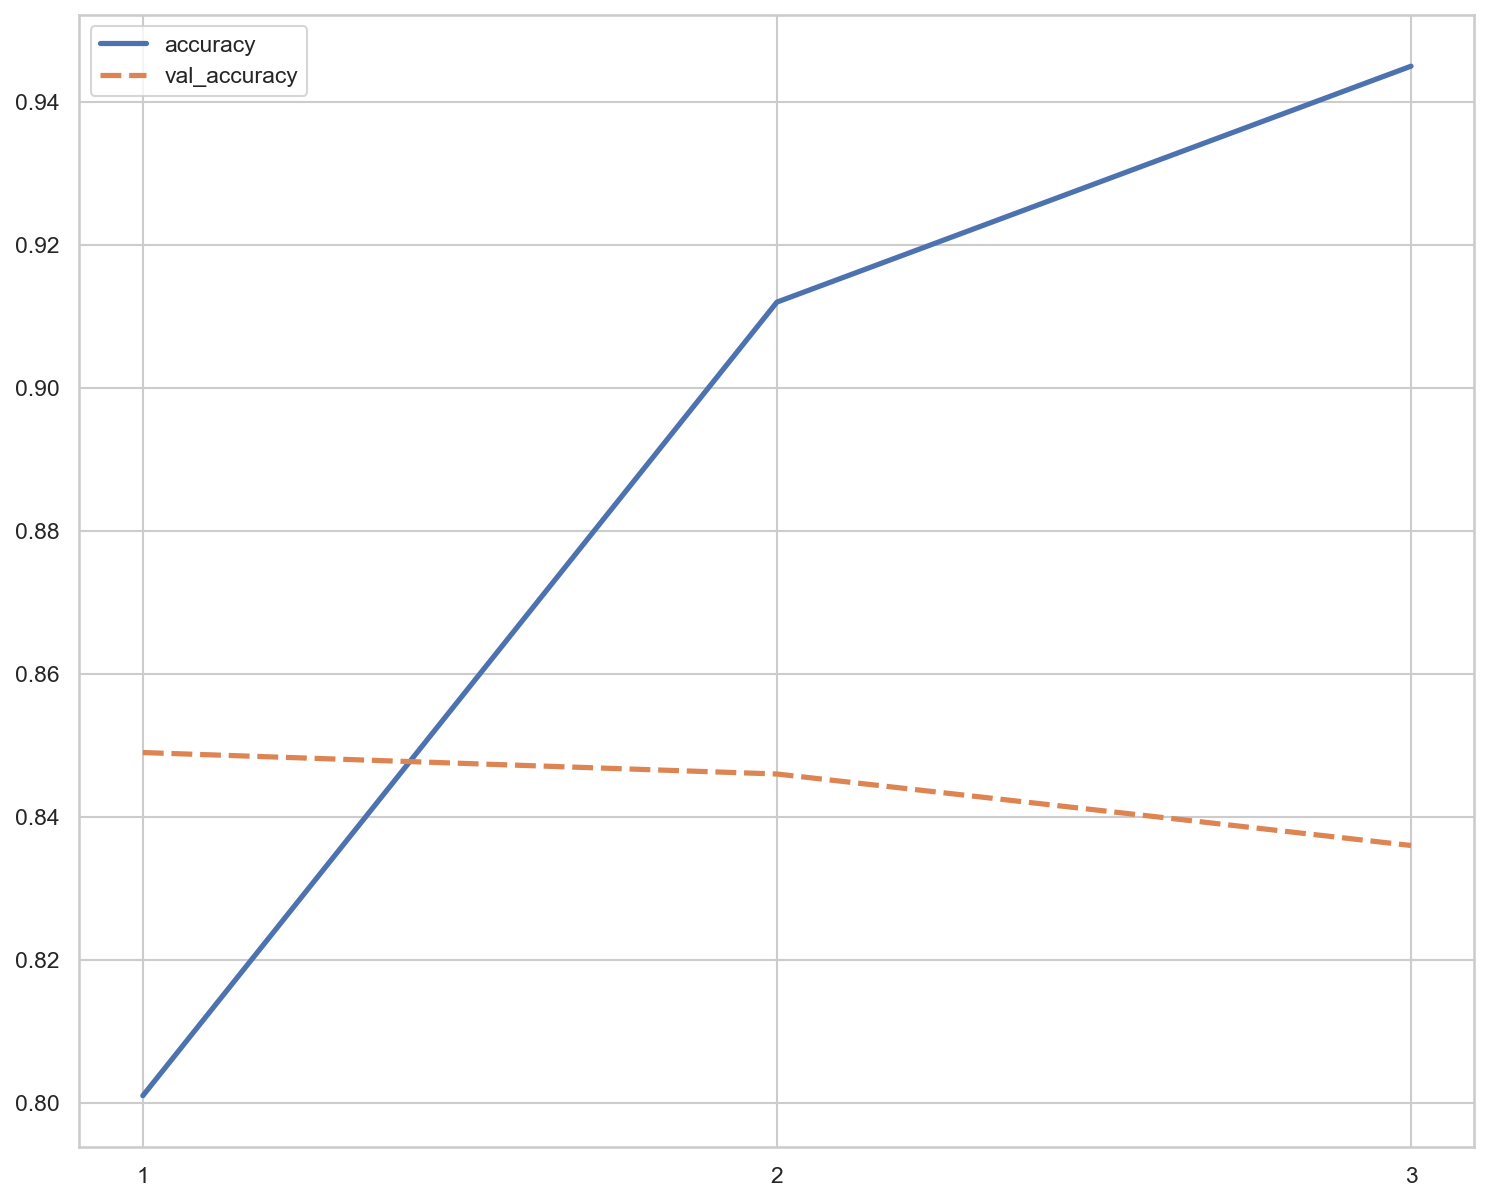

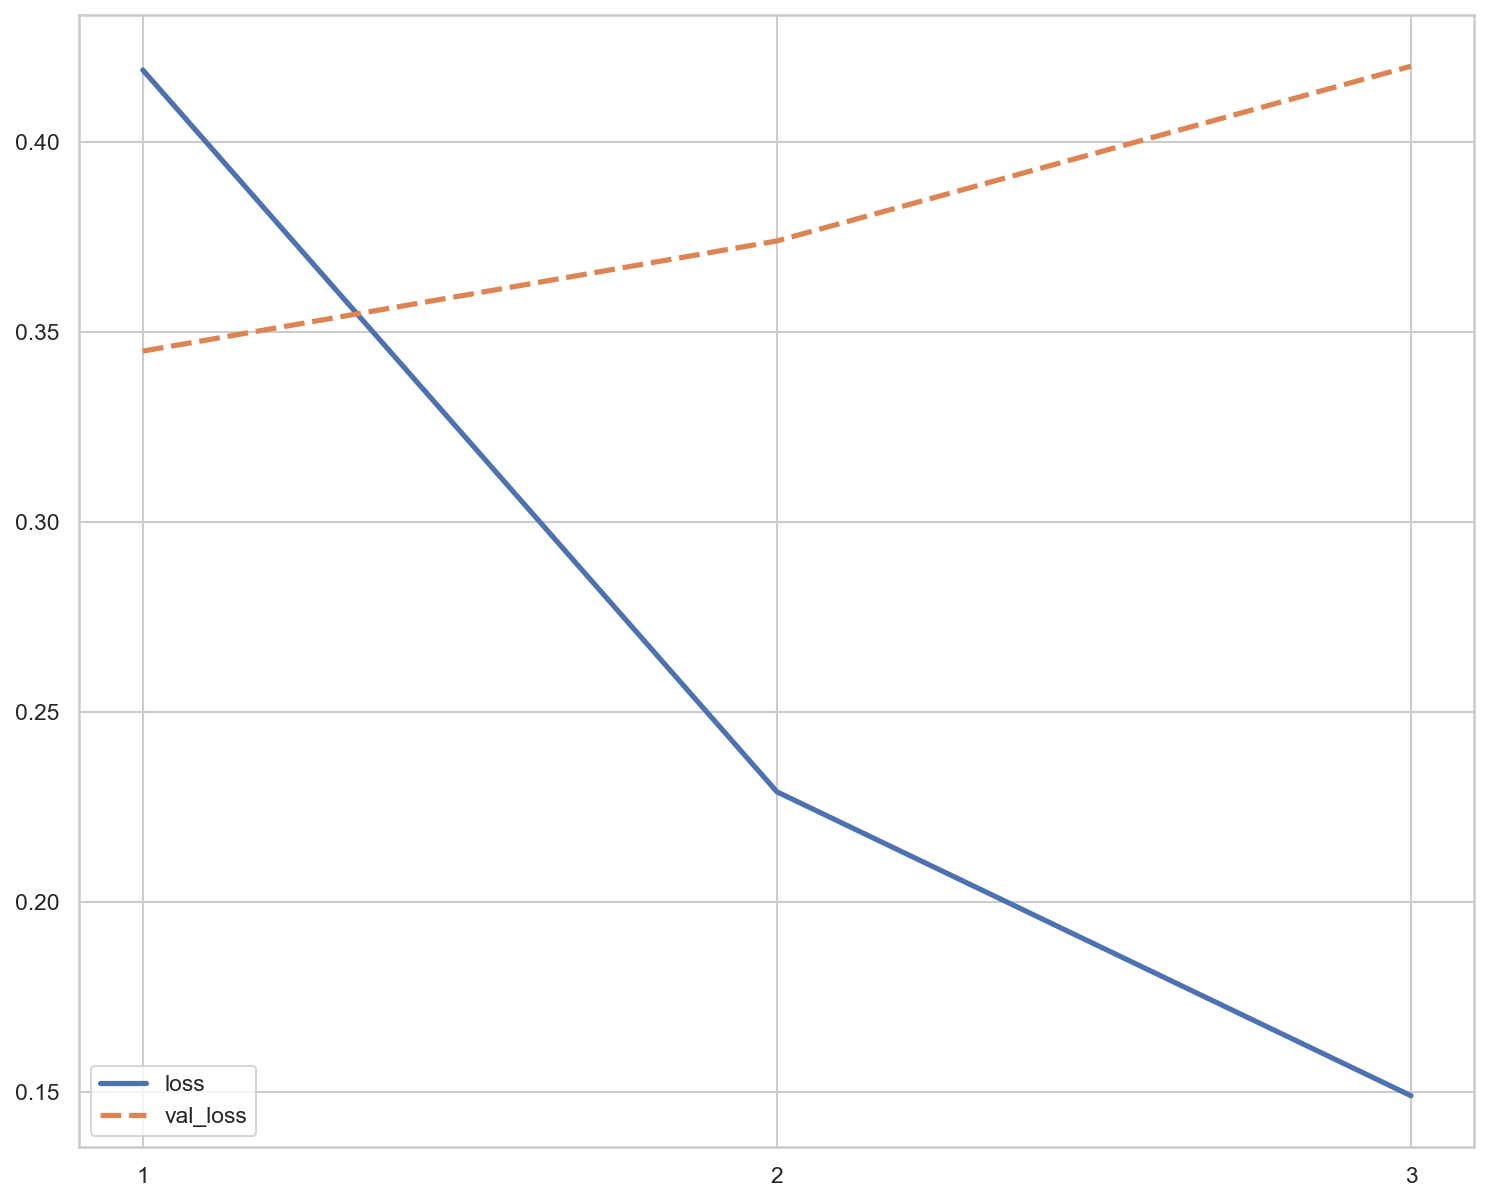

In [328]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=False,
)
    
FINAL_MODEL_HISTORY = FINAL_MODEL.fit(
    x=X_train,
    y=y_train,
    epochs=10,
    callbacks=[callback],
    validation_split=0.2,
    validation_data=(X_test, y_test),
    verbose=2,
)

num_epochs = len(FINAL_MODEL_HISTORY.history.get("loss", []))
f"{num_epochs = }"

plot_scores(
    history=history,
    model=model,
    num_epochs=range(1, num_epochs + 1),
    ticks=range(0, num_epochs),
)




### 4.  Discuss the predictive accuracy of the trained network.
> The final model’s predictive accuracy was 92%. This indicates that 92% of the time the model correctly classified the positive or negative sentiment using the word choice from an unseen music review. The training loss was 0.1198 and the validation loss was: 0.2257. Effectively, the model’s training predictions were closer to the observed values than the validation’s predictions to the validation’s observed values.

362/362 [==============================] - 2s 5ms/step
Accuracy: 0.912
Precision: 0.953
Recall / Sensitivity: 0.949
F1 Score: 0.951
ROC-AUC Score: 0.765
Confusion Matrix:
[[ 675  485]
 [ 535 9889]]


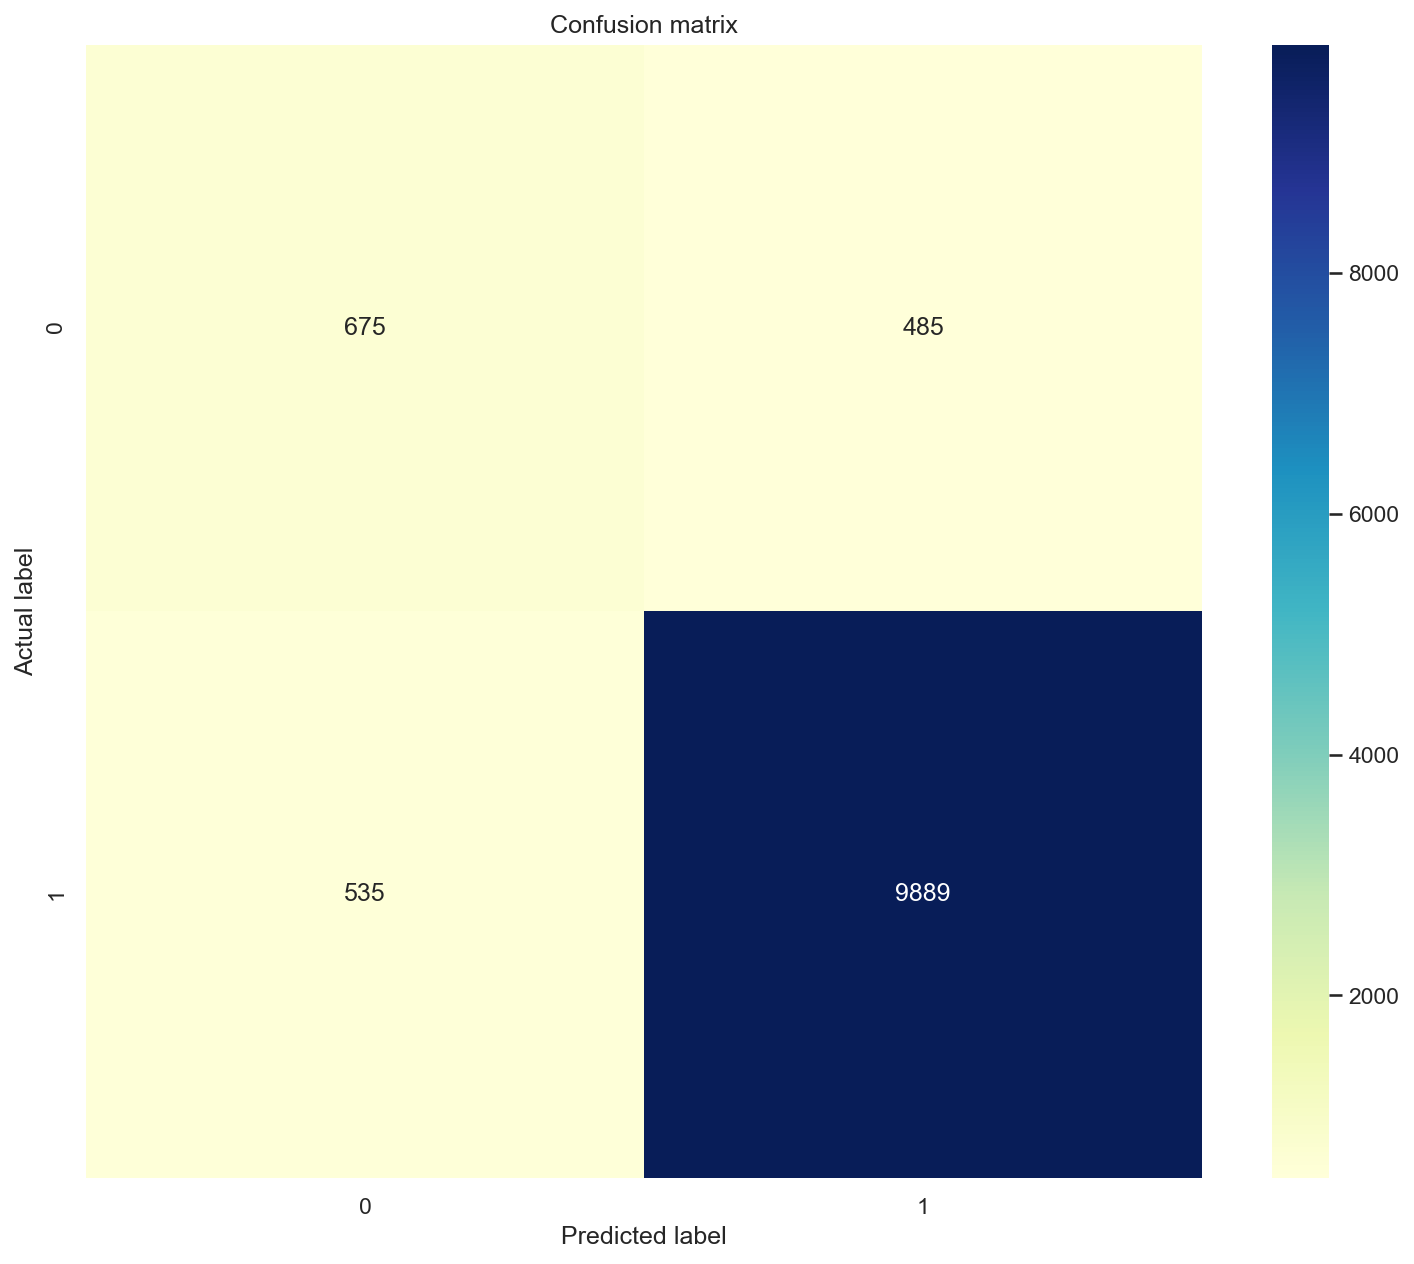

In [331]:
predictions = (FINAL_MODEL.predict(X_test) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]

create_conf_matrix(y_test, predictions)


In [372]:
def predict_sentiment(text, tokenizer, model, maxlen):
    original_text = text
    
    # strip white space and lowercase review
    text = text.strip().lower()

    # remove non-word characters
    text = " ".join(RegexpTokenizer("[a-z-A-Z']+").tokenize(text))

    # Remove unusual characters: uppercase letters, punctuation marks, emoticons, and non-English characters.
    text = " ".join(tf.keras.preprocessing.text.text_to_word_sequence(text))

    # lemmatize and remove english stop words
    text = clean_text(s=text.split(" "), tokenizer=TOKENIZER)
    
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen=maxlen)
    prediction = int(model.predict(tw).round().item())
    
    print(f"{prediction = }")
    print(f"{original_text = }", end="\n\n")
    
    return text, prediction

In [366]:
test_df.head()

,raw_text,padded_text,pos_neg_sentiment
0,"When the cover is the best part of the CD, you're in trouble. Jupiter One's ""Sunshower"" is derivative and strangely hollow. The music is constructed of spare parts left over from other bands, particularly the Flaming Lips. Musically, they seem to know how to play their instruments, which is a plus. Not a note or a harmony out of place.Or perhaps I should say, their producer can edit things together to where it sounds like they know how to play their instruments. The reason I say that last is because there is a falseness, a hollowness, to Jupiter One's music that I can't precisely define. Their music gives the illusion of substance but when I really listen to it, it dissolves into its derivatives and disappears. The lyrics vary between I-love-you rubbish and incomprehensibility, always seeming like they're going to say something enlightening, but they never really make it. The music is the same; it almost seems like something is going to happen, but it never does.Jupiter One's ""Sunshower"" is clever in a completely vacuous way. It gives the illusion of being memorable pop, but their hooks don't stick in the brain and their songs don't return to haunt me. ""Sunshower"" is a candy bar; sweet for a moment, empty calories, made by a corporation, and in the final analysis, not all that good for you. The best thing about the CD is ultimately the cover, which is peculiar enough to almost be art. The rest of it? Not so much.Finally, I find it very odd that their promotional material mentions the producer when the production itself is so poor. I have to be honest. The sound is muddy and ill-mixed, and nobody should be proud of the production, engineering or mixing on this album. The dynamics of the music are muddled and nothing sounds as if it were recorded right, or well. If I were Chris Ribando I definitely would not have insisted on a producer credit, or I would have used an ""Alan Smithee"" on this one. The production is some of the worst I've heard coming from a major label.","[48, 263, 943, 1758, 3, 584, 1, 1, 1605, 1211, 385, 276, 1849, 1, 77, 1, 664, 1, 12, 17, 58, 13, 1746, 164, 1, 162, 134, 498, 202, 31, 365, 115, 1177, 1, 238, 734, 354, 101, 1288, 928, 14, 2395, 1684, 821, 1079, 1862, 101, 1, 2068, 2, 1331, 10, 1, 152, 14, 253, 97, 22, 1267, 1, 177, 26, 1, 354, 905, 26, 257, 3448, 1, 6, 101, 647, 136, 61, 381, 578, 482]",0
1,"I admit that 2003 was a lousy year for alternative rock...but at least Broadcast released this gem of an album that has discovered some new territory in the the reto-60s/kitcsh/mod/post-modern/avant-garde whatever-the-hell category of music that almost seemed to have reached a dead-end after Stereolab came out with &quot;E-T-Ketchup.&quot;...Bepop/Jazz style Percussions take preeminence here. They nicely incorporate the bass drum, triangles, and symbols in a beautiful improvisational ambient-pop roll and klang. It almost teeters on the verge of instrumental cacophony but the simple melody holds together to a totally satisfying session.","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 786, 5, 1, 30, 920, 23, 244, 1, 96, 510, 2, 9, 1740, 32, 1698, 1, 1, 1, 997, 518, 3557, 3947, 692, 547, 1804, 10, 134, 702, 1632, 612, 103, 1, 158, 4, 353, 1, 4, 1, 193, 83, 1014, 66, 1, 1124, 1, 213, 234, 1, 1, 117, 1, 2081, 48, 358, 1, 134, 1, 1, 426, 1, 368, 189, 382, 211, 621, 2072, 833]",1
2,"With ""Chaos & Creation,"" Paul McCartney has finally put out an album by the guy who wrote ""Eleanor Rigby,"" ""Blackbird,"" and ""Hey Jude,"" the guy who wrote songs in all shades, not just bright pastels. You can't help but think this CD is the product of all the grief Sir Paul has gone through since Linda's death, including the ill-fated second marriage, the tabloidization of his life, the death of George Harrison and general intimations of mortality.Not say there aren't upbeat songs here. ""Fine Line"" is a front-parlor rocker and ""English Tea"" is silly (but in a more knowing way than his Wings-

In [376]:
for i in range(0, 11):
    f"{test_df.iloc[i].pos_neg_sentiment = }"
    text, prediction = predict_sentiment(test_df.iloc[i].raw_text, tokenizer=TOKENIZER, model=FINAL_MODEL, maxlen=max_review_length)


'test_df.iloc[i].pos_neg_sentiment = 0'

1/1 [==============================] - 0s 14ms/step
prediction = 0
original_text = 'When the cover is the best part of the CD, you\'re in trouble. Jupiter One\'s "Sunshower" is derivative and strangely hollow. The music is constructed of spare parts left over from other bands, particularly the Flaming Lips. Musically, they seem to know how to play their instruments, which is a plus. Not a note or a harmony out of place.Or perhaps I should say, their producer can edit things together to where it sounds like they know how to play their instruments. The reason I say that last is because there is a falseness, a hollowness, to Jupiter One\'s music that I can\'t precisely define. Their music gives the illusion of substance but when I really listen to it, it dissolves into its derivatives and disappears. The lyrics vary between I-love-you rubbish and incomprehensibility, always seeming like they\'re going to say something enlightening, but they never really make it. The music is the same; it 

'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 35ms/step
prediction = 1
original_text = 'I admit that 2003 was a lousy year for alternative rock...but at least Broadcast released this gem of an album that has discovered some new territory in the the reto-60s/kitcsh/mod/post-modern/avant-garde whatever-the-hell category of music that almost seemed to have reached a dead-end after Stereolab came out with &quot;E-T-Ketchup.&quot;...Bepop/Jazz style Percussions take preeminence here.  They nicely incorporate the bass drum, triangles, and symbols in a beautiful improvisational ambient-pop roll and klang.  It almost teeters on the verge of instrumental cacophony but the simple melody holds together to a totally satisfying session.'



'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 18ms/step
prediction = 1
original_text = 'With "Chaos & Creation," Paul McCartney has finally put out an album by the guy who wrote "Eleanor Rigby," "Blackbird," and "Hey Jude," the guy who wrote songs in all shades, not just bright pastels.  You can\'t help but think this CD is the product of all the grief Sir Paul has gone through since Linda\'s death, including the ill-fated second marriage, the tabloidization of his life, the death of George Harrison and general intimations of mortality.Not say there aren\'t upbeat songs here.  "Fine Line" is a front-parlor rocker and "English Tea" is silly (but in a more knowing way than his Wings-era silliness), but the songs that stick are deeply soulful: "Jenny Wren," which might be his best post-Beatles tune since "Maybe I\'m Amazed," and "Promise to You Girl," which, while upbeat, has an undertone of desperation.  Mostly, this CD represents the artist Paul\'s return and triumph over the mere entertain

'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 18ms/step
prediction = 1
original_text = 'The last ten years have been an interesting journey for British soul singer Marsha Ambrosius. She penned the hit single "Butterflies" for Michael Jackson before she even had an album. She released a couple of successful records with her former partner Natalie Stewart as part of the short-lived duo Floetry. She became the go-to-girl for singing hooks on hip hop songs from artists like Nas, The Game, Blackalicious, Wale and David Banner. She also was signed to Dr. Dre\'s Aftermath Entertainment for a number of years...and like everyone else signed to the label that\'s not named Dr. Dre, 50 Cent or Eminem, her project was put on the back burner- when the release dates weren\'t being pushed back repeatedly. After years of numerous delays and setbacks, Marsha decided to part ways with Aftermath and sign with Clive Davis\' J Records, where she released her long overdue debut album "Late Nights & Early Morning

'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 16ms/step
prediction = 1
original_text = 'Prince was not the most successful aritst sales wise of the 1980s (even though he toppped the charts with "Purple Rain" and a number of big singles) but arguably it was his greatest decade of musical output.  Nearly every year the prolific singer-songwriter-musician had a full studio release out (excluding only 1983 when he was touring, making "Purple Rain"  and working a handful of albums for others in his Minneapolis fam).  In the case of "LoveSexy", the experimental musical madman messed with the emerging format of compact disc.  Instead of letting listeners go right to their favorite tracks, one of the many benefits of the new media, the 1988 album was released as only one long track with nine songs almost seamlessly mixed so that it is almost one continuous song.Thematically, the album is a companion to the dark, dense and humorous "The Black Album".  Released as a substitute when that album was pu

'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 14ms/step
prediction = 1
original_text = "First of all, I have been a huge Mobb fan since I bought The Infamous and Amerikaz Nightmare last year.  Since then, I have also gotten Infamy and Hell On Earth, both awesome albums as well.  But I have to admit that I was a little confused when Mobb Deep signed with G-unit.  I mean, why would one of the best rap duos of all time need to sign with a pop rap group?  Now, it just seems that they did it to get their money, and their is nothing wrong with that, if they would have retained their original mobb style.  But Prodigy has obviously slipped as a lyricist, but luckily Havoc steps his game up here.  The production is consistently good on the album, and there are a couple of guest appearences, by none other than 50 Cent himself.  He is on 5 of the songs!  Mobb doesn't need 50 to help carry the album.  They can do it themselves and that is a big problem with me.  The best songs are Speaking So Freely, 

'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 16ms/step
prediction = 1
original_text = "Like any great album, Cast of thousands took me a couple of listenings to absorb my body, soul and everything it found along the way. From the opener Ribcage to the last second of Flying dream, this is an album nobody who truly appreciates good music can miss. Gone are the allusions to misery and darkness from Asleep in the back, even though we can still perceive some &quot;blue&quot; moments that only serve to add more to its grandiose eloquence. It is very hard to pick a standout track, and personally I consider it to be unfair. The entire record is an exaltation to beauty, love and hope. Buying the import was worth it. I couldn't wait for the domestic release. Well, one other reason is that my name appears in the limited edition booklet, with the lyrics. What are you waiting for? go buy the album!"



'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 16ms/step
prediction = 1
original_text = "Let's see here, there have been 3 volumes of Greatest Hits released, and various other 'hits' compilations and assorted boxed sets. One would think that everything that could be done to show Sir Elton's career was over and done with. This latest collection doesn't really do anything to outshine all of the other numerous compilations, some of which were a little better(I am of course speaking about the boxed set To Be Continued...., which was released in 1990). However, this set is up to date with Elton's career. It includes his two latest 2001 hits &quot;I Want Love&quot; and &quot;This Train Don't Stop There Anymore&quot;, both off of his stunning album &quot;Songs From The West Coast&quot;. The current single, &quot;Original Sin&quot;, is nowhere to be found. That's the only high selling point for this latest collection. Two newer hits. The rest is filled with songs you would of expected to find. Ther

'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 14ms/step
prediction = 1
original_text = "This is my favorite studio album by Amy Grant. Heart in motion is an upbeat pop album with very little religious overtones. Only 2 songs seem to talk about God/Jesus and that is &#34;Ask Me&#34; & &#34;Hope Set High.&#34;It's a fun album and I wish she did more pop albums like this. I really like the feel of the album front to finish. Tracks that stand out to me are &#34;I Will Remember You,&#34; &#34;Baby, Baby&#34; and &#34;That's What Love is For.&#34; I don't know far this album went back in the 90's, but I would hope it reached no. 1, cause I feel as if it deserves a high rating. Its musically fun, lyrics flow off the tongue, and it leaves you feeling good."



'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 15ms/step
prediction = 1
original_text = 'I still think "Killer" was the original Alice Cooper band\'s best album, but this one is a very strong contender for the runner-up spot (along with "Billion Dollar Babies").This was the first of the group\'s "classic" releases (and their third one in all), and it originally came out in January 1971, heralded by the single "Caught In A Dream".One of the band\'s best-known songs, "I\'m Eighteen," played a big part in making the album a top 40 hit, as did another classic, "Is It My Body." But like Alice Cooper\'s other early records, "Love It To Death" is a very consistent listen, a stylistically varied and supremely well executed rock n\' roll album."Caught In A Dream" is a melodic mid-tempo rocker, and "Long Way To Go" is straight-ahead thumping garage rock. Then comes the impressive nine-minute epic "Black Juju", which would have looked at home on a Doors set list, and the eerie "Ballad Of Dwight Frye" 

'test_df.iloc[i].pos_neg_sentiment = 1'

1/1 [==============================] - 0s 15ms/step
prediction = 1
original_text = '"Somebody That I Used To Know" by Australian indie artist Gotye (Wally de Backer) has become the surprise hit of early 2012 in the United States.  The song is currently the number one most popular track on Spotify.  Gotye is currently the most popular homegrown artist is Australia (arguably). From the looks of it, Gotye is on his way to becoming a popular artist in the U.S.In Australia, Gotye became a household name after releasing the critically and commercially successful album "Drawing Blood" in 2007.  Gotye has been compared to Sting and Peter Gabriel.  The comparisons are apt. Like Gabriel, Gotye\'s music is very experimental and textured. His singing delivery and voice is similar to Sting. "Making Mirrors", Gotye\'s third studio album, takes off where "Like Drawing Blood" left off.The aforementioned song ("Somebody That I Used To Know") is tale of a lost lover and draws on folk, pop, and electroni

# Part V:  Summary and Recommendations



## E.  Provide the code used to save the trained network within the neural network.


## F.  Discuss the functionality of your neural network, including the impact of the network architecture.

> The Neural Network effectively used 46,333 music reviews containing word sequences that were 77 words long to create a model that is 92% accurate. During the training process, the model used 20% of the test data to validate. Once the training process was completed, we then used 1,000 unseen customer reviews to validate the 92% accuracy. Throughout the process, we effectively used NLP to analyze and predict customer sentiment on reviews based on a customer’s word choice.

> The impact of this architecture is that with 92% accuracy we can determine a positive or negative customer sentiment using a customer’s choice of words.


## G.  Recommend a course of action based on your results.
> My recommended course of action is to adopt the Neural Network model and continually update the model to use newer reviews and possibly fewer layers.


# Part VI: Reporting



## H.  Create your neural network using an industry-relevant interactive development environment (e.g., a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.


##  I.  List the web sources used to acquire data or segments of third-party code to support the application.

- https://builtin.com/data-science/feedforward-neural-network-intro
- https://datascience.stackexchange.com/questions/82440/valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupported-object-type
- https://developers.google.com/machine-learning/glossary
- https://github.com/keras-team/keras/blob/v2.10.0/keras/preprocessing/text.py#L194-L575
- https://medium.com/mlearning-ai/introduction-to-neural-networks-weights-biases-and-activation-270ebf2545aa
- https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
- https://stackoverflow.com/questions/58270692/write-pandas-dataframe-with-list-in-column-to-a-file
- https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
- https://stackoverflow.com/questions/62060809/column-dtype-with-pandas-read-json
- https://stackoverflow.com/questions/63614790/why-am-i-getting-the-error-re-error-multiple-repeat-at-position-2
- https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/
- https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
- https://www.educba.com/recurrent-neural-networks-rnn/
- https://www.geeksforgeeks.org/dropout-in-neural-networks/
- https://www.nltk.org/api/nltk.tokenize.regexp.html
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

##  J.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

D, A. (2022, March 21). Introduction to neural networks - weights, biases and activation. Medium. Retrieved September 30, 2022, from https://medium.com/mlearning-ai/introduction-to-neural-networks-weights-biases-and-activation-270ebf2545aa 

GeeksforGeeks. (2022, June 20). Dropout in neural networks. GeeksforGeeks. Retrieved September 30, 2022, from https://www.geeksforgeeks.org/dropout-in-neural-networks/ 
Ghoshal, A. (2021, March 2). Types of neural networks: Top 6 different types of neural networks. EDUCBA. Retrieved September 30, 2022, from https://www.educba.com/types-of-neural-networks/ 

Heidenreich, H. (2018, August 16). Introduction to word embeddings. Medium. Retrieved September 30, 2022, from https://towardsdatascience.com/introduction-to-word-embeddings-4cf857b12edc 

Kilinc, C. (2020, April 3). Padding for NLP. Medium. Retrieved September 30, 2022, from https://medium.com/@canerkilinc/padding-for-nlp-7dd8598c916a 
Kurama, V. (2022, August 31). Feedforward Neural Networks: A quick primer for Deep Learning. Built In. Retrieved September 30, 2022, from https://builtin.com/data-science/feedforward-neural-network-intro 

Pai, A. (2022, June 21). What is tokenization: Tokenization in NLP. Analytics Vidhya. Retrieved September 30, 2022, from https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/ 

Pedamkar, P. (2022, April 11). Recurrent neural networks (RNN): Working: Steps: Advantages. EDUCBA. Retrieved September 30, 2022, from https://www.educba.com/recurrent-neural-networks-rnn/ 

Saeed, M. (2021, August 17). A gentle introduction to sigmoid function. Machine Learning Mastery. Retrieved September 30, 2022, from https://machinelearningmastery.com/a-gentle-introduction-to-sigmoid-function/ 

Saxena, S. (2021, March 18). LSTM: Introduction to LSTM: Long short term memor. Analytics Vidhya. Retrieved September 30, 2022, from https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/ 

Team, K. (n.d.). Keras Documentation: Batchnormalization layer. Keras. Retrieved September 30, 2022, from https://keras.io/api/layers/normalization_layers/batch_normalization/ 

TensorFlow Team. (2017, November 20). Introducing tensorflow feature columns. Google Developers Blog. Retrieved September 30, 2022, from https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html 
